<h2><center>Programa Nanodegree Engenheiro de Machine Learning</center></h2>
<h3><center>Relatório do projeto de conclusão de machine learning - Capstone</center></h3>
<br>
<center>  
Robson Azevedo Rung<br>
    <i>30/07/2019</i>
</center> 

### Visão geral do projeto

Esse projeto busca desenvolver uma solução baseada em técnicas de machine learning para prever preços de imóveis.

Imóveis são bens de grande relevância para qualquer sociedade, e têm seus preços formados não de forma única, mas a partir das características que possuem. [A]

Assim sendo, os consumidores potenciais têm a percepção de diferenciaras diversas possibilidades de características em função do que é tido como prioritário. Desta maneira, um determinado consumidor pode escolher seu "pacote" de características disponíveis para cada bem ou serviço em função da percepção de utilidade.

Muitos estudos buscam determinar os atributos intrínsecos e extrínsecos pertencentes a cada residência, a fim de verificar quais deles apresentam maior representatividade para a composição dos instrumentos de demanda e oferta, utilizando-se modelos de preços hedônicos, por meio dos quais é possível analisar a importância relativa de cada atributo em função dos diferentes perfis sociodemográficos. [B]

Uma das atividades de empresas e profissionais do ramo imobiliário é a analisar o valor de imóveis, com objetivo de vendê-los em tempo razoável e maximizar seus lucros.

O conjunto de dados deste trabalho será aquele disponibilizado na competição intitulada *"House Prices: Advanced Regression Techniques"* da plataforma Kaggle. [C]

Constam dos dados diversos atributos, por exemplo:

- Tipo da propriedade;
- Tamanho do lote;
- Recursos públicos disponíveis (eletricidade, gás, água e saneamento);
- Condições de acesso;
- Acabamento (materiais);
- Estado de conservação;
- Tipo da fundação;
- Tipo de aquecimento;
- Sistema elétrico;
- Características da garagem;
- Idade do imóvel;
- etc.

Os dados são fornecidos em dois grupos, um de treinamento e outro de teste (esse não contém o preço de venda, e deve ser usada para envio à competição).

### Declaração do problema

Entender quais características são as mais relevantes e como impactam os preços é tarefa complexa por si só. Além disso, tais fatores podem mudar ao longo do tempo e variam entre regiões geográficas. Podem, ainda, ser afetadas por diferenças culturais e climáticas.

Inicialmente serão usadas técnicas de análise de dados para buscar obter uma compreensão dos tipos de atributos existentes na base de dados, considerando seus tipos de dados e suas possíveis correlações. 

Como auxílio à análise, estatísticas como média, mediana, desvio padrão, valores máximos e mínimos serão calculadas.

Os atributos que precisarem de tratamento especial, como a aplicação de normalização ou *one-hot enconde* serão devidamente tratados. Dados ordinais textuais serão convertidos em numéricos.

Buscar-se-á, também, a aplicação da técnica de seleção de atributos (*feature selection*) conhecida como PCA (*Principal Component Analysis*), de modo a evitar-se o problema da dimensionalidade (*curse of dimensionality*).

Será conduzida uma uma busca por *outliers* e dados faltantes, de modo a evitar distorções nos modelos durante o treinamento.

Agora será realizado o treinamento dos modelos. Para o caso da aprendizagem supervisionada, será conduzida uma otimização dos hiperparâmetros usando a técnica de *grid search*, validação com *cross-validation* e regularizção (*regularization*).
    
Agora será realizado o treinamento dos modelos. Para o caso da aprendizagem supervisionada, será conduzida uma otimização dos hiperparâmetros usando a técnica de *grid search*.

Além disso, a mesma tarefa será realizada usando técnicas de deep learning. Será criada e treinada uma rede neural com os dados fornecidos.

For fim, o coeficiente de determinação será calculado para avaliar a performance dos modelos.

### Métricas

Para avaliar a performance dos modelos, será calculado o coeficiente de determinação (R2), um modelo bastante usado para analisar regressões.

O valor de R2 indica o percentual de correlação quadrática entre os valores previstos e os valores reais. Quando o resultado é igual a 0, o modelo de regressão se equivale a um modelo que sempre tem como resultado a média amostral (dados de treinamento). Por outro lado, quando R2 é igual a 1, significa que o modelo foi capaz de prever com precisão os valores da variável alvo.

É possível que R2 tenha como resultado um valor negativo, o que significa que o modelo de regressão é pior do que um modelo que sempre prevê a média.

A competição no Kaggle utiliza-se, para comparar as soluções que são submetidas, a métrica Root Mean Squared Logarithmic Error - RMSLE. Essa métrica calcula a raiz quadrada da média do quadrado das diferenças entre o valor original e o valor previsto. O uso de logs tem como objetivo evitar que erros nos valores previstos de imóveis caros afete mais o resultado do que erros em imóveis baratos. Essa métrica também será calculada neste projeto.

Além disso, com o objetivo de comparação entre as soluções propostas e uma métrica inicial, do tipo ingênua (*naive*), serão calculadas as métricas acima para um conjunto de dados que tenha como preços estimados exatamente a média dos preços de venda existentes. O mesmo procedimento será feito para a mediana.

#### Importação das bibliotecas usadas no projeto

In [1]:
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import locale
import math
from math import sqrt
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LassoLars
from sklearn.linear_model import LassoCV
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


#### Carregamento da Base de Dados

In [2]:
train = pd.read_csv("train.csv")

#### Cálculo das estatísticas

In [3]:
locale.setlocale(locale.LC_ALL, 'en_US.utf8') 

Y_train_full = train["SalePrice"]
X_train_full = train.drop(["SalePrice"], axis=1)

print("Valor mínimo do conjunto de treinamento ------>  {}".format(locale.currency(np.min(Y_train_full), grouping=True)))
print("Valor máximo do conjunto de treinamento ------> {}".format(locale.currency(np.max(Y_train_full), grouping=True)))
print("Valor da média do conjunto de treinamento ----> {}".format(locale.currency(np.mean(Y_train_full), grouping=True)))
print("Valor da mediana do conjunto de treinamento --> {}".format(locale.currency(np.median(Y_train_full), grouping=True)))
print("Valor do desvio padrão ----------------------->  {}".format(locale.currency(np.std(Y_train_full), grouping=True)))

Valor mínimo do conjunto de treinamento ------>  $34,900.00
Valor máximo do conjunto de treinamento ------> $755,000.00
Valor da média do conjunto de treinamento ----> $180,921.20
Valor da mediana do conjunto de treinamento --> $163,000.00
Valor do desvio padrão ----------------------->  $79,415.29


#### Cálculo das métricas a serem usadas como base

Inicialmente é necessário definir a função para cálculo da média quadrática entre o logaritmo do valor previsto e o logaritmo do valor estimado.

In [4]:
def rmsle(y, y_pred):
    soma = 0.0
    for i,pred in enumerate(y_pred):
        if (pred > 0) & (y[i] > 0):
            soma += (np.log(pred + 1) - np.log(y[i] + 1)) ** 2.0
        elif pred <= 0:  
            print("Erro na linha {}. Valor previsto menor ou igual a zero: {}.".format(i, pred))
        elif y[i] <= 0:  
            print("Erro na linha {}. Valor original menor ou igual a zero: {}.".format(i, y[i]))
    return (soma * (1.0/len(y))) ** 0.5

Agora iremos calcular as métricas para um conjunto de dados que tem como valores previstos a média dos valores originais (aqui, conforme dito acima, o resultado será igual a zero). Na sequência, o mesmo procedimento será feito usando a mediana.

In [5]:
Y_media = np.full((len(Y_train_full)), np.mean(Y_train_full))
print("R2 Score para a previsão usando a média: {:10.3f}".format(r2_score(Y_train_full, Y_media)))
print("RMSLE para a previsão usando a média:    {:10.3f}".format(rmsle(Y_train_full, Y_media)))

R2 Score para a previsão usando a média:      0.000
RMSLE para a previsão usando a média:         0.408


In [7]:
Y_median = np.full((len(Y_train_full)), np.median(Y_train_full))
print("R2 Score para a previsão usando a mediana: {:10.3f}".format(r2_score(Y_train_full, Y_median)))
print("RMSLE para a previsão usando a mediana:    {:10.3f}".format(rmsle(Y_train_full, Y_median)))

R2 Score para a previsão usando a mediana:     -0.051
RMSLE para a previsão usando a mediana:         0.400


Com base nos cálculos acima, nosso objetivo será buscar projeções que apresentem, pelo menos, R2 Score maior do que 0.0 e RMSLE menor do que 0.4.

#### Análise de correlação

Iniciaremos com uma visualização da matriz de correlação.

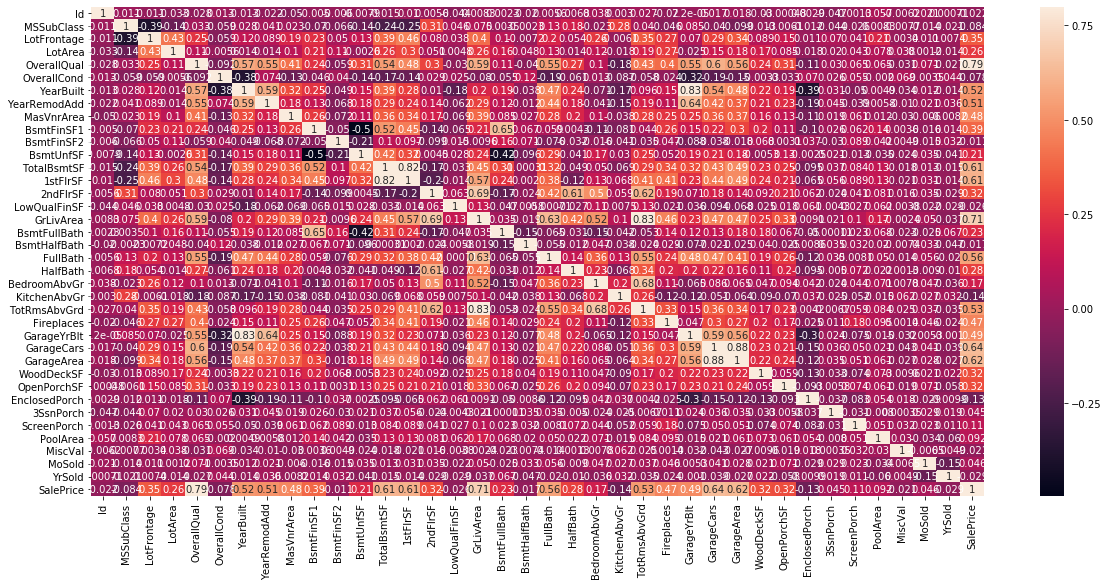

In [8]:
#correlation matrix
corrmat = train.corr()
f, ax = plt.subplots(figsize=(20, 9))
sns.heatmap(corrmat, vmax=.8, annot=True);

##### Listagem de atributos com graus de correlação maior do que 50% com o preço de venda

In [9]:
atributos_correlacao_preco_maior_50 = []
for id in corrmat.index:
    achouDiagonal = False
    if (id != "SalePrice") & (corrmat.loc[id]["SalePrice"] > 0.5):
        atributos_correlacao_preco_maior_50.append(id)
        print("Correlação de {} com SalePrice: {:1.3f}".format(id, corrmat.loc[id]["SalePrice"]))

Correlação de OverallQual com SalePrice: 0.791
Correlação de YearBuilt com SalePrice: 0.523
Correlação de YearRemodAdd com SalePrice: 0.507
Correlação de TotalBsmtSF com SalePrice: 0.614
Correlação de 1stFlrSF com SalePrice: 0.606
Correlação de GrLivArea com SalePrice: 0.709
Correlação de FullBath com SalePrice: 0.561
Correlação de TotRmsAbvGrd com SalePrice: 0.534
Correlação de GarageCars com SalePrice: 0.640
Correlação de GarageArea com SalePrice: 0.623


##### Listagem de atributos com graus de correlação entre 10% e 50% com o preço de venda

In [77]:
atributos_correlacao_preco_entre_10_e_50 = []
for id in corrmat.index:
    achouDiagonal = False
    if (id != "SalePrice") & (0.1 < corrmat.loc[id]["SalePrice"] <= 0.5):
        atributos_correlacao_preco_entre_10_e_50.append(id)
        print("Correlação de {} com SalePrice: {:1.3f}".format(id, corrmat.loc[id]["SalePrice"]))

Correlação de LotFrontage com SalePrice: 0.352
Correlação de LotArea com SalePrice: 0.264
Correlação de MasVnrArea com SalePrice: 0.477
Correlação de BsmtFinSF1 com SalePrice: 0.386
Correlação de BsmtUnfSF com SalePrice: 0.214
Correlação de 2ndFlrSF com SalePrice: 0.319
Correlação de BsmtFullBath com SalePrice: 0.227
Correlação de HalfBath com SalePrice: 0.284
Correlação de BedroomAbvGr com SalePrice: 0.168
Correlação de Fireplaces com SalePrice: 0.467
Correlação de GarageYrBlt com SalePrice: 0.486
Correlação de WoodDeckSF com SalePrice: 0.324
Correlação de OpenPorchSF com SalePrice: 0.316
Correlação de ScreenPorch com SalePrice: 0.111


##### Visualização gráfica dos 3 atributos com os maiores graus de correlação com o preço de venda.

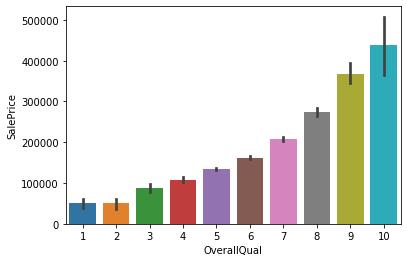

In [10]:
sns.barplot(train["OverallQual"],train.SalePrice)

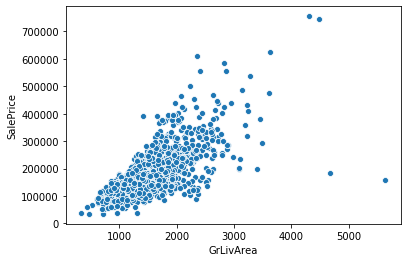

In [11]:
sns.scatterplot(train["GrLivArea"],train.SalePrice)

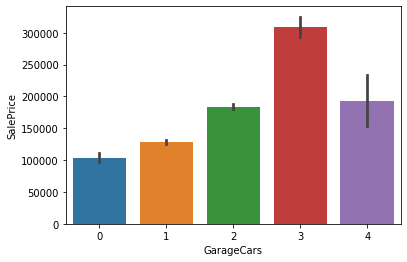

In [12]:
sns.barplot(train["GarageCars"],train.SalePrice)

Criação e exibição de um novo DataFrame apenas com os atributos que possuem correlação maior do que 50% com o preço de venda.

In [13]:
X_atributos_correlacao_preco_maior_50 = X_train_full[atributos_correlacao_preco_maior_50]

X_atributos_correlacao_preco_maior_50.head()

,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageCars,GarageArea
0,7,2003,2003,856,856,1710,2,8,2,548
1,6,1976,1976,1262,1262,1262,2,6,2,460
2,7,2001,2002,920,920,1786,2,6,2,608
3,7,1915,1970,756,961,1717,1,7,3,642
4,8,2000,2000,1145,1145,2198,2,9,3,836


##### Regressões com atributos que possuem correlação maior do que 50% com o preço de venda

Serão realizadas agora regressões com base nos atributos que possuem correlação maior do que 50% com o preço de venda. 

Não será realizado nenhum tipo de otimização.

Os melhores índices alcançados, se melhores do que os obtidos anteriormente com a média e a mediana, serão usados como benchmark para as futuras tentativas de melhorar os resultados.

*Preparação dos dados*

In [66]:
min_max_scaler = preprocessing.MinMaxScaler()
X_scale = min_max_scaler.fit_transform(X_atributos_correlacao_preco_maior_50)

X_train, X_test, Y_train, Y_test = train_test_split(X_scale, Y_train_full, test_size=0.3)

*Função genérica*

In [67]:
def regressao(model):
    reg = model.fit(X_train, Y_train.values)

    Y_predicted = reg.predict(X_test)

    df_Y_predicted = pd.Series(Y_predicted)

    df_Y_predicted = pd.DataFrame(Y_predicted)
    df_Y_predicted.columns = ["previsto"]
    df_Y_predicted[df_Y_predicted["previsto"] <= 0] = np.mean(Y_train_full)

    print("R2 Score: {:10.3f}".format(r2_score(Y_test.values, df_Y_predicted.round(0).values)))
    print("RMSLE:    {:10.3f}".format(rmsle(Y_test.values, df_Y_predicted.values)[0]))

*Linear Regression*

In [68]:
regressao(LinearRegression())

R2 Score:      0.759
RMSLE:         0.208


*Decision Tree*

In [69]:
regressao(DecisionTreeClassifier())

R2 Score:      0.659
RMSLE:         0.223


*LassoCV*

In [70]:
X, y = make_regression(noise=4, random_state=0)

regressao(LassoCV(cv=5, random_state=0))

R2 Score:      0.726
RMSLE:         0.209


*ElasticNet*

In [72]:
regressao(ElasticNet(random_state=0))

R2 Score:      0.258
RMSLE:         0.339


*Neural Network*

In [78]:
model = Sequential([
    Dense(10, activation='relu', input_shape=(10,)),
    Dense(16, activation='relu'),
    Dense(1, kernel_initializer='normal'),
])

model.compile(loss='mean_squared_error', optimizer='adam')

print(datetime.datetime.now())

hist = model.fit(X_train, Y_train,
          batch_size=32, epochs=15000,
          validation_data=(X_test, Y_test))

print(datetime.datetime.now())

2019-07-31 15:07:59.776303
Train on 1022 samples, validate on 438 samples
Epoch 1/15000
1022/1022 [==============================] - 1s 654us/step - loss: 38871402015.0607 - val_loss: 39430800790.7945
Epoch 2/15000
1022/1022 [==============================] - 0s 41us/step - loss: 38871300789.3542 - val_loss: 39430646685.8082
Epoch 3/15000
1022/1022 [==============================] - 0s 43us/step - loss: 38871073192.8297 - val_loss: 39430311056.9498
Epoch 4/15000
1022/1022 [==============================] - 0s 35us/step - loss: 38870598902.4814 - val_loss: 39429639247.4886
Epoch 5/15000
1022/1022 [==============================] - 0s 45us/step - loss: 38869680256.2505 - val_loss: 39428392660.7489
Epoch 6/15000
1022/1022 [==============================] - 0s 45us/step - loss: 38868083489.5656 - val_loss: 39426368011.6895
Epoch 7/15000
1022/1022 [==============================] - 0s 43us/step - loss: 38865606163.0372 - val_loss: 39423354851.9452
Epoch 8/15000
1022/1022 [==================

Epoch 65/15000
1022/1022 [==============================] - 0s 42us/step - loss: 32569371822.3405 - val_loss: 32960599119.4886
Epoch 66/15000
1022/1022 [==============================] - 0s 32us/step - loss: 32325053506.1292 - val_loss: 32716539277.4429
Epoch 67/15000
1022/1022 [==============================] - 0s 30us/step - loss: 32079051112.7045 - val_loss: 32463215386.8858
Epoch 68/15000
1022/1022 [==============================] - 0s 34us/step - loss: 31826577107.4129 - val_loss: 32208412989.9543
Epoch 69/15000
1022/1022 [==============================] - 0s 35us/step - loss: 31570087398.9511 - val_loss: 31950532832.4384
Epoch 70/15000
1022/1022 [==============================] - 0s 30us/step - loss: 31310613758.4971 - val_loss: 31687149717.6256
Epoch 71/15000
1022/1022 [==============================] - 0s 35us/step - loss: 31046931806.6849 - val_loss: 31419006817.0228
Epoch 72/15000
1022/1022 [==============================] - 0s 38us/step - loss: 30778390183.3268 - val_loss: 3

1022/1022 [==============================] - 0s 38us/step - loss: 12721037388.1487 - val_loss: 12990310633.7900
Epoch 130/15000
1022/1022 [==============================] - 0s 34us/step - loss: 12426644834.6928 - val_loss: 12695935745.1689
Epoch 131/15000
1022/1022 [==============================] - 0s 34us/step - loss: 12135116329.0802 - val_loss: 12406920540.3470
Epoch 132/15000
1022/1022 [==============================] - 0s 30us/step - loss: 11846663418.4892 - val_loss: 12124298934.3562
Epoch 133/15000
1022/1022 [==============================] - 0s 30us/step - loss: 11564412731.6164 - val_loss: 11838751888.9498
Epoch 134/15000
1022/1022 [==============================] - 0s 34us/step - loss: 11283001195.7104 - val_loss: 11561009965.5890
Epoch 135/15000
1022/1022 [==============================] - 0s 32us/step - loss: 11007311385.0489 - val_loss: 11283757719.9635
Epoch 136/15000
1022/1022 [==============================] - 0s 32us/step - loss: 10734844062.3092 - val_loss: 110102277

Epoch 194/15000
1022/1022 [==============================] - 0s 41us/step - loss: 2704437273.2994 - val_loss: 3130552878.1735
Epoch 195/15000
1022/1022 [==============================] - 0s 31us/step - loss: 2678374946.5675 - val_loss: 3108898218.0822
Epoch 196/15000
1022/1022 [==============================] - 0s 34us/step - loss: 2656061947.4912 - val_loss: 3085744654.0274
Epoch 197/15000
1022/1022 [==============================] - 0s 33us/step - loss: 2634585045.6673 - val_loss: 3065006174.6849
Epoch 198/15000
1022/1022 [==============================] - 0s 33us/step - loss: 2613736414.4344 - val_loss: 3048726647.8174
Epoch 199/15000
1022/1022 [==============================] - 0s 33us/step - loss: 2596618213.1977 - val_loss: 3030915509.1872
Epoch 200/15000
1022/1022 [==============================] - 0s 32us/step - loss: 2579117996.9628 - val_loss: 3016735352.4018
Epoch 201/15000
1022/1022 [==============================] - 0s 32us/step - loss: 2564433006.4658 - val_loss: 30022274

1022/1022 [==============================] - 0s 31us/step - loss: 2404661393.2838 - val_loss: 2857738009.1324
Epoch 260/15000
1022/1022 [==============================] - 0s 35us/step - loss: 2403792912.4070 - val_loss: 2856954818.6301
Epoch 261/15000
1022/1022 [==============================] - 0s 38us/step - loss: 2402771908.8845 - val_loss: 2855997832.7671
Epoch 262/15000
1022/1022 [==============================] - 0s 36us/step - loss: 2401874181.0098 - val_loss: 2855083466.2283
Epoch 263/15000
1022/1022 [==============================] - 0s 35us/step - loss: 2401098605.2133 - val_loss: 2854150700.4201
Epoch 264/15000
1022/1022 [==============================] - 0s 35us/step - loss: 2400528529.9100 - val_loss: 2853231343.6347
Epoch 265/15000
1022/1022 [==============================] - 0s 38us/step - loss: 2399575352.6106 - val_loss: 2852291595.1050
Epoch 266/15000
1022/1022 [==============================] - 0s 35us/step - loss: 2398677330.9119 - val_loss: 2851333373.0776
Epoch 26

1022/1022 [==============================] - 0s 32us/step - loss: 2343172554.3953 - val_loss: 2786732136.6210
Epoch 325/15000
1022/1022 [==============================] - 0s 32us/step - loss: 2341412005.3229 - val_loss: 2785492085.4795
Epoch 326/15000
1022/1022 [==============================] - 0s 33us/step - loss: 2340378395.0528 - val_loss: 2784322922.3744
Epoch 327/15000
1022/1022 [==============================] - 0s 32us/step - loss: 2339294370.5675 - val_loss: 2783049450.3744
Epoch 328/15000
1022/1022 [==============================] - 0s 33us/step - loss: 2338331776.2505 - val_loss: 2781768107.2511
Epoch 329/15000
1022/1022 [==============================] - 0s 31us/step - loss: 2337260277.7299 - val_loss: 2780528955.0320
Epoch 330/15000
1022/1022 [==============================] - 0s 36us/step - loss: 2336669211.3033 - val_loss: 2779340559.7808
Epoch 331/15000
1022/1022 [==============================] - 0s 37us/step - loss: 2335189131.7730 - val_loss: 2777996371.5799
Epoch 33

1022/1022 [==============================] - 0s 40us/step - loss: 2273125532.3053 - val_loss: 2705864332.8584
Epoch 390/15000
1022/1022 [==============================] - 0s 45us/step - loss: 2271730826.7710 - val_loss: 2704669323.1050
Epoch 391/15000
1022/1022 [==============================] - 0s 36us/step - loss: 2270799581.9335 - val_loss: 2703422221.4429
Epoch 392/15000
1022/1022 [==============================] - 0s 32us/step - loss: 2270116804.8845 - val_loss: 2702220636.3470
Epoch 393/15000
1022/1022 [==============================] - 0s 33us/step - loss: 2268899108.5714 - val_loss: 2701022818.7763
Epoch 394/15000
1022/1022 [==============================] - 0s 34us/step - loss: 2268128031.5616 - val_loss: 2699712066.6301
Epoch 395/15000
1022/1022 [==============================] - 0s 34us/step - loss: 2266764007.9530 - val_loss: 2698544685.0046
Epoch 396/15000
1022/1022 [==============================] - 0s 32us/step - loss: 2265611319.3581 - val_loss: 2697277612.4201
Epoch 39

1022/1022 [==============================] - 0s 37us/step - loss: 2205650908.4305 - val_loss: 2626688417.8995
Epoch 455/15000
1022/1022 [==============================] - 0s 34us/step - loss: 2204793401.3620 - val_loss: 2625512122.4475
Epoch 456/15000
1022/1022 [==============================] - 0s 33us/step - loss: 2204136141.9022 - val_loss: 2624289076.0183
Epoch 457/15000
1022/1022 [==============================] - 0s 34us/step - loss: 2202857722.4892 - val_loss: 2623210494.2466
Epoch 458/15000
1022/1022 [==============================] - 0s 34us/step - loss: 2203387734.4188 - val_loss: 2622074496.0000
Epoch 459/15000
1022/1022 [==============================] - 0s 34us/step - loss: 2200721597.1194 - val_loss: 2620848129.7534
Epoch 460/15000
1022/1022 [==============================] - 0s 34us/step - loss: 2199879123.9139 - val_loss: 2619725157.1142
Epoch 461/15000
1022/1022 [==============================] - 0s 36us/step - loss: 2198665890.8180 - val_loss: 2618552240.5114
Epoch 46

1022/1022 [==============================] - 0s 43us/step - loss: 2142083370.5832 - val_loss: 2550380567.9635
Epoch 520/15000
1022/1022 [==============================] - 0s 49us/step - loss: 2141506784.9393 - val_loss: 2549230047.8539
Epoch 521/15000
1022/1022 [==============================] - 0s 35us/step - loss: 2139936920.7984 - val_loss: 2548091552.7306
Epoch 522/15000
1022/1022 [==============================] - 0s 40us/step - loss: 2139183677.6204 - val_loss: 2546938721.0228
Epoch 523/15000
1022/1022 [==============================] - 0s 38us/step - loss: 2137943464.3288 - val_loss: 2545772391.4521
Epoch 524/15000
1022/1022 [==============================] - 0s 43us/step - loss: 2137528199.5147 - val_loss: 2544655348.8950
Epoch 525/15000
1022/1022 [==============================] - 0s 35us/step - loss: 2136274886.8885 - val_loss: 2543522248.4749
Epoch 526/15000
1022/1022 [==============================] - 0s 42us/step - loss: 2135032245.1037 - val_loss: 2542339593.9361
Epoch 52

1022/1022 [==============================] - 0s 32us/step - loss: 2080514020.4462 - val_loss: 2476026458.0091
Epoch 585/15000
1022/1022 [==============================] - 0s 42us/step - loss: 2079781358.2153 - val_loss: 2474926538.2283
Epoch 586/15000
1022/1022 [==============================] - 0s 29us/step - loss: 2078947561.9569 - val_loss: 2473775208.0365
Epoch 587/15000
1022/1022 [==============================] - 0s 29us/step - loss: 2077643569.0959 - val_loss: 2472691541.3333
Epoch 588/15000
1022/1022 [==============================] - 0s 35us/step - loss: 2077842429.2446 - val_loss: 2471617675.6895
Epoch 589/15000
1022/1022 [==============================] - 0s 32us/step - loss: 2076012402.7241 - val_loss: 2470550313.4977
Epoch 590/15000
1022/1022 [==============================] - 0s 32us/step - loss: 2075454133.3542 - val_loss: 2469396713.2055
Epoch 591/15000
1022/1022 [==============================] - 0s 30us/step - loss: 2074395947.5851 - val_loss: 2468364570.8858
Epoch 59

1022/1022 [==============================] - 0s 34us/step - loss: 2024152710.2622 - val_loss: 2406459979.9817
Epoch 650/15000
1022/1022 [==============================] - 0s 48us/step - loss: 2024139005.9961 - val_loss: 2405511806.2466
Epoch 651/15000
1022/1022 [==============================] - 0s 39us/step - loss: 2022839603.6008 - val_loss: 2404331249.9726
Epoch 652/15000
1022/1022 [==============================] - 0s 35us/step - loss: 2021784097.0646 - val_loss: 2403341744.5114
Epoch 653/15000
1022/1022 [==============================] - 0s 36us/step - loss: 2021002712.4227 - val_loss: 2402266909.8082
Epoch 654/15000
1022/1022 [==============================] - 0s 46us/step - loss: 2020262144.5010 - val_loss: 2401174462.5388
Epoch 655/15000
1022/1022 [==============================] - 0s 48us/step - loss: 2019146973.4325 - val_loss: 2400176730.5936
Epoch 656/15000
1022/1022 [==============================] - 0s 53us/step - loss: 2018404723.4755 - val_loss: 2399257069.8813
Epoch 65

1022/1022 [==============================] - 0s 37us/step - loss: 1971436313.9256 - val_loss: 2340020757.6256
Epoch 715/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1970629096.9550 - val_loss: 2338982212.9680
Epoch 716/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1969741416.7045 - val_loss: 2337962439.3059
Epoch 717/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1968939739.6791 - val_loss: 2336929232.0731
Epoch 718/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1968423753.3933 - val_loss: 2335843811.9452
Epoch 719/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1968067193.1115 - val_loss: 2334957466.8858
Epoch 720/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1966582208.1879 - val_loss: 2333958761.7900
Epoch 721/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1966053137.5342 - val_loss: 2332883171.3607
Epoch 72

1022/1022 [==============================] - 0s 39us/step - loss: 1922071224.1096 - val_loss: 2276512730.0091
Epoch 780/15000
1022/1022 [==============================] - 0s 41us/step - loss: 1921479024.7202 - val_loss: 2275330561.1689
Epoch 781/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1921012074.4579 - val_loss: 2274568277.9178
Epoch 782/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1919772019.2250 - val_loss: 2273462431.5616
Epoch 783/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1918818391.1703 - val_loss: 2272557456.9498
Epoch 784/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1918305693.8082 - val_loss: 2271656233.4977
Epoch 785/15000
1022/1022 [==============================] - 0s 44us/step - loss: 1918033751.4207 - val_loss: 2270456802.1918
Epoch 786/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1917237462.1683 - val_loss: 2269750478.3196
Epoch 78

1022/1022 [==============================] - 0s 37us/step - loss: 1876076958.3718 - val_loss: 2216123082.8128
Epoch 845/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1875850256.7828 - val_loss: 2215380536.9863
Epoch 846/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1874566598.3875 - val_loss: 2214339509.1872
Epoch 847/15000
1022/1022 [==============================] - 0s 46us/step - loss: 1874521276.3679 - val_loss: 2213353509.6986
Epoch 848/15000
1022/1022 [==============================] - 0s 36us/step - loss: 1873276931.0059 - val_loss: 2212426676.3105
Epoch 849/15000
1022/1022 [==============================] - 0s 43us/step - loss: 1872732038.0117 - val_loss: 2211640648.7671
Epoch 850/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1871806757.8239 - val_loss: 2210723438.7580
Epoch 851/15000
1022/1022 [==============================] - 0s 41us/step - loss: 1871603524.6341 - val_loss: 2210113853.9543
Epoch 85

1022/1022 [==============================] - 0s 33us/step - loss: 1833400617.2055 - val_loss: 2158984478.3927
Epoch 910/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1832648120.6106 - val_loss: 2158214645.1872
Epoch 911/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1832582605.9022 - val_loss: 2157083378.2648
Epoch 912/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1831795373.3386 - val_loss: 2156741127.0137
Epoch 913/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1830869748.9785 - val_loss: 2155662056.0365
Epoch 914/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1830231228.1174 - val_loss: 2154690279.7443
Epoch 915/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1829753521.0959 - val_loss: 2153980498.1187
Epoch 916/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1829757830.2622 - val_loss: 2152941068.5662
Epoch 91

1022/1022 [==============================] - 0s 37us/step - loss: 1794051599.0294 - val_loss: 2104565980.9315
Epoch 975/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1793276207.0920 - val_loss: 2103625713.6804
Epoch 976/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1793021462.7945 - val_loss: 2103069762.6301
Epoch 977/15000
1022/1022 [==============================] - 0s 37us/step - loss: 1792182221.1507 - val_loss: 2101976336.6575
Epoch 978/15000
1022/1022 [==============================] - 0s 37us/step - loss: 1791522669.9648 - val_loss: 2101414645.1872
Epoch 979/15000
1022/1022 [==============================] - 0s 39us/step - loss: 1791409292.5245 - val_loss: 2100297316.8219
Epoch 980/15000
1022/1022 [==============================] - 0s 42us/step - loss: 1791087956.2896 - val_loss: 2099879397.6986
Epoch 981/15000
1022/1022 [==============================] - 0s 40us/step - loss: 1790272540.6810 - val_loss: 2098605022.1005
Epoch 98

Epoch 1039/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1758650482.3483 - val_loss: 2054675188.8950
Epoch 1040/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1758274566.0117 - val_loss: 2054093314.0457
Epoch 1041/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1757551277.3386 - val_loss: 2052958525.3699
Epoch 1042/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1757162092.9628 - val_loss: 2052172547.5068
Epoch 1043/15000
1022/1022 [==============================] - 0s 37us/step - loss: 1757141451.3973 - val_loss: 2051994573.4429
Epoch 1044/15000
1022/1022 [==============================] - 0s 50us/step - loss: 1756324844.9628 - val_loss: 2050732191.8539
Epoch 1045/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1755873776.4697 - val_loss: 2050332371.8721
Epoch 1046/15000
1022/1022 [==============================] - 0s 36us/step - loss: 1755179941.9491 - val_loss: 

1022/1022 [==============================] - 0s 31us/step - loss: 1728182083.8826 - val_loss: 2009603248.2192
Epoch 1104/15000
1022/1022 [==============================] - 0s 37us/step - loss: 1727279722.9589 - val_loss: 2008778550.6484
Epoch 1105/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1726540259.9452 - val_loss: 2008076679.3059
Epoch 1106/15000
1022/1022 [==============================] - 0s 42us/step - loss: 1726169480.5166 - val_loss: 2007331151.7808
Epoch 1107/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1725720302.9667 - val_loss: 2006855702.5023
Epoch 1108/15000
1022/1022 [==============================] - 0s 38us/step - loss: 1725639770.6771 - val_loss: 2005806459.0320
Epoch 1109/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1724998102.4188 - val_loss: 2005470333.3699
Epoch 1110/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1725175065.5499 - val_loss: 2004686779.0320
E

1022/1022 [==============================] - 0s 32us/step - loss: 1699115350.7945 - val_loss: 1966868999.3059
Epoch 1168/15000
1022/1022 [==============================] - 0s 37us/step - loss: 1698632128.1252 - val_loss: 1966359341.5890
Epoch 1169/15000
1022/1022 [==============================] - 0s 36us/step - loss: 1698205865.2055 - val_loss: 1965668911.6347
Epoch 1170/15000
1022/1022 [==============================] - 0s 37us/step - loss: 1697875386.8650 - val_loss: 1964991923.7260
Epoch 1171/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1697568377.4873 - val_loss: 1964105687.0868
Epoch 1172/15000
1022/1022 [==============================] - 0s 37us/step - loss: 1697112008.8924 - val_loss: 1963370163.1416
Epoch 1173/15000
1022/1022 [==============================] - 0s 38us/step - loss: 1696536093.5577 - val_loss: 1962873090.6301
Epoch 1174/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1696281579.2094 - val_loss: 1961861653.3333
E

1022/1022 [==============================] - 0s 32us/step - loss: 1673365107.8513 - val_loss: 1926558760.6210
Epoch 1232/15000
1022/1022 [==============================] - 0s 43us/step - loss: 1673251931.4286 - val_loss: 1926413570.3379
Epoch 1233/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1672848123.4912 - val_loss: 1925185460.8950
Epoch 1234/15000
1022/1022 [==============================] - 0s 36us/step - loss: 1672355838.7476 - val_loss: 1924702681.1324
Epoch 1235/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1672153839.9687 - val_loss: 1924578819.7991
Epoch 1236/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1671648620.7123 - val_loss: 1923710461.6621
Epoch 1237/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1671239065.4247 - val_loss: 1923099797.3333
Epoch 1238/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1671077329.9100 - val_loss: 1922618699.9817
E

1022/1022 [==============================] - 0s 31us/step - loss: 1651019503.2172 - val_loss: 1890185590.9406
Epoch 1296/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1650793506.0665 - val_loss: 1889649887.8539
Epoch 1297/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1650860113.4090 - val_loss: 1889196031.7078
Epoch 1298/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1650033110.6693 - val_loss: 1889013763.5068
Epoch 1299/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1650075111.0763 - val_loss: 1888422141.9543
Epoch 1300/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1649894550.6693 - val_loss: 1887442896.3653
Epoch 1301/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1649077906.1605 - val_loss: 1887078319.0502
Epoch 1302/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1648795288.7984 - val_loss: 1887143016.3288
E

1022/1022 [==============================] - 0s 41us/step - loss: 1631465995.7730 - val_loss: 1857737751.0868
Epoch 1360/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1631096873.4560 - val_loss: 1856955984.6575
Epoch 1361/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1630606856.5166 - val_loss: 1856442606.4658
Epoch 1362/15000
1022/1022 [==============================] - 0s 39us/step - loss: 1630843085.4012 - val_loss: 1856328905.3516
Epoch 1363/15000
1022/1022 [==============================] - 0s 42us/step - loss: 1630020819.4129 - val_loss: 1855617182.3927
Epoch 1364/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1629884093.1194 - val_loss: 1854933932.4201
Epoch 1365/15000
1022/1022 [==============================] - 0s 51us/step - loss: 1630322154.7084 - val_loss: 1855040137.0594
Epoch 1366/15000
1022/1022 [==============================] - 0s 53us/step - loss: 1629272816.3444 - val_loss: 1853656446.5388
E

1022/1022 [==============================] - 0s 40us/step - loss: 1614182121.7065 - val_loss: 1827466423.2329
Epoch 1424/15000
1022/1022 [==============================] - 0s 41us/step - loss: 1613789805.0881 - val_loss: 1827502943.5616
Epoch 1425/15000
1022/1022 [==============================] - 0s 43us/step - loss: 1613304157.4325 - val_loss: 1826553115.7626
Epoch 1426/15000
1022/1022 [==============================] - 0s 50us/step - loss: 1613318132.9785 - val_loss: 1825745667.5068
Epoch 1427/15000
1022/1022 [==============================] - 0s 45us/step - loss: 1612702525.1194 - val_loss: 1825756978.8493
Epoch 1428/15000
1022/1022 [==============================] - 0s 40us/step - loss: 1613282709.5421 - val_loss: 1825864751.0502
Epoch 1429/15000
1022/1022 [==============================] - 0s 39us/step - loss: 1612246187.8356 - val_loss: 1825102151.5982
Epoch 1430/15000
1022/1022 [==============================] - 0s 42us/step - loss: 1612154943.3738 - val_loss: 1825227645.3699
E

1022/1022 [==============================] - 0s 39us/step - loss: 1598393072.7202 - val_loss: 1800763467.1050
Epoch 1488/15000
1022/1022 [==============================] - 0s 50us/step - loss: 1598492616.1409 - val_loss: 1800104084.7489
Epoch 1489/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1598366550.6693 - val_loss: 1800293036.1279
Epoch 1490/15000
1022/1022 [==============================] - 0s 40us/step - loss: 1597765309.6204 - val_loss: 1799704230.5753
Epoch 1491/15000
1022/1022 [==============================] - 0s 38us/step - loss: 1597677798.5753 - val_loss: 1799055466.6667
Epoch 1492/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1597930779.8043 - val_loss: 1799190096.9498
Epoch 1493/15000
1022/1022 [==============================] - 0s 46us/step - loss: 1597081498.5519 - val_loss: 1798635378.5571
Epoch 1494/15000
1022/1022 [==============================] - 0s 42us/step - loss: 1596928111.9687 - val_loss: 1798213122.3379
E

1022/1022 [==============================] - 0s 41us/step - loss: 1584896221.1820 - val_loss: 1776323229.2237
Epoch 1552/15000
1022/1022 [==============================] - 0s 40us/step - loss: 1585000098.5675 - val_loss: 1776469137.8265
Epoch 1553/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1584353703.5773 - val_loss: 1775445857.6073
Epoch 1554/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1583876924.7436 - val_loss: 1775406710.6484
Epoch 1555/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1583822466.7554 - val_loss: 1775087018.9589
Epoch 1556/15000
1022/1022 [==============================] - 0s 37us/step - loss: 1584098028.9628 - val_loss: 1774600871.4521
Epoch 1557/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1583412220.6184 - val_loss: 1773895146.9589
Epoch 1558/15000
1022/1022 [==============================] - 0s 36us/step - loss: 1583210680.6106 - val_loss: 1773650546.2648
E

1022/1022 [==============================] - 0s 43us/step - loss: 1572327727.4677 - val_loss: 1754078357.0411
Epoch 1616/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1572269516.7750 - val_loss: 1754379039.5616
Epoch 1617/15000
1022/1022 [==============================] - 0s 36us/step - loss: 1571984961.3777 - val_loss: 1754049715.1416
Epoch 1618/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1572129264.0939 - val_loss: 1753254981.5525
Epoch 1619/15000
1022/1022 [==============================] - 0s 37us/step - loss: 1571563186.9746 - val_loss: 1753286450.5571
Epoch 1620/15000
1022/1022 [==============================] - 0s 37us/step - loss: 1571688386.8806 - val_loss: 1752492196.8219
Epoch 1621/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1571050888.7671 - val_loss: 1752472126.2466
Epoch 1622/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1571120864.5010 - val_loss: 1752584374.6484
E

1022/1022 [==============================] - 0s 30us/step - loss: 1561802636.0235 - val_loss: 1734172740.6758
Epoch 1680/15000
1022/1022 [==============================] - 0s 42us/step - loss: 1561188575.9374 - val_loss: 1733943530.9589
Epoch 1681/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1561063482.6145 - val_loss: 1734681412.3836
Epoch 1682/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1560780110.0274 - val_loss: 1734404638.3927
Epoch 1683/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1560443324.3679 - val_loss: 1733919018.9589
Epoch 1684/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1560652230.8885 - val_loss: 1733591199.2694
Epoch 1685/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1560496162.8180 - val_loss: 1732816153.1324
Epoch 1686/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1560244836.6967 - val_loss: 1732406889.2055
E

1022/1022 [==============================] - 0s 40us/step - loss: 1551417529.3620 - val_loss: 1716893549.5890
Epoch 1744/15000
1022/1022 [==============================] - 0s 36us/step - loss: 1551109032.3288 - val_loss: 1716612878.0274
Epoch 1745/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1551119339.7104 - val_loss: 1715869867.5434
Epoch 1746/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1550888526.0274 - val_loss: 1715453966.3196
Epoch 1747/15000
1022/1022 [==============================] - 0s 41us/step - loss: 1550743878.8885 - val_loss: 1715988165.2603
Epoch 1748/15000
1022/1022 [==============================] - 0s 38us/step - loss: 1550527901.4325 - val_loss: 1715321358.9041
Epoch 1749/15000
1022/1022 [==============================] - 0s 36us/step - loss: 1550383268.1957 - val_loss: 1715280277.9178
Epoch 1750/15000
1022/1022 [==============================] - 0s 38us/step - loss: 1550190050.4423 - val_loss: 1715018299.3242
E

1022/1022 [==============================] - 0s 40us/step - loss: 1542439119.6556 - val_loss: 1700705463.2329
Epoch 1808/15000
1022/1022 [==============================] - 0s 40us/step - loss: 1542306786.1918 - val_loss: 1700246481.2420
Epoch 1809/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1541935870.3718 - val_loss: 1700303357.9543
Epoch 1810/15000
1022/1022 [==============================] - 0s 45us/step - loss: 1541797264.7828 - val_loss: 1699883327.1233
Epoch 1811/15000
1022/1022 [==============================] - 0s 37us/step - loss: 1541819123.6008 - val_loss: 1699985451.2511
Epoch 1812/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1542178515.6634 - val_loss: 1699387159.0868
Epoch 1813/15000
1022/1022 [==============================] - 0s 37us/step - loss: 1541931806.9354 - val_loss: 1699295630.6119
Epoch 1814/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1541880335.7808 - val_loss: 1698488637.9543
E

1022/1022 [==============================] - 0s 37us/step - loss: 1534436542.9980 - val_loss: 1685932302.6119
Epoch 1872/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1533661919.5616 - val_loss: 1686267235.3607
Epoch 1873/15000
1022/1022 [==============================] - 0s 36us/step - loss: 1534098190.7162 - val_loss: 1685835230.1005
Epoch 1874/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1533966345.3933 - val_loss: 1685615694.3196
Epoch 1875/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1534146592.9393 - val_loss: 1684756282.1553
Epoch 1876/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1533437451.6477 - val_loss: 1685583866.7397
Epoch 1877/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1533318644.4775 - val_loss: 1685070395.6164
Epoch 1878/15000
1022/1022 [==============================] - 0s 39us/step - loss: 1533088832.1252 - val_loss: 1684594986.6667
E

1022/1022 [==============================] - 0s 40us/step - loss: 1526381764.4462 - val_loss: 1673142011.6164
Epoch 1936/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1526191687.6399 - val_loss: 1673289681.2420
Epoch 1937/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1526481822.3092 - val_loss: 1671816005.5525
Epoch 1938/15000
1022/1022 [==============================] - 0s 37us/step - loss: 1526079174.7632 - val_loss: 1672650312.7671
Epoch 1939/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1525637809.0959 - val_loss: 1672185421.4429
Epoch 1940/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1526398119.8278 - val_loss: 1671546427.3242
Epoch 1941/15000
1022/1022 [==============================] - 0s 40us/step - loss: 1525608290.4423 - val_loss: 1671413928.0365
Epoch 1942/15000
1022/1022 [==============================] - 0s 38us/step - loss: 1525611698.5988 - val_loss: 1671700196.2374
E

1022/1022 [==============================] - 0s 41us/step - loss: 1519143339.0841 - val_loss: 1659799973.4064
Epoch 2000/15000
1022/1022 [==============================] - 0s 41us/step - loss: 1519006010.1135 - val_loss: 1659998615.3790
Epoch 2001/15000
1022/1022 [==============================] - 0s 37us/step - loss: 1518810173.6204 - val_loss: 1659504168.3288
Epoch 2002/15000
1022/1022 [==============================] - 0s 37us/step - loss: 1518933607.0763 - val_loss: 1660209003.8356
Epoch 2003/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1518609031.7025 - val_loss: 1659994770.1187
Epoch 2004/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1518882114.1292 - val_loss: 1659608651.6895
Epoch 2005/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1518794831.2798 - val_loss: 1658952410.0091
Epoch 2006/15000
1022/1022 [==============================] - 0s 40us/step - loss: 1518127312.1566 - val_loss: 1659125202.9954
E

1022/1022 [==============================] - 0s 32us/step - loss: 1512257984.5010 - val_loss: 1649396407.8174
Epoch 2064/15000
1022/1022 [==============================] - 0s 36us/step - loss: 1512456545.2524 - val_loss: 1649628065.0228
Epoch 2065/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1512012712.3288 - val_loss: 1649007434.2283
Epoch 2066/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1512035190.2309 - val_loss: 1648323396.0913
Epoch 2067/15000
1022/1022 [==============================] - 0s 39us/step - loss: 1512450945.7534 - val_loss: 1648519471.9269
Epoch 2068/15000
1022/1022 [==============================] - 0s 41us/step - loss: 1511804183.3581 - val_loss: 1648686904.1096
Epoch 2069/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1512205088.3131 - val_loss: 1648166290.1187
Epoch 2070/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1512116798.3718 - val_loss: 1648846515.4338
E

1022/1022 [==============================] - 0s 29us/step - loss: 1506195688.9550 - val_loss: 1639293170.8493
Epoch 2128/15000
1022/1022 [==============================] - 0s 41us/step - loss: 1506165812.1018 - val_loss: 1639558860.8584
Epoch 2129/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1506470598.2622 - val_loss: 1638908599.2329
Epoch 2130/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1505814258.9746 - val_loss: 1638396763.7626
Epoch 2131/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1506119128.9237 - val_loss: 1638783429.2603
Epoch 2132/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1506008424.5793 - val_loss: 1638008344.8402
Epoch 2133/15000
1022/1022 [==============================] - 0s 38us/step - loss: 1506083826.0978 - val_loss: 1637532788.3105
Epoch 2134/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1505559915.9609 - val_loss: 1638053336.2557
E

1022/1022 [==============================] - 0s 29us/step - loss: 1500254614.9198 - val_loss: 1629938392.5479
Epoch 2192/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1500176400.5323 - val_loss: 1629867657.9361
Epoch 2193/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1500554833.5342 - val_loss: 1629256978.4110
Epoch 2194/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1500381702.1996 - val_loss: 1628925868.7123
Epoch 2195/15000
1022/1022 [==============================] - 0s 40us/step - loss: 1500363215.9061 - val_loss: 1630033438.1005
Epoch 2196/15000
1022/1022 [==============================] - 0s 39us/step - loss: 1500062626.5675 - val_loss: 1629091343.4886
Epoch 2197/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1499833378.3170 - val_loss: 1629028694.5023
Epoch 2198/15000
1022/1022 [==============================] - 0s 44us/step - loss: 1499579607.0450 - val_loss: 1628522735.3425
E

1022/1022 [==============================] - 0s 32us/step - loss: 1494637891.1311 - val_loss: 1620959984.5114
Epoch 2256/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1494613396.1644 - val_loss: 1620409885.5160
Epoch 2257/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1494539484.6810 - val_loss: 1620168114.8493
Epoch 2258/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1494456768.3757 - val_loss: 1620479634.1187
Epoch 2259/15000
1022/1022 [==============================] - 0s 40us/step - loss: 1494460574.5597 - val_loss: 1620523593.6438
Epoch 2260/15000
1022/1022 [==============================] - 0s 41us/step - loss: 1494942931.6634 - val_loss: 1619347922.1187
Epoch 2261/15000
1022/1022 [==============================] - 0s 39us/step - loss: 1494327624.6419 - val_loss: 1619357596.3470
Epoch 2262/15000
1022/1022 [==============================] - 0s 39us/step - loss: 1494890186.7710 - val_loss: 1619993507.6530
E

1022/1022 [==============================] - 0s 34us/step - loss: 1489483820.5871 - val_loss: 1612618645.3333
Epoch 2320/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1489899502.9667 - val_loss: 1613111751.0137
Epoch 2321/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1489638642.9746 - val_loss: 1611634173.9543
Epoch 2322/15000
1022/1022 [==============================] - 0s 38us/step - loss: 1489233445.1977 - val_loss: 1611942417.5342
Epoch 2323/15000
1022/1022 [==============================] - 0s 37us/step - loss: 1489631063.6712 - val_loss: 1612594722.1918
Epoch 2324/15000
1022/1022 [==============================] - 0s 36us/step - loss: 1489130586.9276 - val_loss: 1611591188.1644
Epoch 2325/15000
1022/1022 [==============================] - 0s 43us/step - loss: 1489009087.2485 - val_loss: 1611520599.9635
Epoch 2326/15000
1022/1022 [==============================] - 0s 37us/step - loss: 1488913884.6810 - val_loss: 1612164181.3333
E

1022/1022 [==============================] - 0s 40us/step - loss: 1484881443.3190 - val_loss: 1604768420.8219
Epoch 2384/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1484987709.1194 - val_loss: 1605345190.2831
Epoch 2385/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1485177274.2387 - val_loss: 1605443443.1416
Epoch 2386/15000
1022/1022 [==============================] - 0s 36us/step - loss: 1484549611.9609 - val_loss: 1604255122.7032
Epoch 2387/15000
1022/1022 [==============================] - 0s 38us/step - loss: 1484641647.3425 - val_loss: 1604227851.3973
Epoch 2388/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1485025849.9883 - val_loss: 1603882801.0959
Epoch 2389/15000
1022/1022 [==============================] - 0s 37us/step - loss: 1484364933.2603 - val_loss: 1604975495.5982
Epoch 2390/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1484617895.3268 - val_loss: 1605646242.7763
E

1022/1022 [==============================] - 0s 33us/step - loss: 1480254118.3249 - val_loss: 1598971837.6621
Epoch 2448/15000
1022/1022 [==============================] - 0s 42us/step - loss: 1480193663.3738 - val_loss: 1598062475.1050
Epoch 2449/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1479920872.4540 - val_loss: 1598314574.3196
Epoch 2450/15000
1022/1022 [==============================] - 0s 44us/step - loss: 1480169449.8317 - val_loss: 1598142932.1644
Epoch 2451/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1480043328.3757 - val_loss: 1598366594.3379
Epoch 2452/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1479753551.2798 - val_loss: 1598069878.3562
Epoch 2453/15000
1022/1022 [==============================] - 0s 40us/step - loss: 1480201616.0313 - val_loss: 1598789659.7626
Epoch 2454/15000
1022/1022 [==============================] - 0s 41us/step - loss: 1479934107.3033 - val_loss: 1597203291.7626
E

1022/1022 [==============================] - 0s 42us/step - loss: 1476224568.1096 - val_loss: 1592930088.6210
Epoch 2512/15000
1022/1022 [==============================] - 0s 40us/step - loss: 1475898928.3444 - val_loss: 1591794828.5662
Epoch 2513/15000
1022/1022 [==============================] - 0s 37us/step - loss: 1475675242.3953 - val_loss: 1591758952.3288
Epoch 2514/15000
1022/1022 [==============================] - 0s 38us/step - loss: 1475946128.1566 - val_loss: 1592535932.2009
Epoch 2515/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1475848553.8317 - val_loss: 1591444883.2877
Epoch 2516/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1475290394.6145 - val_loss: 1591903562.8128
Epoch 2517/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1475331507.3503 - val_loss: 1592139218.1187
Epoch 2518/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1475631189.4168 - val_loss: 1592511168.5845
E

1022/1022 [==============================] - 0s 33us/step - loss: 1472655557.3855 - val_loss: 1587732268.4201
Epoch 2576/15000
1022/1022 [==============================] - 0s 37us/step - loss: 1471655172.5088 - val_loss: 1586793851.9087
Epoch 2577/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1471993149.7456 - val_loss: 1585594635.3973
Epoch 2578/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1471709598.0587 - val_loss: 1585600511.1233
Epoch 2579/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1471724815.0294 - val_loss: 1586727001.7169
Epoch 2580/15000
1022/1022 [==============================] - 0s 41us/step - loss: 1471848213.2916 - val_loss: 1586425854.8311
Epoch 2581/15000
1022/1022 [==============================] - 0s 40us/step - loss: 1471577122.5675 - val_loss: 1586526885.9909
Epoch 2582/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1471849915.1155 - val_loss: 1585538329.1324
E

1022/1022 [==============================] - 0s 41us/step - loss: 1468025748.7906 - val_loss: 1581141170.8493
Epoch 2640/15000
1022/1022 [==============================] - 0s 36us/step - loss: 1469480312.1096 - val_loss: 1582304222.6849
Epoch 2641/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1469110308.4462 - val_loss: 1579933830.4292
Epoch 2642/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1469030234.0509 - val_loss: 1581513736.7671
Epoch 2643/15000
1022/1022 [==============================] - 0s 39us/step - loss: 1467896388.3836 - val_loss: 1581476826.0091
Epoch 2644/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1468082184.0157 - val_loss: 1580373922.4840
Epoch 2645/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1467647540.7906 - val_loss: 1580556498.4110
Epoch 2646/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1467547952.5949 - val_loss: 1580319635.2877
E

1022/1022 [==============================] - 0s 47us/step - loss: 1464551140.5714 - val_loss: 1576329467.6164
Epoch 2704/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1465060578.8180 - val_loss: 1577185673.9361
Epoch 2705/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1464755380.1018 - val_loss: 1575879343.6347
Epoch 2706/15000
1022/1022 [==============================] - 0s 38us/step - loss: 1464334667.6477 - val_loss: 1576379935.8539
Epoch 2707/15000
1022/1022 [==============================] - 0s 39us/step - loss: 1464318499.8200 - val_loss: 1576734122.3744
Epoch 2708/15000
1022/1022 [==============================] - 0s 36us/step - loss: 1464526384.5949 - val_loss: 1575666394.5936
Epoch 2709/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1464610088.3288 - val_loss: 1576870864.0731
Epoch 2710/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1464017963.8356 - val_loss: 1576243259.9087
E

1022/1022 [==============================] - 0s 44us/step - loss: 1462196193.9413 - val_loss: 1573416114.2648
Epoch 2768/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1461349670.8258 - val_loss: 1572444898.7763
Epoch 2769/15000
1022/1022 [==============================] - 0s 39us/step - loss: 1461416674.3170 - val_loss: 1571475887.3425
Epoch 2770/15000
1022/1022 [==============================] - 0s 36us/step - loss: 1460977170.5362 - val_loss: 1571568872.3288
Epoch 2771/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1461269536.0626 - val_loss: 1572486049.8995
Epoch 2772/15000
1022/1022 [==============================] - 0s 38us/step - loss: 1461025178.1761 - val_loss: 1571554379.6895
Epoch 2773/15000
1022/1022 [==============================] - 0s 38us/step - loss: 1460770927.4677 - val_loss: 1572007851.8356
Epoch 2774/15000
1022/1022 [==============================] - 0s 36us/step - loss: 1461206629.1977 - val_loss: 1571325853.8082
E

1022/1022 [==============================] - 0s 36us/step - loss: 1457980297.6438 - val_loss: 1568732273.3881
Epoch 2832/15000
1022/1022 [==============================] - 0s 36us/step - loss: 1458116126.3092 - val_loss: 1568302052.8219
Epoch 2833/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1458356312.6732 - val_loss: 1567379849.6438
Epoch 2834/15000
1022/1022 [==============================] - 0s 36us/step - loss: 1458263567.1546 - val_loss: 1568244924.4932
Epoch 2835/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1458033587.0998 - val_loss: 1568215326.6849
Epoch 2836/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1457785713.9726 - val_loss: 1567797875.1416
Epoch 2837/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1458474209.1898 - val_loss: 1566993642.6667
Epoch 2838/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1457757868.4618 - val_loss: 1568152787.2877
E

1022/1022 [==============================] - 0s 39us/step - loss: 1455265241.4247 - val_loss: 1563716150.3562
Epoch 2896/15000
1022/1022 [==============================] - 0s 42us/step - loss: 1454849792.6262 - val_loss: 1564236084.8950
Epoch 2897/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1454882942.9980 - val_loss: 1564300714.0822
Epoch 2898/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1454902237.9335 - val_loss: 1564101649.2420
Epoch 2899/15000
1022/1022 [==============================] - 0s 37us/step - loss: 1454729687.9217 - val_loss: 1564529564.3470
Epoch 2900/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1454750244.5088 - val_loss: 1564605819.3242
Epoch 2901/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1455000140.9628 - val_loss: 1563529820.3470
Epoch 2902/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1454882297.2368 - val_loss: 1564659884.4201
E

1022/1022 [==============================] - 0s 31us/step - loss: 1452072917.4168 - val_loss: 1560400738.4840
Epoch 2960/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1452529558.2935 - val_loss: 1561415784.0365
Epoch 2961/15000
1022/1022 [==============================] - 0s 37us/step - loss: 1452053836.2740 - val_loss: 1560298538.3744
Epoch 2962/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1451983540.6027 - val_loss: 1560822087.8904
Epoch 2963/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1452034533.1977 - val_loss: 1560944593.8265
Epoch 2964/15000
1022/1022 [==============================] - 0s 37us/step - loss: 1451974097.9100 - val_loss: 1560773439.4155
Epoch 2965/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1451989031.9530 - val_loss: 1560087223.2329
Epoch 2966/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1452041159.8904 - val_loss: 1560953821.8082
E

1022/1022 [==============================] - 0s 34us/step - loss: 1449589548.5871 - val_loss: 1556110924.8584
Epoch 3024/15000
1022/1022 [==============================] - 0s 41us/step - loss: 1449942631.4521 - val_loss: 1556247435.1050
Epoch 3025/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1449670633.4560 - val_loss: 1557245020.3470
Epoch 3026/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1449167362.2544 - val_loss: 1557198536.1826
Epoch 3027/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1449766624.4384 - val_loss: 1556479861.1872
Epoch 3028/15000
1022/1022 [==============================] - 0s 38us/step - loss: 1449162031.2172 - val_loss: 1557248954.1553
Epoch 3029/15000
1022/1022 [==============================] - 0s 36us/step - loss: 1449308984.8611 - val_loss: 1556836621.7352
Epoch 3030/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1449097986.7554 - val_loss: 1556907460.6758
E

1022/1022 [==============================] - 0s 33us/step - loss: 1446859994.3014 - val_loss: 1553445631.1233
Epoch 3088/15000
1022/1022 [==============================] - 0s 38us/step - loss: 1447058483.3503 - val_loss: 1554546917.9909
Epoch 3089/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1446708475.3659 - val_loss: 1553779012.0913
Epoch 3090/15000
1022/1022 [==============================] - 0s 41us/step - loss: 1446802977.3151 - val_loss: 1553443083.3973
Epoch 3091/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1446734378.7710 - val_loss: 1554091923.2877
Epoch 3092/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1446993531.2407 - val_loss: 1553536898.3379
Epoch 3093/15000
1022/1022 [==============================] - 0s 38us/step - loss: 1446685333.0411 - val_loss: 1553775825.8265
Epoch 3094/15000
1022/1022 [==============================] - 0s 39us/step - loss: 1446838333.3699 - val_loss: 1552661147.7626
E

1022/1022 [==============================] - 0s 32us/step - loss: 1445223181.0254 - val_loss: 1549852471.2329
Epoch 3152/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1444477892.3836 - val_loss: 1551389809.3881
Epoch 3153/15000
1022/1022 [==============================] - 0s 36us/step - loss: 1444284785.9726 - val_loss: 1551528077.4429
Epoch 3154/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1444527752.7671 - val_loss: 1550649845.1872
Epoch 3155/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1444167993.2368 - val_loss: 1550416161.6073
Epoch 3156/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1444502467.8826 - val_loss: 1551754432.5845
Epoch 3157/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1444918164.7906 - val_loss: 1550628163.5068
Epoch 3158/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1444262590.8728 - val_loss: 1551086315.8356
E

1022/1022 [==============================] - 0s 31us/step - loss: 1442388037.1350 - val_loss: 1547589641.3516
Epoch 3216/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1442166296.4227 - val_loss: 1547796358.4292
Epoch 3217/15000
1022/1022 [==============================] - 0s 36us/step - loss: 1441941400.9237 - val_loss: 1548591348.0183
Epoch 3218/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1442121945.4247 - val_loss: 1547755229.5160
Epoch 3219/15000
1022/1022 [==============================] - 0s 38us/step - loss: 1441918865.5342 - val_loss: 1548150148.3836
Epoch 3220/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1441789573.0098 - val_loss: 1548088861.2237
Epoch 3221/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1441994906.0509 - val_loss: 1548295234.6301
Epoch 3222/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1441834846.1840 - val_loss: 1547570434.3379
E

1022/1022 [==============================] - 0s 35us/step - loss: 1439886044.9941 - val_loss: 1545788784.2192
Epoch 3280/15000
1022/1022 [==============================] - 0s 39us/step - loss: 1439802234.1135 - val_loss: 1545438395.3242
Epoch 3281/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1439929405.8708 - val_loss: 1545328061.0776
Epoch 3282/15000
1022/1022 [==============================] - 0s 38us/step - loss: 1440078712.7358 - val_loss: 1546088998.5753
Epoch 3283/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1439635416.5479 - val_loss: 1545684249.1324
Epoch 3284/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1440102534.8885 - val_loss: 1545318634.9589
Epoch 3285/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1439791514.3014 - val_loss: 1546194199.3790
Epoch 3286/15000
1022/1022 [==============================] - 0s 36us/step - loss: 1439858947.7573 - val_loss: 1545448989.8082
E

1022/1022 [==============================] - 0s 32us/step - loss: 1437884317.9335 - val_loss: 1542843440.2192
Epoch 3344/15000
1022/1022 [==============================] - 0s 36us/step - loss: 1438423255.1703 - val_loss: 1542590860.2740
Epoch 3345/15000
1022/1022 [==============================] - 0s 43us/step - loss: 1438824760.2348 - val_loss: 1544910025.9361
Epoch 3346/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1437749862.7006 - val_loss: 1544357807.0502
Epoch 3347/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1438190202.9902 - val_loss: 1542519617.4612
Epoch 3348/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1438505346.0039 - val_loss: 1543211705.8630
Epoch 3349/15000
1022/1022 [==============================] - 0s 37us/step - loss: 1437709195.7730 - val_loss: 1543538043.9087
Epoch 3350/15000
1022/1022 [==============================] - 0s 38us/step - loss: 1437968289.8160 - val_loss: 1542250636.2740
E

1022/1022 [==============================] - 0s 41us/step - loss: 1436131690.7084 - val_loss: 1541809595.0320
Epoch 3408/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1436149708.1487 - val_loss: 1541157108.0183
Epoch 3409/15000
1022/1022 [==============================] - 0s 39us/step - loss: 1435824505.9883 - val_loss: 1541292667.6164
Epoch 3410/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1435790867.1624 - val_loss: 1541745490.7032
Epoch 3411/15000
1022/1022 [==============================] - 0s 37us/step - loss: 1435839470.7162 - val_loss: 1541481607.8904
Epoch 3412/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1436014705.9726 - val_loss: 1541255321.7169
Epoch 3413/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1435907780.3836 - val_loss: 1541487685.8447
Epoch 3414/15000
1022/1022 [==============================] - 0s 42us/step - loss: 1435712927.5616 - val_loss: 1541689854.5388
E

1022/1022 [==============================] - 0s 41us/step - loss: 1434989318.0117 - val_loss: 1540391632.0731
Epoch 3472/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1434246324.8532 - val_loss: 1539235695.6347
Epoch 3473/15000
1022/1022 [==============================] - 0s 40us/step - loss: 1434433071.5930 - val_loss: 1539093475.9452
Epoch 3474/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1434378526.6849 - val_loss: 1539046017.1689
Epoch 3475/15000
1022/1022 [==============================] - 0s 43us/step - loss: 1433781769.2055 - val_loss: 1539770986.6667
Epoch 3476/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1433969736.6419 - val_loss: 1540135029.1872
Epoch 3477/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1434023557.5108 - val_loss: 1539591307.1050
Epoch 3478/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1434159667.9765 - val_loss: 1539872347.1781
E

1022/1022 [==============================] - 0s 33us/step - loss: 1433008566.6067 - val_loss: 1538344750.4658
Epoch 3536/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1432643421.6830 - val_loss: 1538630356.1644
Epoch 3537/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1432581094.7006 - val_loss: 1538651622.8676
Epoch 3538/15000
1022/1022 [==============================] - 0s 38us/step - loss: 1432392072.2661 - val_loss: 1538761138.5571
Epoch 3539/15000
1022/1022 [==============================] - 0s 36us/step - loss: 1432451757.5890 - val_loss: 1537535173.2603
Epoch 3540/15000
1022/1022 [==============================] - 0s 47us/step - loss: 1432186789.6986 - val_loss: 1537847553.7534
Epoch 3541/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1432430909.2446 - val_loss: 1538630889.4977
Epoch 3542/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1432488727.0450 - val_loss: 1538241689.7169
E

1022/1022 [==============================] - 0s 33us/step - loss: 1430713726.7476 - val_loss: 1536325946.1553
Epoch 3600/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1431084243.4129 - val_loss: 1537058371.2146
Epoch 3601/15000
1022/1022 [==============================] - 0s 36us/step - loss: 1431328962.6301 - val_loss: 1535738188.5662
Epoch 3602/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1430670456.1096 - val_loss: 1536244227.2146
Epoch 3603/15000
1022/1022 [==============================] - 0s 36us/step - loss: 1431117760.3757 - val_loss: 1537676829.2237
Epoch 3604/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1431533377.3777 - val_loss: 1536231530.6667
Epoch 3605/15000
1022/1022 [==============================] - 0s 37us/step - loss: 1430536458.2701 - val_loss: 1536645866.6667
Epoch 3606/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1430639546.8650 - val_loss: 1536823450.5936
E

1022/1022 [==============================] - 0s 45us/step - loss: 1429096324.7593 - val_loss: 1535727551.4155
Epoch 3664/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1429394263.9217 - val_loss: 1535612820.4566
Epoch 3665/15000
1022/1022 [==============================] - 0s 36us/step - loss: 1429373295.0920 - val_loss: 1535009208.4018
Epoch 3666/15000
1022/1022 [==============================] - 0s 38us/step - loss: 1429157085.9335 - val_loss: 1534786607.3425
Epoch 3667/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1429051325.9961 - val_loss: 1535395933.8082
Epoch 3668/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1429238520.2348 - val_loss: 1535134050.4840
Epoch 3669/15000
1022/1022 [==============================] - 0s 44us/step - loss: 1429125982.3092 - val_loss: 1534538788.2374
Epoch 3670/15000
1022/1022 [==============================] - 0s 37us/step - loss: 1429071709.9335 - val_loss: 1535378722.4840
E

1022/1022 [==============================] - 0s 31us/step - loss: 1427881689.9256 - val_loss: 1534620541.3699
Epoch 3728/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1427674766.9041 - val_loss: 1534202715.7626
Epoch 3729/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1428022598.8885 - val_loss: 1534668261.9909
Epoch 3730/15000
1022/1022 [==============================] - 0s 37us/step - loss: 1427765186.0039 - val_loss: 1533606314.6667
Epoch 3731/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1427662776.1096 - val_loss: 1533960225.3151
Epoch 3732/15000
1022/1022 [==============================] - 0s 37us/step - loss: 1427750976.0000 - val_loss: 1534539194.7397
Epoch 3733/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1428141144.5479 - val_loss: 1534133359.0502
Epoch 3734/15000
1022/1022 [==============================] - 0s 40us/step - loss: 1427502784.5010 - val_loss: 1533845887.4155
E

1022/1022 [==============================] - 0s 33us/step - loss: 1426906135.1703 - val_loss: 1533196531.4338
Epoch 3792/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1426497195.0841 - val_loss: 1532725309.9543
Epoch 3793/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1426649812.5401 - val_loss: 1532766087.8904
Epoch 3794/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1426483196.4932 - val_loss: 1533240524.8584
Epoch 3795/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1427566158.2779 - val_loss: 1531406522.4475
Epoch 3796/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1425944690.8493 - val_loss: 1533341962.5205
Epoch 3797/15000
1022/1022 [==============================] - 0s 38us/step - loss: 1426710869.7926 - val_loss: 1534144835.5068
Epoch 3798/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1425938372.3836 - val_loss: 1533103712.7306
E

1022/1022 [==============================] - 0s 32us/step - loss: 1424868152.8611 - val_loss: 1531617682.9954
Epoch 3856/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1425324265.9569 - val_loss: 1531606762.6667
Epoch 3857/15000
1022/1022 [==============================] - 0s 41us/step - loss: 1424977575.8278 - val_loss: 1531452448.1461
Epoch 3858/15000
1022/1022 [==============================] - 0s 46us/step - loss: 1424757934.0900 - val_loss: 1532329391.0502
Epoch 3859/15000
1022/1022 [==============================] - 0s 37us/step - loss: 1424943235.8826 - val_loss: 1531373624.6941
Epoch 3860/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1425338069.7926 - val_loss: 1532366945.3151
Epoch 3861/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1424779241.4560 - val_loss: 1532348668.7854
Epoch 3862/15000
1022/1022 [==============================] - 0s 37us/step - loss: 1424804386.7554 - val_loss: 1531367822.6119
E

1022/1022 [==============================] - 0s 38us/step - loss: 1424160299.2720 - val_loss: 1530195870.3927
Epoch 3920/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1424204978.5988 - val_loss: 1532136900.6758
Epoch 3921/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1423416036.5714 - val_loss: 1531244305.2420
Epoch 3922/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1423410043.2407 - val_loss: 1531205897.3516
Epoch 3923/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1423699802.4266 - val_loss: 1531091034.0091
Epoch 3924/15000
1022/1022 [==============================] - 0s 36us/step - loss: 1423798335.1233 - val_loss: 1530954131.5799
Epoch 3925/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1423440348.4305 - val_loss: 1530254293.6256
Epoch 3926/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1423741307.7417 - val_loss: 1529649423.1963
E

1022/1022 [==============================] - 0s 30us/step - loss: 1422273689.7378 - val_loss: 1530695183.7808
Epoch 3984/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1422271314.4110 - val_loss: 1530478684.0548
Epoch 3985/15000
1022/1022 [==============================] - 0s 38us/step - loss: 1422416692.4775 - val_loss: 1530533654.2100
Epoch 3986/15000
1022/1022 [==============================] - 0s 47us/step - loss: 1422374584.4853 - val_loss: 1530749970.9954
Epoch 3987/15000
1022/1022 [==============================] - 0s 36us/step - loss: 1423095306.3953 - val_loss: 1529251768.4018
Epoch 3988/15000
1022/1022 [==============================] - 0s 40us/step - loss: 1422534431.3112 - val_loss: 1531007078.2831
Epoch 3989/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1422440429.7143 - val_loss: 1529726112.1461
Epoch 3990/15000
1022/1022 [==============================] - 0s 37us/step - loss: 1422173465.0489 - val_loss: 1530316287.1233
E

1022/1022 [==============================] - 0s 30us/step - loss: 1421221946.3640 - val_loss: 1529976612.2374
Epoch 4048/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1421145647.3425 - val_loss: 1529743261.5160
Epoch 4049/15000
1022/1022 [==============================] - 0s 36us/step - loss: 1421207858.3483 - val_loss: 1529273323.8356
Epoch 4050/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1421522873.9883 - val_loss: 1530087919.0502
Epoch 4051/15000
1022/1022 [==============================] - 0s 47us/step - loss: 1421634968.5479 - val_loss: 1529671819.3973
Epoch 4052/15000
1022/1022 [==============================] - 0s 36us/step - loss: 1420933324.5245 - val_loss: 1529293478.8676
Epoch 4053/15000
1022/1022 [==============================] - 0s 40us/step - loss: 1421073924.5088 - val_loss: 1529087897.1324
Epoch 4054/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1420934872.4227 - val_loss: 1529527254.7945
E

1022/1022 [==============================] - 0s 43us/step - loss: 1420235141.2603 - val_loss: 1529121115.1781
Epoch 4112/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1420193071.0920 - val_loss: 1529247487.4155
Epoch 4113/15000
1022/1022 [==============================] - 0s 38us/step - loss: 1420163734.5440 - val_loss: 1528514419.7260
Epoch 4114/15000
1022/1022 [==============================] - 0s 37us/step - loss: 1420302449.4716 - val_loss: 1529099001.8630
Epoch 4115/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1419780562.4110 - val_loss: 1528378929.6804
Epoch 4116/15000
1022/1022 [==============================] - 0s 36us/step - loss: 1420033829.5734 - val_loss: 1528772949.9178
Epoch 4117/15000
1022/1022 [==============================] - 0s 36us/step - loss: 1420053030.9511 - val_loss: 1528451281.2420
Epoch 4118/15000
1022/1022 [==============================] - 0s 40us/step - loss: 1420158956.8376 - val_loss: 1528537082.7397
E

1022/1022 [==============================] - 0s 32us/step - loss: 1419141795.8200 - val_loss: 1527206518.3562
Epoch 4176/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1418968908.7750 - val_loss: 1528262156.2740
Epoch 4177/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1419125908.7906 - val_loss: 1528169415.0137
Epoch 4178/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1418697150.6223 - val_loss: 1527855165.3699
Epoch 4179/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1419078181.2603 - val_loss: 1527334344.7671
Epoch 4180/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1418819165.8082 - val_loss: 1527893468.3470
Epoch 4181/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1418894749.9335 - val_loss: 1527908712.9132
Epoch 4182/15000
1022/1022 [==============================] - 0s 38us/step - loss: 1418901815.4834 - val_loss: 1528250929.0959
E

1022/1022 [==============================] - 0s 41us/step - loss: 1417866355.6008 - val_loss: 1527389661.8082
Epoch 4240/15000
1022/1022 [==============================] - 0s 42us/step - loss: 1417873904.7202 - val_loss: 1527683848.7671
Epoch 4241/15000
1022/1022 [==============================] - 0s 38us/step - loss: 1417729970.0978 - val_loss: 1526997627.3242
Epoch 4242/15000
1022/1022 [==============================] - 0s 38us/step - loss: 1418924284.4932 - val_loss: 1528251855.7808
Epoch 4243/15000
1022/1022 [==============================] - 0s 42us/step - loss: 1417801160.9550 - val_loss: 1527819058.5571
Epoch 4244/15000
1022/1022 [==============================] - 0s 37us/step - loss: 1418075303.3268 - val_loss: 1526428512.1461
Epoch 4245/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1417697695.1859 - val_loss: 1527325621.7717
Epoch 4246/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1417638863.4051 - val_loss: 1527709157.9909
E

1022/1022 [==============================] - 0s 44us/step - loss: 1417399304.2661 - val_loss: 1526723359.8539
Epoch 4304/15000
1022/1022 [==============================] - 0s 43us/step - loss: 1416711132.4305 - val_loss: 1527128864.1461
Epoch 4305/15000
1022/1022 [==============================] - 0s 37us/step - loss: 1416824790.9198 - val_loss: 1527515566.7580
Epoch 4306/15000
1022/1022 [==============================] - 0s 38us/step - loss: 1416666322.4110 - val_loss: 1527120275.2877
Epoch 4307/15000
1022/1022 [==============================] - 0s 43us/step - loss: 1416901619.4755 - val_loss: 1527656794.8858
Epoch 4308/15000
1022/1022 [==============================] - 0s 38us/step - loss: 1416570946.7554 - val_loss: 1526951715.9452
Epoch 4309/15000
1022/1022 [==============================] - 0s 36us/step - loss: 1416585180.8063 - val_loss: 1526919779.9452
Epoch 4310/15000
1022/1022 [==============================] - 0s 43us/step - loss: 1417422732.0235 - val_loss: 1527409790.8311
E

1022/1022 [==============================] - 0s 46us/step - loss: 1416104136.0157 - val_loss: 1526904364.4201
Epoch 4368/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1415742802.1605 - val_loss: 1526170237.0776
Epoch 4369/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1415722470.3249 - val_loss: 1525750918.1370
Epoch 4370/15000
1022/1022 [==============================] - 0s 39us/step - loss: 1415967232.5010 - val_loss: 1526865194.0822
Epoch 4371/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1416769173.9178 - val_loss: 1524859495.7443
Epoch 4372/15000
1022/1022 [==============================] - 0s 38us/step - loss: 1415639789.4638 - val_loss: 1526609893.1142
Epoch 4373/15000
1022/1022 [==============================] - 0s 38us/step - loss: 1416078287.9061 - val_loss: 1525584863.2694
Epoch 4374/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1415781279.3112 - val_loss: 1526390134.3562
E

1022/1022 [==============================] - 0s 40us/step - loss: 1414668233.1429 - val_loss: 1526040197.5525
Epoch 4432/15000
1022/1022 [==============================] - 0s 40us/step - loss: 1414742773.4795 - val_loss: 1526371897.5708
Epoch 4433/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1414536353.6908 - val_loss: 1526118573.8813
Epoch 4434/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1415265542.1370 - val_loss: 1525588729.2785
Epoch 4435/15000
1022/1022 [==============================] - 0s 38us/step - loss: 1415352462.5284 - val_loss: 1526695839.2694
Epoch 4436/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1414705369.5499 - val_loss: 1526244141.5890
Epoch 4437/15000
1022/1022 [==============================] - 0s 40us/step - loss: 1414651648.6262 - val_loss: 1525506014.3927
Epoch 4438/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1414780175.0294 - val_loss: 1525591044.0913
E

1022/1022 [==============================] - 0s 42us/step - loss: 1414495210.0822 - val_loss: 1526020873.3516
Epoch 4496/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1414148801.6282 - val_loss: 1525205650.1187
Epoch 4497/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1413779492.3209 - val_loss: 1525185133.2968
Epoch 4498/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1413768944.9706 - val_loss: 1525078025.9361
Epoch 4499/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1414011203.3816 - val_loss: 1525098926.4658
Epoch 4500/15000
1022/1022 [==============================] - 0s 74us/step - loss: 1413668260.1331 - val_loss: 1525152743.7443
Epoch 4501/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1413683756.5871 - val_loss: 1525460332.4201
Epoch 4502/15000
1022/1022 [==============================] - 0s 26us/step - loss: 1413637602.3170 - val_loss: 1525257655.5251
E

1022/1022 [==============================] - 0s 41us/step - loss: 1413010021.9491 - val_loss: 1525274087.7443
Epoch 4560/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1413123349.0411 - val_loss: 1524757323.1050
Epoch 4561/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1412833960.9550 - val_loss: 1525363697.3881
Epoch 4562/15000
1022/1022 [==============================] - 0s 41us/step - loss: 1412924179.0372 - val_loss: 1524872779.9817
Epoch 4563/15000
1022/1022 [==============================] - 0s 38us/step - loss: 1413069107.7260 - val_loss: 1525354569.9361
Epoch 4564/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1412914274.4423 - val_loss: 1525623091.1416
Epoch 4565/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1412929496.5479 - val_loss: 1524968134.1370
Epoch 4566/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1412547207.2642 - val_loss: 1524506085.1142
E

1022/1022 [==============================] - 0s 32us/step - loss: 1411840677.0724 - val_loss: 1524194246.4292
Epoch 4624/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1412385222.3875 - val_loss: 1524490445.4429
Epoch 4625/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1411990979.6321 - val_loss: 1524010909.2237
Epoch 4626/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1412832758.4814 - val_loss: 1522953287.5982
Epoch 4627/15000
1022/1022 [==============================] - 0s 36us/step - loss: 1411795882.3327 - val_loss: 1524163021.4429
Epoch 4628/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1411971408.1566 - val_loss: 1524154770.1187
Epoch 4629/15000
1022/1022 [==============================] - 0s 46us/step - loss: 1412035096.0470 - val_loss: 1524881254.8676
Epoch 4630/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1412018938.4892 - val_loss: 1523443917.7352
E

1022/1022 [==============================] - 0s 30us/step - loss: 1410995091.9139 - val_loss: 1524140349.6621
Epoch 4688/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1411334938.3014 - val_loss: 1523586841.4247
Epoch 4689/15000
1022/1022 [==============================] - 0s 36us/step - loss: 1411315548.0548 - val_loss: 1524435896.6941
Epoch 4690/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1411979870.4971 - val_loss: 1522705238.7945
Epoch 4691/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1410916072.4540 - val_loss: 1523865009.3881
Epoch 4692/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1410921017.1115 - val_loss: 1523812197.9909
Epoch 4693/15000
1022/1022 [==============================] - 0s 39us/step - loss: 1411199406.9667 - val_loss: 1523204928.0000
Epoch 4694/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1410882906.1761 - val_loss: 1524472275.8721
E

1022/1022 [==============================] - 0s 49us/step - loss: 1410033623.2955 - val_loss: 1522886909.3699
Epoch 4752/15000
1022/1022 [==============================] - 0s 40us/step - loss: 1409950993.1585 - val_loss: 1522971101.2237
Epoch 4753/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1409973747.7260 - val_loss: 1522839571.2877
Epoch 4754/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1409923504.7828 - val_loss: 1523118602.2283
Epoch 4755/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1409988036.3836 - val_loss: 1524107666.9954
Epoch 4756/15000
1022/1022 [==============================] - 0s 38us/step - loss: 1410134049.1898 - val_loss: 1522939846.4292
Epoch 4757/15000
1022/1022 [==============================] - 0s 39us/step - loss: 1409847022.3405 - val_loss: 1523929457.6804
Epoch 4758/15000
1022/1022 [==============================] - 0s 36us/step - loss: 1409862901.4795 - val_loss: 1523487382.7945
E

1022/1022 [==============================] - 0s 32us/step - loss: 1409139813.4481 - val_loss: 1522122808.6941
Epoch 4816/15000
1022/1022 [==============================] - 0s 44us/step - loss: 1409296674.5675 - val_loss: 1522689121.0228
Epoch 4817/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1409067148.7750 - val_loss: 1522481161.0594
Epoch 4818/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1409024843.1468 - val_loss: 1522347353.7169
Epoch 4819/15000
1022/1022 [==============================] - 0s 38us/step - loss: 1409190484.1644 - val_loss: 1523393703.1598
Epoch 4820/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1409010336.8141 - val_loss: 1523142596.3836
Epoch 4821/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1408884333.2133 - val_loss: 1522618871.5251
Epoch 4822/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1409062991.5303 - val_loss: 1522997204.7489
E

1022/1022 [==============================] - 0s 29us/step - loss: 1408355986.7241 - val_loss: 1522263756.2740
Epoch 4880/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1408614566.3249 - val_loss: 1523224992.1461
Epoch 4881/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1408373405.3072 - val_loss: 1521677238.0639
Epoch 4882/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1408452230.2622 - val_loss: 1523236663.5251
Epoch 4883/15000
1022/1022 [==============================] - 0s 41us/step - loss: 1408205431.9843 - val_loss: 1522007418.4475
Epoch 4884/15000
1022/1022 [==============================] - 0s 44us/step - loss: 1408213876.2270 - val_loss: 1521565178.4475
Epoch 4885/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1408343930.1135 - val_loss: 1522427765.1872
Epoch 4886/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1407963000.7358 - val_loss: 1522922963.5799
E

1022/1022 [==============================] - 0s 33us/step - loss: 1407393922.7554 - val_loss: 1521571170.4840
Epoch 4944/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1407461774.2779 - val_loss: 1521612235.1050
Epoch 4945/15000
1022/1022 [==============================] - 0s 38us/step - loss: 1407186341.8239 - val_loss: 1521377054.9772
Epoch 4946/15000
1022/1022 [==============================] - 0s 38us/step - loss: 1406991201.4403 - val_loss: 1521631442.9954
Epoch 4947/15000
1022/1022 [==============================] - 0s 36us/step - loss: 1407078155.2720 - val_loss: 1522172089.8630
Epoch 4948/15000
1022/1022 [==============================] - 0s 36us/step - loss: 1406988051.7886 - val_loss: 1521913200.2192
Epoch 4949/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1407038254.7162 - val_loss: 1521695481.2785
Epoch 4950/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1407221135.2798 - val_loss: 1522407902.3927
E

1022/1022 [==============================] - 0s 39us/step - loss: 1406501115.4912 - val_loss: 1520259600.3653
Epoch 5008/15000
1022/1022 [==============================] - 0s 40us/step - loss: 1406122927.5930 - val_loss: 1521357292.1279
Epoch 5009/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1406319053.4012 - val_loss: 1522130884.0913
Epoch 5010/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1406203889.7221 - val_loss: 1521132779.2511
Epoch 5011/15000
1022/1022 [==============================] - 0s 38us/step - loss: 1406251113.0802 - val_loss: 1520817871.7808
Epoch 5012/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1406148235.8982 - val_loss: 1521537776.5114
Epoch 5013/15000
1022/1022 [==============================] - 0s 43us/step - loss: 1405943030.2309 - val_loss: 1521124637.5160
Epoch 5014/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1406078680.9237 - val_loss: 1521883393.7534
E

1022/1022 [==============================] - 0s 42us/step - loss: 1405856450.2544 - val_loss: 1521100794.7397
Epoch 5072/15000
1022/1022 [==============================] - 0s 43us/step - loss: 1405621540.4462 - val_loss: 1519884853.7717
Epoch 5073/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1405066066.4110 - val_loss: 1520849755.7626
Epoch 5074/15000
1022/1022 [==============================] - 0s 40us/step - loss: 1405222351.1546 - val_loss: 1520644471.5251
Epoch 5075/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1405176909.9022 - val_loss: 1520796176.9498
Epoch 5076/15000
1022/1022 [==============================] - 0s 39us/step - loss: 1405349708.1487 - val_loss: 1520504807.1598
Epoch 5077/15000
1022/1022 [==============================] - 0s 39us/step - loss: 1405293276.9315 - val_loss: 1520287580.0548
Epoch 5078/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1404961740.6497 - val_loss: 1520628268.4201
E

1022/1022 [==============================] - 0s 46us/step - loss: 1404036795.7417 - val_loss: 1519997913.1324
Epoch 5136/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1404145341.3699 - val_loss: 1520187761.0959
Epoch 5137/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1403946812.6184 - val_loss: 1519780200.3288
Epoch 5138/15000
1022/1022 [==============================] - 0s 38us/step - loss: 1404029799.4521 - val_loss: 1519414815.2694
Epoch 5139/15000
1022/1022 [==============================] - 0s 36us/step - loss: 1403925219.8200 - val_loss: 1520020166.1370
Epoch 5140/15000
1022/1022 [==============================] - 0s 36us/step - loss: 1404066266.9276 - val_loss: 1520253989.4064
Epoch 5141/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1404240702.1213 - val_loss: 1520388829.5160
Epoch 5142/15000
1022/1022 [==============================] - 0s 37us/step - loss: 1404175701.6673 - val_loss: 1519684515.9452
E

1022/1022 [==============================] - 0s 30us/step - loss: 1403260922.4892 - val_loss: 1518912782.0274
Epoch 5200/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1403418742.7319 - val_loss: 1518713800.4749
Epoch 5201/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1403369176.4227 - val_loss: 1519048497.9726
Epoch 5202/15000
1022/1022 [==============================] - 0s 37us/step - loss: 1403109296.0939 - val_loss: 1518865822.9772
Epoch 5203/15000
1022/1022 [==============================] - 0s 42us/step - loss: 1403023327.6869 - val_loss: 1519474631.3059
Epoch 5204/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1403644047.2798 - val_loss: 1518418593.0228
Epoch 5205/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1402913840.4697 - val_loss: 1519379685.9909
Epoch 5206/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1403711990.7319 - val_loss: 1520514258.7032
E

1022/1022 [==============================] - 0s 31us/step - loss: 1401950602.2701 - val_loss: 1518114082.1918
Epoch 5264/15000
1022/1022 [==============================] - 0s 42us/step - loss: 1401945717.9178 - val_loss: 1518759567.7808
Epoch 5265/15000
1022/1022 [==============================] - 0s 36us/step - loss: 1402288437.8552 - val_loss: 1519380315.1781
Epoch 5266/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1401887601.8474 - val_loss: 1518165622.0639
Epoch 5267/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1402169492.7906 - val_loss: 1519271683.2146
Epoch 5268/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1401676567.0450 - val_loss: 1518330884.9680
Epoch 5269/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1402000540.5558 - val_loss: 1518913915.9087
Epoch 5270/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1401679551.3738 - val_loss: 1518737561.7169
E

1022/1022 [==============================] - 0s 30us/step - loss: 1400959233.0020 - val_loss: 1517981667.0685
Epoch 5328/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1401042811.4912 - val_loss: 1518218754.6301
Epoch 5329/15000
1022/1022 [==============================] - 0s 38us/step - loss: 1401338702.9041 - val_loss: 1517959181.4429
Epoch 5330/15000
1022/1022 [==============================] - 0s 37us/step - loss: 1400806142.4971 - val_loss: 1517462353.8265
Epoch 5331/15000
1022/1022 [==============================] - 0s 38us/step - loss: 1401237626.9902 - val_loss: 1518191167.7078
Epoch 5332/15000
1022/1022 [==============================] - 0s 40us/step - loss: 1400843571.3503 - val_loss: 1518146166.3562
Epoch 5333/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1400839757.6517 - val_loss: 1517183879.0137
Epoch 5334/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1400695373.5264 - val_loss: 1517137746.1187
E

1022/1022 [==============================] - 0s 37us/step - loss: 1400679996.2427 - val_loss: 1517594676.3105
Epoch 5392/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1399337283.7573 - val_loss: 1516820451.6530
Epoch 5393/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1399972138.3327 - val_loss: 1517274297.8630
Epoch 5394/15000
1022/1022 [==============================] - 0s 39us/step - loss: 1399557144.2975 - val_loss: 1516555544.5479
Epoch 5395/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1399460750.5284 - val_loss: 1516634096.5114
Epoch 5396/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1399377445.9491 - val_loss: 1516258224.2192
Epoch 5397/15000
1022/1022 [==============================] - 0s 37us/step - loss: 1399598979.6321 - val_loss: 1517065693.8082
Epoch 5398/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1399470454.6067 - val_loss: 1516523927.3790
E

1022/1022 [==============================] - 0s 40us/step - loss: 1398351583.6869 - val_loss: 1515730247.5982
Epoch 5456/15000
1022/1022 [==============================] - 0s 37us/step - loss: 1398326821.0724 - val_loss: 1515984461.7352
Epoch 5457/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1398213810.4736 - val_loss: 1516420054.2100
Epoch 5458/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1398353136.9706 - val_loss: 1515520229.6986
Epoch 5459/15000
1022/1022 [==============================] - 0s 36us/step - loss: 1398656163.3190 - val_loss: 1516039752.4749
Epoch 5460/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1398902444.9002 - val_loss: 1514999261.2237
Epoch 5461/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1398212814.5284 - val_loss: 1516089058.7763
Epoch 5462/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1398557684.6027 - val_loss: 1515370935.8174
E

1022/1022 [==============================] - 0s 32us/step - loss: 1397101729.1898 - val_loss: 1515646975.7078
Epoch 5520/15000
1022/1022 [==============================] - 0s 46us/step - loss: 1397057696.0626 - val_loss: 1514814865.5342
Epoch 5521/15000
1022/1022 [==============================] - 0s 36us/step - loss: 1397041215.8748 - val_loss: 1515054524.2009
Epoch 5522/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1397289446.9511 - val_loss: 1515822978.9224
Epoch 5523/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1396713497.2994 - val_loss: 1514625664.0000
Epoch 5524/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1396955282.9119 - val_loss: 1514491544.2557
Epoch 5525/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1397007792.8454 - val_loss: 1514732124.0548
Epoch 5526/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1397252246.4188 - val_loss: 1514924351.4155
E

1022/1022 [==============================] - 0s 34us/step - loss: 1395517448.6419 - val_loss: 1513907752.0365
Epoch 5584/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1395884628.1018 - val_loss: 1513539375.0502
Epoch 5585/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1395494461.1194 - val_loss: 1513739419.4703
Epoch 5586/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1395551473.8474 - val_loss: 1514167641.4247
Epoch 5587/15000
1022/1022 [==============================] - 0s 36us/step - loss: 1395919848.0157 - val_loss: 1512689831.7443
Epoch 5588/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1395993335.2329 - val_loss: 1514010783.5616
Epoch 5589/15000
1022/1022 [==============================] - 0s 40us/step - loss: 1395477115.9922 - val_loss: 1513942290.4110
Epoch 5590/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1395497542.0117 - val_loss: 1513976789.9178
E

1022/1022 [==============================] - 0s 39us/step - loss: 1394510507.3346 - val_loss: 1511535112.1826
Epoch 5648/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1394433965.3386 - val_loss: 1511862725.8447
Epoch 5649/15000
1022/1022 [==============================] - 0s 37us/step - loss: 1393983434.5205 - val_loss: 1512117145.7169
Epoch 5650/15000
1022/1022 [==============================] - 0s 38us/step - loss: 1394065464.7358 - val_loss: 1512157754.7397
Epoch 5651/15000
1022/1022 [==============================] - 0s 40us/step - loss: 1394304510.7476 - val_loss: 1513304129.7534
Epoch 5652/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1393966327.1076 - val_loss: 1512967405.8813
Epoch 5653/15000
1022/1022 [==============================] - 0s 37us/step - loss: 1394253501.1194 - val_loss: 1513059051.5434
Epoch 5654/15000
1022/1022 [==============================] - 0s 37us/step - loss: 1394502233.6751 - val_loss: 1511163752.9132
E

1022/1022 [==============================] - 0s 37us/step - loss: 1392438954.0822 - val_loss: 1510130533.4064
Epoch 5712/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1392605861.5734 - val_loss: 1510301906.1187
Epoch 5713/15000
1022/1022 [==============================] - 0s 40us/step - loss: 1393038029.9022 - val_loss: 1511892440.5479
Epoch 5714/15000
1022/1022 [==============================] - 0s 42us/step - loss: 1392764156.7436 - val_loss: 1509662321.9726
Epoch 5715/15000
1022/1022 [==============================] - 0s 38us/step - loss: 1392194272.8141 - val_loss: 1510657242.5936
Epoch 5716/15000
1022/1022 [==============================] - 0s 37us/step - loss: 1392602552.6106 - val_loss: 1511251655.8904
Epoch 5717/15000
1022/1022 [==============================] - 0s 39us/step - loss: 1392104412.1800 - val_loss: 1510741165.5890
Epoch 5718/15000
1022/1022 [==============================] - 0s 50us/step - loss: 1392284282.6145 - val_loss: 1510187629.0046
E

1022/1022 [==============================] - 0s 43us/step - loss: 1390447415.1076 - val_loss: 1509309257.6438
Epoch 5776/15000
1022/1022 [==============================] - 0s 39us/step - loss: 1390475608.7984 - val_loss: 1509593781.1872
Epoch 5777/15000
1022/1022 [==============================] - 0s 38us/step - loss: 1391259326.5597 - val_loss: 1508711698.4110
Epoch 5778/15000
1022/1022 [==============================] - 0s 36us/step - loss: 1390671061.7926 - val_loss: 1508980029.9543
Epoch 5779/15000
1022/1022 [==============================] - 0s 37us/step - loss: 1391408755.9765 - val_loss: 1510463834.3014
Epoch 5780/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1390545363.7886 - val_loss: 1509841443.3607
Epoch 5781/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1390316485.3855 - val_loss: 1509650756.0913
Epoch 5782/15000
1022/1022 [==============================] - 0s 37us/step - loss: 1391267174.7006 - val_loss: 1508078579.4338
E

1022/1022 [==============================] - 0s 49us/step - loss: 1388772589.0881 - val_loss: 1506991229.3699
Epoch 5840/15000
1022/1022 [==============================] - 0s 40us/step - loss: 1388560545.0646 - val_loss: 1507279230.2466
Epoch 5841/15000
1022/1022 [==============================] - 0s 36us/step - loss: 1389010930.3483 - val_loss: 1506712121.8630
Epoch 5842/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1389150801.9100 - val_loss: 1507710888.0365
Epoch 5843/15000
1022/1022 [==============================] - 0s 60us/step - loss: 1388527775.4990 - val_loss: 1507316690.1187
Epoch 5844/15000
1022/1022 [==============================] - 0s 36us/step - loss: 1388508610.2544 - val_loss: 1507300398.1735
Epoch 5845/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1388462724.1331 - val_loss: 1507166739.8721
Epoch 5846/15000
1022/1022 [==============================] - 0s 38us/step - loss: 1388804180.5401 - val_loss: 1506324782.7580
E

1022/1022 [==============================] - 0s 55us/step - loss: 1386594502.1370 - val_loss: 1505861656.5479
Epoch 5904/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1386725082.4266 - val_loss: 1505397895.8904
Epoch 5905/15000
1022/1022 [==============================] - 0s 38us/step - loss: 1386478107.3659 - val_loss: 1505225993.6438
Epoch 5906/15000
1022/1022 [==============================] - 0s 43us/step - loss: 1386460717.0881 - val_loss: 1504963060.0183
Epoch 5907/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1386409906.3483 - val_loss: 1505106397.5160
Epoch 5908/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1386579478.4814 - val_loss: 1505692808.7671
Epoch 5909/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1387513199.9687 - val_loss: 1506653390.9041
Epoch 5910/15000
1022/1022 [==============================] - 0s 44us/step - loss: 1386047259.5538 - val_loss: 1505162838.5023
E

1022/1022 [==============================] - 0s 36us/step - loss: 1384136130.0039 - val_loss: 1503296146.4110
Epoch 5968/15000
1022/1022 [==============================] - 0s 48us/step - loss: 1384251994.4266 - val_loss: 1502748165.8447
Epoch 5969/15000
1022/1022 [==============================] - 0s 37us/step - loss: 1384392571.3659 - val_loss: 1503340928.0000
Epoch 5970/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1384118076.6184 - val_loss: 1502548415.4155
Epoch 5971/15000
1022/1022 [==============================] - 0s 37us/step - loss: 1384263926.9824 - val_loss: 1502120435.7260
Epoch 5972/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1384317720.1096 - val_loss: 1503465997.1507
Epoch 5973/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1384190551.1703 - val_loss: 1503163301.9909
Epoch 5974/15000
1022/1022 [==============================] - 0s 37us/step - loss: 1383920084.6654 - val_loss: 1502682598.8676
E

1022/1022 [==============================] - 0s 35us/step - loss: 1381975596.3366 - val_loss: 1500822274.6301
Epoch 6032/15000
1022/1022 [==============================] - 0s 44us/step - loss: 1382087957.0411 - val_loss: 1499032357.4064
Epoch 6033/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1381868190.3092 - val_loss: 1500115921.5342
Epoch 6034/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1381538789.6986 - val_loss: 1499940009.4977
Epoch 6035/15000
1022/1022 [==============================] - 0s 45us/step - loss: 1381652459.7104 - val_loss: 1499816002.6301
Epoch 6036/15000
1022/1022 [==============================] - 0s 43us/step - loss: 1381696751.8434 - val_loss: 1499562253.7352
Epoch 6037/15000
1022/1022 [==============================] - 0s 45us/step - loss: 1381473804.6497 - val_loss: 1499759181.7352
Epoch 6038/15000
1022/1022 [==============================] - 0s 47us/step - loss: 1381809132.4618 - val_loss: 1499436298.5205
E

1022/1022 [==============================] - 0s 34us/step - loss: 1379371421.3072 - val_loss: 1497556294.4292
Epoch 6096/15000
1022/1022 [==============================] - 0s 41us/step - loss: 1378908963.6947 - val_loss: 1497171034.0091
Epoch 6097/15000
1022/1022 [==============================] - 0s 40us/step - loss: 1379360351.4364 - val_loss: 1496449935.7808
Epoch 6098/15000
1022/1022 [==============================] - 0s 36us/step - loss: 1379201776.7202 - val_loss: 1497691996.3470
Epoch 6099/15000
1022/1022 [==============================] - 0s 44us/step - loss: 1380529222.6380 - val_loss: 1499105250.4840
Epoch 6100/15000
1022/1022 [==============================] - 0s 41us/step - loss: 1379139216.1566 - val_loss: 1496874377.9361
Epoch 6101/15000
1022/1022 [==============================] - 0s 49us/step - loss: 1379959972.1957 - val_loss: 1495302624.4384
Epoch 6102/15000
1022/1022 [==============================] - 0s 38us/step - loss: 1379889520.2192 - val_loss: 1497004514.4840
E

1022/1022 [==============================] - 0s 33us/step - loss: 1376736497.5342 - val_loss: 1494979887.0502
Epoch 6160/15000
1022/1022 [==============================] - 0s 39us/step - loss: 1376049298.9119 - val_loss: 1494080300.4201
Epoch 6161/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1376668351.3738 - val_loss: 1494820489.3516
Epoch 6162/15000
1022/1022 [==============================] - 0s 37us/step - loss: 1375980973.5890 - val_loss: 1493236522.3744
Epoch 6163/15000
1022/1022 [==============================] - 0s 40us/step - loss: 1376138962.1605 - val_loss: 1493787474.1187
Epoch 6164/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1376600671.4364 - val_loss: 1494129861.8447
Epoch 6165/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1376115862.7945 - val_loss: 1493162151.7443
Epoch 6166/15000
1022/1022 [==============================] - 0s 39us/step - loss: 1376132364.9002 - val_loss: 1492695165.6621
E

1022/1022 [==============================] - 0s 40us/step - loss: 1372897940.7906 - val_loss: 1490356822.5023
Epoch 6224/15000
1022/1022 [==============================] - 0s 51us/step - loss: 1373286361.2994 - val_loss: 1490056538.3014
Epoch 6225/15000
1022/1022 [==============================] - 0s 36us/step - loss: 1373135668.6027 - val_loss: 1490074021.1142
Epoch 6226/15000
1022/1022 [==============================] - 0s 42us/step - loss: 1373354042.4892 - val_loss: 1489585573.6986
Epoch 6227/15000
1022/1022 [==============================] - 0s 36us/step - loss: 1372978393.1115 - val_loss: 1489839103.1233
Epoch 6228/15000
1022/1022 [==============================] - 0s 37us/step - loss: 1373060570.5519 - val_loss: 1490595583.4155
Epoch 6229/15000
1022/1022 [==============================] - 0s 41us/step - loss: 1373110712.4853 - val_loss: 1489824046.7580
Epoch 6230/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1372939840.0000 - val_loss: 1490172396.1279
E

1022/1022 [==============================] - 0s 54us/step - loss: 1369596512.8141 - val_loss: 1486401493.0411
Epoch 6288/15000
1022/1022 [==============================] - 0s 57us/step - loss: 1369572211.7260 - val_loss: 1486466193.2420
Epoch 6289/15000
1022/1022 [==============================] - 0s 61us/step - loss: 1369782553.1742 - val_loss: 1485828700.3470
Epoch 6290/15000
1022/1022 [==============================] - 0s 38us/step - loss: 1369351953.2838 - val_loss: 1485804109.7352
Epoch 6291/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1369487055.9061 - val_loss: 1486497418.5205
Epoch 6292/15000
1022/1022 [==============================] - 0s 37us/step - loss: 1369511970.5675 - val_loss: 1487196818.1187
Epoch 6293/15000
1022/1022 [==============================] - 0s 40us/step - loss: 1369391106.0039 - val_loss: 1486383018.6667
Epoch 6294/15000
1022/1022 [==============================] - 0s 45us/step - loss: 1369471070.5597 - val_loss: 1486488118.3562
E

1022/1022 [==============================] - 0s 35us/step - loss: 1365639107.3816 - val_loss: 1481652161.7534
Epoch 6352/15000
1022/1022 [==============================] - 0s 40us/step - loss: 1365748168.8924 - val_loss: 1481682268.3470
Epoch 6353/15000
1022/1022 [==============================] - 0s 40us/step - loss: 1365652698.0509 - val_loss: 1480933852.9315
Epoch 6354/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1366048787.0372 - val_loss: 1482086156.2740
Epoch 6355/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1365919904.0626 - val_loss: 1482106843.4703
Epoch 6356/15000
1022/1022 [==============================] - 0s 36us/step - loss: 1365864309.8552 - val_loss: 1480568042.6667
Epoch 6357/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1366048047.5930 - val_loss: 1481910871.0868
Epoch 6358/15000
1022/1022 [==============================] - 0s 43us/step - loss: 1365225265.0959 - val_loss: 1481091730.9954
E

1022/1022 [==============================] - 0s 43us/step - loss: 1362544359.4521 - val_loss: 1477525216.7306
Epoch 6416/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1362432471.4207 - val_loss: 1476857339.6164
Epoch 6417/15000
1022/1022 [==============================] - 0s 41us/step - loss: 1361395936.3131 - val_loss: 1475900087.5251
Epoch 6418/15000
1022/1022 [==============================] - 0s 37us/step - loss: 1361530242.2544 - val_loss: 1476836659.7260
Epoch 6419/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1361532605.6204 - val_loss: 1476323211.1050
Epoch 6420/15000
1022/1022 [==============================] - 0s 36us/step - loss: 1361406915.8826 - val_loss: 1475699153.8265
Epoch 6421/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1361376515.5068 - val_loss: 1475372484.6758
Epoch 6422/15000
1022/1022 [==============================] - 0s 39us/step - loss: 1361014665.0176 - val_loss: 1476125915.1781
E

1022/1022 [==============================] - 0s 48us/step - loss: 1357349803.0841 - val_loss: 1470850123.1050
Epoch 6480/15000
1022/1022 [==============================] - 0s 38us/step - loss: 1357327643.3033 - val_loss: 1471457721.5708
Epoch 6481/15000
1022/1022 [==============================] - 0s 37us/step - loss: 1357377491.9139 - val_loss: 1471886841.5708
Epoch 6482/15000
1022/1022 [==============================] - 0s 39us/step - loss: 1356990507.7104 - val_loss: 1470954258.9954
Epoch 6483/15000
1022/1022 [==============================] - 0s 37us/step - loss: 1356825474.7554 - val_loss: 1470274624.2922
Epoch 6484/15000
1022/1022 [==============================] - 0s 45us/step - loss: 1356916857.4873 - val_loss: 1471015278.4658
Epoch 6485/15000
1022/1022 [==============================] - 0s 42us/step - loss: 1356789041.2524 - val_loss: 1470117061.5525
Epoch 6486/15000
1022/1022 [==============================] - 0s 55us/step - loss: 1357103477.7299 - val_loss: 1469813677.5890
E

1022/1022 [==============================] - 0s 48us/step - loss: 1352560914.2857 - val_loss: 1465512421.6986
Epoch 6544/15000
1022/1022 [==============================] - 0s 36us/step - loss: 1352708055.9217 - val_loss: 1465437460.7489
Epoch 6545/15000
1022/1022 [==============================] - 0s 38us/step - loss: 1353537265.4716 - val_loss: 1463045481.2055
Epoch 6546/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1352369794.3170 - val_loss: 1464057246.9772
Epoch 6547/15000
1022/1022 [==============================] - 0s 44us/step - loss: 1352327460.5714 - val_loss: 1465351016.9132
Epoch 6548/15000
1022/1022 [==============================] - 0s 39us/step - loss: 1352135225.9883 - val_loss: 1465014541.7352
Epoch 6549/15000
1022/1022 [==============================] - 0s 38us/step - loss: 1351893829.6360 - val_loss: 1464690350.1735
Epoch 6550/15000
1022/1022 [==============================] - 0s 38us/step - loss: 1351936804.0705 - val_loss: 1464387287.9635
E

1022/1022 [==============================] - 0s 33us/step - loss: 1347719081.8317 - val_loss: 1457467098.8858
Epoch 6608/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1349069867.5851 - val_loss: 1459049760.7306
Epoch 6609/15000
1022/1022 [==============================] - 0s 38us/step - loss: 1347478738.9119 - val_loss: 1458773189.5525
Epoch 6610/15000
1022/1022 [==============================] - 0s 48us/step - loss: 1347246810.6771 - val_loss: 1459054336.2922
Epoch 6611/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1346887064.9237 - val_loss: 1458566935.6712
Epoch 6612/15000
1022/1022 [==============================] - 0s 39us/step - loss: 1347640939.9609 - val_loss: 1457246796.2740
Epoch 6613/15000
1022/1022 [==============================] - 0s 37us/step - loss: 1347571914.6458 - val_loss: 1458608480.1461
Epoch 6614/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1346802684.9315 - val_loss: 1458108751.1963
E

1022/1022 [==============================] - 0s 30us/step - loss: 1342511337.9569 - val_loss: 1452436993.1689
Epoch 6672/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1342376906.9589 - val_loss: 1452157719.3790
Epoch 6673/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1342306849.6908 - val_loss: 1451880443.9087
Epoch 6674/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1342204780.9628 - val_loss: 1451243525.2603
Epoch 6675/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1342272493.4638 - val_loss: 1451223256.8402
Epoch 6676/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1341835073.7534 - val_loss: 1451598348.8584
Epoch 6677/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1342245640.2661 - val_loss: 1452144916.1644
Epoch 6678/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1341636436.1644 - val_loss: 1451289776.2192
E

1022/1022 [==============================] - 0s 35us/step - loss: 1336844508.5558 - val_loss: 1444909961.0594
Epoch 6736/15000
1022/1022 [==============================] - 0s 60us/step - loss: 1337021152.5636 - val_loss: 1444692694.5023
Epoch 6737/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1336827745.4403 - val_loss: 1445370521.4247
Epoch 6738/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1337119405.8395 - val_loss: 1445871558.1370
Epoch 6739/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1336847168.6262 - val_loss: 1443464594.1187
Epoch 6740/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1336781051.9922 - val_loss: 1444844287.7078
Epoch 6741/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1336770595.1937 - val_loss: 1444673467.6164
Epoch 6742/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1336668214.9198 - val_loss: 1443492434.9954
E

1022/1022 [==============================] - 0s 31us/step - loss: 1331319102.1213 - val_loss: 1438080085.0411
Epoch 6800/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1331667686.9511 - val_loss: 1438407858.5571
Epoch 6801/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1331509973.9178 - val_loss: 1437578175.1233
Epoch 6802/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1331510522.6145 - val_loss: 1437376893.9543
Epoch 6803/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1331123869.5577 - val_loss: 1437550072.1096
Epoch 6804/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1331154127.9061 - val_loss: 1437334332.7854
Epoch 6805/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1331067345.4090 - val_loss: 1437138355.7260
Epoch 6806/15000
1022/1022 [==============================] - 0s 36us/step - loss: 1330786611.7260 - val_loss: 1436712298.6667
E

1022/1022 [==============================] - 0s 30us/step - loss: 1326504556.5871 - val_loss: 1429815912.6210
Epoch 6864/15000
1022/1022 [==============================] - 0s 36us/step - loss: 1326561266.9119 - val_loss: 1430769157.8447
Epoch 6865/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1325854954.7084 - val_loss: 1429845813.4795
Epoch 6866/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1325793820.5558 - val_loss: 1430245163.2511
Epoch 6867/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1326169704.8297 - val_loss: 1430176785.2420
Epoch 6868/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1325849821.9335 - val_loss: 1429405883.9087
Epoch 6869/15000
1022/1022 [==============================] - 0s 46us/step - loss: 1325396053.4168 - val_loss: 1429563853.4429
Epoch 6870/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1325709238.8571 - val_loss: 1428807087.6347
E

1022/1022 [==============================] - 0s 53us/step - loss: 1320900055.7965 - val_loss: 1423468044.5662
Epoch 6928/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1320626514.9119 - val_loss: 1423238103.6712
Epoch 6929/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1320702960.4697 - val_loss: 1422390913.1689
Epoch 6930/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1320446464.2505 - val_loss: 1422373255.3059
Epoch 6931/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1320898287.4677 - val_loss: 1423906010.3014
Epoch 6932/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1320635882.7084 - val_loss: 1422663796.6027
Epoch 6933/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1320713663.7495 - val_loss: 1422971535.1963
Epoch 6934/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1320207342.9667 - val_loss: 1422053674.9589
E

1022/1022 [==============================] - 0s 27us/step - loss: 1315974731.3346 - val_loss: 1416040335.7808
Epoch 6992/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1315678966.9824 - val_loss: 1415629292.4201
Epoch 6993/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1315677883.1155 - val_loss: 1415436385.0228
Epoch 6994/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1315696705.8787 - val_loss: 1414794333.2237
Epoch 6995/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1315431350.3562 - val_loss: 1415516850.8493
Epoch 6996/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1315793574.8258 - val_loss: 1416396853.1872
Epoch 6997/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1315498930.2231 - val_loss: 1414100577.3151
Epoch 6998/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1315250490.6145 - val_loss: 1414766857.0594
E

1022/1022 [==============================] - 0s 30us/step - loss: 1311158636.5245 - val_loss: 1408784719.7808
Epoch 7056/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1311347938.1918 - val_loss: 1408078697.4977
Epoch 7057/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1311354327.4207 - val_loss: 1407252968.3288
Epoch 7058/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1311127536.9706 - val_loss: 1407944989.8082
Epoch 7059/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1311024653.9022 - val_loss: 1407872678.8676
Epoch 7060/15000
1022/1022 [==============================] - 0s 40us/step - loss: 1310922450.7241 - val_loss: 1407835837.3699
Epoch 7061/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1310810999.7339 - val_loss: 1408206819.0685
Epoch 7062/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1310940638.4344 - val_loss: 1406592338.1187
E

1022/1022 [==============================] - 0s 31us/step - loss: 1307425742.6536 - val_loss: 1399930951.3059
Epoch 7120/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1306662587.1781 - val_loss: 1400192518.7215
Epoch 7121/15000
1022/1022 [==============================] - 0s 36us/step - loss: 1307007054.4031 - val_loss: 1402043508.6027
Epoch 7122/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1306553909.9804 - val_loss: 1401252982.0639
Epoch 7123/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1306886150.5127 - val_loss: 1401463436.8584
Epoch 7124/15000
1022/1022 [==============================] - 0s 36us/step - loss: 1306529314.0665 - val_loss: 1401704135.8904
Epoch 7125/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1306294656.5010 - val_loss: 1400966907.6164
Epoch 7126/15000
1022/1022 [==============================] - 0s 49us/step - loss: 1307093576.7671 - val_loss: 1401684469.7717
E

1022/1022 [==============================] - 0s 39us/step - loss: 1302501219.0685 - val_loss: 1394857288.1826
Epoch 7184/15000
1022/1022 [==============================] - 0s 56us/step - loss: 1302617382.1996 - val_loss: 1393893314.6301
Epoch 7185/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1302396970.8337 - val_loss: 1394214779.6164
Epoch 7186/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1302372474.6145 - val_loss: 1394761470.2466
Epoch 7187/15000
1022/1022 [==============================] - 0s 47us/step - loss: 1302338250.2074 - val_loss: 1395019267.7991
Epoch 7188/15000
1022/1022 [==============================] - 0s 48us/step - loss: 1302178126.5284 - val_loss: 1394458598.2831
Epoch 7189/15000
1022/1022 [==============================] - 0s 38us/step - loss: 1302351924.7280 - val_loss: 1393009919.7078
Epoch 7190/15000
1022/1022 [==============================] - 0s 42us/step - loss: 1302312735.5616 - val_loss: 1393356629.9178
E

1022/1022 [==============================] - 0s 30us/step - loss: 1299006244.5714 - val_loss: 1388019636.8950
Epoch 7248/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1298603828.6027 - val_loss: 1388299696.2192
Epoch 7249/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1299275282.2857 - val_loss: 1389657890.7763
Epoch 7250/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1298666953.8943 - val_loss: 1388405253.2603
Epoch 7251/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1298468529.3464 - val_loss: 1388389640.1826
Epoch 7252/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1298696712.8924 - val_loss: 1387571666.4110
Epoch 7253/15000
1022/1022 [==============================] - 0s 43us/step - loss: 1298499549.1820 - val_loss: 1388401924.6758
Epoch 7254/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1298595779.7573 - val_loss: 1387297153.1689
E

1022/1022 [==============================] - 0s 28us/step - loss: 1295606499.9452 - val_loss: 1383122063.1963
Epoch 7312/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1295329429.7926 - val_loss: 1381445555.4338
Epoch 7313/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1295311006.4971 - val_loss: 1381529042.7032
Epoch 7314/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1295348787.7260 - val_loss: 1381249076.0183
Epoch 7315/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1295041927.8904 - val_loss: 1381966599.0137
Epoch 7316/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1295325118.9980 - val_loss: 1380873899.8356
Epoch 7317/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1295020752.6575 - val_loss: 1381437066.5205
Epoch 7318/15000
1022/1022 [==============================] - 0s 26us/step - loss: 1294928609.8160 - val_loss: 1381877433.8630
E

1022/1022 [==============================] - 0s 29us/step - loss: 1292106041.1115 - val_loss: 1377054151.5982
Epoch 7376/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1292058331.3033 - val_loss: 1376629617.3881
Epoch 7377/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1291862395.4912 - val_loss: 1377274443.9817
Epoch 7378/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1291742380.1487 - val_loss: 1376472511.7078
Epoch 7379/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1291851573.3542 - val_loss: 1377258407.4521
Epoch 7380/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1291976385.3777 - val_loss: 1375964627.2877
Epoch 7381/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1291940380.8063 - val_loss: 1376681307.4703
Epoch 7382/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1291735094.7945 - val_loss: 1376733854.6849
E

1022/1022 [==============================] - 0s 32us/step - loss: 1289073851.9922 - val_loss: 1372115158.5023
Epoch 7440/15000
1022/1022 [==============================] - 0s 45us/step - loss: 1288958045.0568 - val_loss: 1371494737.5342
Epoch 7441/15000
1022/1022 [==============================] - 0s 56us/step - loss: 1289038637.0881 - val_loss: 1372263448.2557
Epoch 7442/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1288901977.4247 - val_loss: 1370703101.3699
Epoch 7443/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1288768624.7202 - val_loss: 1371580374.5023
Epoch 7444/15000
1022/1022 [==============================] - 0s 52us/step - loss: 1289073653.3542 - val_loss: 1370665167.4886
Epoch 7445/15000
1022/1022 [==============================] - 0s 38us/step - loss: 1289028103.1389 - val_loss: 1371553533.6621
Epoch 7446/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1288499525.1350 - val_loss: 1370745254.2831
E

1022/1022 [==============================] - 0s 34us/step - loss: 1285951775.3112 - val_loss: 1366939941.1142
Epoch 7504/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1286192877.7143 - val_loss: 1365755521.1689
Epoch 7505/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1286613050.4892 - val_loss: 1366760891.3242
Epoch 7506/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1285872054.8571 - val_loss: 1366575987.4338
Epoch 7507/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1285823405.3386 - val_loss: 1366472391.5982
Epoch 7508/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1286084576.1879 - val_loss: 1367175234.3379
Epoch 7509/15000
1022/1022 [==============================] - 0s 36us/step - loss: 1286088709.5108 - val_loss: 1366062724.0913
Epoch 7510/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1286584648.6419 - val_loss: 1366973622.0639
E

1022/1022 [==============================] - 0s 60us/step - loss: 1283788915.2250 - val_loss: 1363223214.4658
Epoch 7568/15000
1022/1022 [==============================] - 0s 58us/step - loss: 1283845263.6556 - val_loss: 1360695373.1507
Epoch 7569/15000
1022/1022 [==============================] - 0s 105us/step - loss: 1283379967.3738 - val_loss: 1362146357.1872
Epoch 7570/15000
1022/1022 [==============================] - 0s 101us/step - loss: 1283513667.5068 - val_loss: 1361301954.3379
Epoch 7571/15000
1022/1022 [==============================] - 0s 48us/step - loss: 1283166292.4149 - val_loss: 1361477164.4201
Epoch 7572/15000
1022/1022 [==============================] - 0s 45us/step - loss: 1282896428.8376 - val_loss: 1361674443.9817
Epoch 7573/15000
1022/1022 [==============================] - 0s 51us/step - loss: 1282926263.8591 - val_loss: 1361155903.4155
Epoch 7574/15000
1022/1022 [==============================] - 0s 69us/step - loss: 1283157074.9119 - val_loss: 1361590319.3425

1022/1022 [==============================] - 0s 36us/step - loss: 1280496433.0959 - val_loss: 1357305260.7123
Epoch 7632/15000
1022/1022 [==============================] - 0s 40us/step - loss: 1280600532.6654 - val_loss: 1357700083.4338
Epoch 7633/15000
1022/1022 [==============================] - 0s 37us/step - loss: 1280410722.1918 - val_loss: 1357299245.8813
Epoch 7634/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1280443226.4266 - val_loss: 1356946658.4840
Epoch 7635/15000
1022/1022 [==============================] - 0s 62us/step - loss: 1280379788.1487 - val_loss: 1357195482.8858
Epoch 7636/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1280635216.0313 - val_loss: 1357603358.3927
Epoch 7637/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1280644653.8395 - val_loss: 1357183664.2192
Epoch 7638/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1280483479.9217 - val_loss: 1355876282.7397
E

1022/1022 [==============================] - 0s 46us/step - loss: 1278165119.8748 - val_loss: 1353799477.7717
Epoch 7696/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1277984996.1957 - val_loss: 1353814009.5708
Epoch 7697/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1278144546.0665 - val_loss: 1352836623.1963
Epoch 7698/15000
1022/1022 [==============================] - 0s 38us/step - loss: 1277985745.5342 - val_loss: 1351999831.9635
Epoch 7699/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1277935626.0196 - val_loss: 1351293805.8813
Epoch 7700/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1277843670.9198 - val_loss: 1352621004.5662
Epoch 7701/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1277670366.8102 - val_loss: 1352895913.7900
Epoch 7702/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1278421561.5499 - val_loss: 1351675858.4110
E

1022/1022 [==============================] - 0s 40us/step - loss: 1275484591.7182 - val_loss: 1348325250.6301
Epoch 7760/15000
1022/1022 [==============================] - 0s 36us/step - loss: 1275616976.9080 - val_loss: 1348760506.1553
Epoch 7761/15000
1022/1022 [==============================] - 0s 40us/step - loss: 1275491453.6204 - val_loss: 1348679680.8767
Epoch 7762/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1276445733.6360 - val_loss: 1349523160.8402
Epoch 7763/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1275388541.2446 - val_loss: 1347510473.9361
Epoch 7764/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1275387171.5695 - val_loss: 1348190380.7123
Epoch 7765/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1275388525.0881 - val_loss: 1348783769.4247
Epoch 7766/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1275821352.9550 - val_loss: 1347093173.4795
E

1022/1022 [==============================] - 0s 33us/step - loss: 1273162239.4990 - val_loss: 1345255817.3516
Epoch 7824/15000
1022/1022 [==============================] - 0s 58us/step - loss: 1273287681.3777 - val_loss: 1344956744.1826
Epoch 7825/15000
1022/1022 [==============================] - 0s 37us/step - loss: 1273064922.6771 - val_loss: 1344666190.6119
Epoch 7826/15000
1022/1022 [==============================] - 0s 38us/step - loss: 1273220329.3307 - val_loss: 1343764551.3059
Epoch 7827/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1272973011.4129 - val_loss: 1343962603.8356
Epoch 7828/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1273131302.1996 - val_loss: 1344801809.8265
Epoch 7829/15000
1022/1022 [==============================] - 0s 36us/step - loss: 1272907724.9002 - val_loss: 1344545949.8082
Epoch 7830/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1273469899.8982 - val_loss: 1343852418.9224
E

1022/1022 [==============================] - 0s 31us/step - loss: 1271046396.7436 - val_loss: 1340063583.8539
Epoch 7888/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1270869143.5460 - val_loss: 1341092985.2785
Epoch 7889/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1270789129.7691 - val_loss: 1340654749.5160
Epoch 7890/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1270675108.1331 - val_loss: 1340963682.4840
Epoch 7891/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1270890800.2192 - val_loss: 1340687595.2511
Epoch 7892/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1270876478.3718 - val_loss: 1340781696.5845
Epoch 7893/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1271223011.3190 - val_loss: 1340852806.4292
Epoch 7894/15000
1022/1022 [==============================] - 0s 44us/step - loss: 1271219561.8317 - val_loss: 1338774902.3562
E

1022/1022 [==============================] - 0s 39us/step - loss: 1268671015.8278 - val_loss: 1337883787.1050
Epoch 7952/15000
1022/1022 [==============================] - 0s 36us/step - loss: 1268775057.2838 - val_loss: 1338355381.1872
Epoch 7953/15000
1022/1022 [==============================] - 0s 37us/step - loss: 1268695267.1937 - val_loss: 1337961038.6119
Epoch 7954/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1269183716.4462 - val_loss: 1338137776.8037
Epoch 7955/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1268523212.3992 - val_loss: 1337140281.5708
Epoch 7956/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1268582194.5988 - val_loss: 1337373693.0776
Epoch 7957/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1268515384.3601 - val_loss: 1336999313.5342
Epoch 7958/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1268607362.2544 - val_loss: 1337087343.9269
E

1022/1022 [==============================] - 0s 29us/step - loss: 1266592235.8356 - val_loss: 1334632934.5753
Epoch 8016/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1266769301.9178 - val_loss: 1333274393.7169
Epoch 8017/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1266748901.9491 - val_loss: 1332484176.6575
Epoch 8018/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1266975198.3092 - val_loss: 1334542566.5753
Epoch 8019/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1266853590.9198 - val_loss: 1335333136.6575
Epoch 8020/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1266539049.0802 - val_loss: 1332678656.8767
Epoch 8021/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1266698882.2544 - val_loss: 1333698078.3927
Epoch 8022/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1266340448.0626 - val_loss: 1333292899.3607
E

1022/1022 [==============================] - 0s 32us/step - loss: 1264665054.9354 - val_loss: 1331379354.8858
Epoch 8080/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1264904853.2916 - val_loss: 1329772400.8037
Epoch 8081/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1264507904.9393 - val_loss: 1330311599.3425
Epoch 8082/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1265836498.3483 - val_loss: 1328795141.2603
Epoch 8083/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1264466837.5421 - val_loss: 1331092192.7306
Epoch 8084/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1264460980.8532 - val_loss: 1331370946.9224
Epoch 8085/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1264595089.7847 - val_loss: 1331888578.3379
Epoch 8086/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1264793912.5479 - val_loss: 1329286323.7260
E

1022/1022 [==============================] - 0s 29us/step - loss: 1263427468.8376 - val_loss: 1326560170.3744
Epoch 8144/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1262357485.2133 - val_loss: 1327436126.1005
Epoch 8145/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1262653397.2916 - val_loss: 1327639836.3470
Epoch 8146/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1262524827.4286 - val_loss: 1328208370.2648
Epoch 8147/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1262309037.8395 - val_loss: 1327480137.9361
Epoch 8148/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1262567083.0841 - val_loss: 1327621816.1096
Epoch 8149/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1262857784.1096 - val_loss: 1328230668.2740
Epoch 8150/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1262822765.2133 - val_loss: 1327172981.4795
E

1022/1022 [==============================] - 0s 33us/step - loss: 1261389420.9628 - val_loss: 1326040299.5434
Epoch 8208/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1261252869.7613 - val_loss: 1323542549.9178
Epoch 8209/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1261385991.1389 - val_loss: 1325050487.8174
Epoch 8210/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1260631270.9511 - val_loss: 1324446600.7671
Epoch 8211/15000
1022/1022 [==============================] - 0s 36us/step - loss: 1260863327.5616 - val_loss: 1323877843.5799
Epoch 8212/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1260830146.7554 - val_loss: 1325479192.2557
Epoch 8213/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1260527914.5832 - val_loss: 1325472121.8630
Epoch 8214/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1260363243.7104 - val_loss: 1324049570.7763
E

1022/1022 [==============================] - 0s 30us/step - loss: 1259458470.7006 - val_loss: 1320488488.0365
Epoch 8272/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1259377084.9941 - val_loss: 1322466291.4338
Epoch 8273/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1258705499.1781 - val_loss: 1322062990.0274
Epoch 8274/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1259006845.6204 - val_loss: 1321471645.8082
Epoch 8275/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1259042194.5362 - val_loss: 1322383529.7900
Epoch 8276/15000
1022/1022 [==============================] - 0s 38us/step - loss: 1259106968.9863 - val_loss: 1321654935.0868
Epoch 8277/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1258822716.0548 - val_loss: 1321127039.7078
Epoch 8278/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1258700172.0235 - val_loss: 1322480418.7763
E

1022/1022 [==============================] - 0s 36us/step - loss: 1257341680.9706 - val_loss: 1318332319.2694
Epoch 8336/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1257605439.3738 - val_loss: 1320596219.3242
Epoch 8337/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1257604884.0391 - val_loss: 1318524363.9817
Epoch 8338/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1257027823.9687 - val_loss: 1318661653.6256
Epoch 8339/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1256832655.4051 - val_loss: 1319312078.9041
Epoch 8340/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1257186089.2055 - val_loss: 1319730555.9087
Epoch 8341/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1256775333.9491 - val_loss: 1318968039.7443
Epoch 8342/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1257893297.0959 - val_loss: 1318653614.7580
E

1022/1022 [==============================] - 0s 59us/step - loss: 1255232876.2114 - val_loss: 1316875811.9452
Epoch 8400/15000
1022/1022 [==============================] - 0s 37us/step - loss: 1255512211.0372 - val_loss: 1316455372.8584
Epoch 8401/15000
1022/1022 [==============================] - 0s 53us/step - loss: 1255681396.2270 - val_loss: 1317837343.8539
Epoch 8402/15000
1022/1022 [==============================] - 0s 42us/step - loss: 1255184974.6536 - val_loss: 1316888090.5936
Epoch 8403/15000
1022/1022 [==============================] - 0s 39us/step - loss: 1255525635.5068 - val_loss: 1315685347.0685
Epoch 8404/15000
1022/1022 [==============================] - 0s 41us/step - loss: 1255210433.7534 - val_loss: 1315718551.9635
Epoch 8405/15000
1022/1022 [==============================] - 0s 75us/step - loss: 1255330394.6771 - val_loss: 1317204968.6210
Epoch 8406/15000
1022/1022 [==============================] - 0s 66us/step - loss: 1254976638.9980 - val_loss: 1316783622.1370
E

1022/1022 [==============================] - 0s 49us/step - loss: 1253641992.7671 - val_loss: 1314807953.8265
Epoch 8464/15000
1022/1022 [==============================] - 0s 116us/step - loss: 1253744225.5656 - val_loss: 1314050963.2877
Epoch 8465/15000
1022/1022 [==============================] - 0s 42us/step - loss: 1254132459.2094 - val_loss: 1314338698.2283
Epoch 8466/15000
1022/1022 [==============================] - 0s 41us/step - loss: 1253615799.8591 - val_loss: 1314506996.3105
Epoch 8467/15000
1022/1022 [==============================] - 0s 46us/step - loss: 1253828085.6047 - val_loss: 1313281962.6667
Epoch 8468/15000
1022/1022 [==============================] - 0s 46us/step - loss: 1253460191.9374 - val_loss: 1314310493.2237
Epoch 8469/15000
1022/1022 [==============================] - 0s 58us/step - loss: 1253579427.0685 - val_loss: 1314875573.4795
Epoch 8470/15000
1022/1022 [==============================] - 0s 83us/step - loss: 1253748947.5382 - val_loss: 1313613237.4795


1022/1022 [==============================] - 0s 43us/step - loss: 1252197475.1937 - val_loss: 1311924670.8311
Epoch 8528/15000
1022/1022 [==============================] - 0s 56us/step - loss: 1252794806.9824 - val_loss: 1312484247.9635
Epoch 8529/15000
1022/1022 [==============================] - 0s 41us/step - loss: 1252021688.4227 - val_loss: 1312134519.8174
Epoch 8530/15000
1022/1022 [==============================] - 0s 68us/step - loss: 1252627826.2231 - val_loss: 1313405426.5571
Epoch 8531/15000
1022/1022 [==============================] - 0s 46us/step - loss: 1252134721.1272 - val_loss: 1312090501.8447
Epoch 8532/15000
1022/1022 [==============================] - 0s 43us/step - loss: 1252014642.3483 - val_loss: 1312523535.7808
Epoch 8533/15000
1022/1022 [==============================] - 0s 49us/step - loss: 1252388535.2329 - val_loss: 1313103588.5297
Epoch 8534/15000
1022/1022 [==============================] - 0s 47us/step - loss: 1252331623.8278 - val_loss: 1311705364.7489
E

1022/1022 [==============================] - 0s 36us/step - loss: 1251090261.2916 - val_loss: 1309296199.3059
Epoch 8592/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1250868089.4873 - val_loss: 1310820137.7900
Epoch 8593/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1250922542.4031 - val_loss: 1310871265.6073
Epoch 8594/15000
1022/1022 [==============================] - 0s 55us/step - loss: 1250775073.8160 - val_loss: 1310250462.1005
Epoch 8595/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1250800686.3405 - val_loss: 1308369598.5388
Epoch 8596/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1250553004.5871 - val_loss: 1308719476.8950
Epoch 8597/15000
1022/1022 [==============================] - 0s 36us/step - loss: 1250265236.9785 - val_loss: 1309669490.5571
Epoch 8598/15000
1022/1022 [==============================] - 0s 36us/step - loss: 1250464232.4540 - val_loss: 1309287607.8174
E

1022/1022 [==============================] - 0s 37us/step - loss: 1249198307.5695 - val_loss: 1307360666.0091
Epoch 8656/15000
1022/1022 [==============================] - 0s 55us/step - loss: 1249069524.9159 - val_loss: 1307291492.2374
Epoch 8657/15000
1022/1022 [==============================] - 0s 38us/step - loss: 1249150321.2211 - val_loss: 1308132250.5936
Epoch 8658/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1249329704.9550 - val_loss: 1308929335.5251
Epoch 8659/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1248910890.8963 - val_loss: 1307807120.0731
Epoch 8660/15000
1022/1022 [==============================] - 0s 72us/step - loss: 1249029366.4814 - val_loss: 1307105779.4338
Epoch 8661/15000
1022/1022 [==============================] - 0s 75us/step - loss: 1248997316.8845 - val_loss: 1307911641.1324
Epoch 8662/15000
1022/1022 [==============================] - 0s 37us/step - loss: 1249534117.8239 - val_loss: 1306085064.1826
E

1022/1022 [==============================] - 0s 29us/step - loss: 1248059148.7750 - val_loss: 1306927593.4977
Epoch 8720/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1247795491.9452 - val_loss: 1305713314.7763
Epoch 8721/15000
1022/1022 [==============================] - 0s 36us/step - loss: 1247739065.8630 - val_loss: 1306391526.5753
Epoch 8722/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1247471668.3523 - val_loss: 1305605752.1096
Epoch 8723/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1247716508.5558 - val_loss: 1305382712.4018
Epoch 8724/15000
1022/1022 [==============================] - 0s 37us/step - loss: 1247810978.8180 - val_loss: 1304000470.7945
Epoch 8725/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1247370821.1350 - val_loss: 1305249488.9498
Epoch 8726/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1247469802.3327 - val_loss: 1305242148.2374
E

1022/1022 [==============================] - 0s 30us/step - loss: 1246593892.1957 - val_loss: 1303284835.9452
Epoch 8784/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1246176155.0528 - val_loss: 1304926586.7397
Epoch 8785/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1246265410.6301 - val_loss: 1303942484.7489
Epoch 8786/15000
1022/1022 [==============================] - 0s 59us/step - loss: 1246460654.9667 - val_loss: 1304741166.1735
Epoch 8787/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1246290949.5108 - val_loss: 1303241040.9498
Epoch 8788/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1246670848.0000 - val_loss: 1304127407.6347
Epoch 8789/15000
1022/1022 [==============================] - 0s 40us/step - loss: 1246313599.3738 - val_loss: 1304656048.5114
Epoch 8790/15000
1022/1022 [==============================] - 0s 48us/step - loss: 1246880706.6301 - val_loss: 1302595082.5205
E

1022/1022 [==============================] - 0s 39us/step - loss: 1245200416.3131 - val_loss: 1301845454.0274
Epoch 8848/15000
1022/1022 [==============================] - 0s 61us/step - loss: 1244762431.8748 - val_loss: 1302145892.8219
Epoch 8849/15000
1022/1022 [==============================] - 0s 38us/step - loss: 1244761326.2153 - val_loss: 1303152496.2192
Epoch 8850/15000
1022/1022 [==============================] - 0s 57us/step - loss: 1244977317.3229 - val_loss: 1302758821.1142
Epoch 8851/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1244840895.7495 - val_loss: 1303284173.4429
Epoch 8852/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1245400028.2427 - val_loss: 1302046169.4247
Epoch 8853/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1245000446.2466 - val_loss: 1303253449.3516
Epoch 8854/15000
1022/1022 [==============================] - 0s 53us/step - loss: 1245046698.2074 - val_loss: 1302760383.7078
E

1022/1022 [==============================] - 0s 29us/step - loss: 1243809650.8493 - val_loss: 1300452717.2968
Epoch 8912/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1243638932.6654 - val_loss: 1301300866.0457
Epoch 8913/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1243567125.7299 - val_loss: 1300610889.3516
Epoch 8914/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1243696447.0607 - val_loss: 1301020658.8493
Epoch 8915/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1243517147.4286 - val_loss: 1300516866.0457
Epoch 8916/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1243969525.2290 - val_loss: 1301766286.9041
Epoch 8917/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1244786407.0763 - val_loss: 1298871941.8447
Epoch 8918/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1243284938.8963 - val_loss: 1300253201.5342
E

1022/1022 [==============================] - 0s 30us/step - loss: 1242359182.0274 - val_loss: 1299261243.6164
Epoch 8976/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1242322541.3386 - val_loss: 1298870267.6164
Epoch 8977/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1242598027.8982 - val_loss: 1298908131.6530
Epoch 8978/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1242391473.0959 - val_loss: 1299631266.1918
Epoch 8979/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1242501599.9374 - val_loss: 1297944389.5525
Epoch 8980/15000
1022/1022 [==============================] - 0s 26us/step - loss: 1242425505.1898 - val_loss: 1297569947.1781
Epoch 8981/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1242478851.5695 - val_loss: 1299434127.4886
Epoch 8982/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1242244710.0744 - val_loss: 1299354704.9498
E

1022/1022 [==============================] - 0s 28us/step - loss: 1241800635.4912 - val_loss: 1298441626.5936
Epoch 9040/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1241729216.3757 - val_loss: 1296301747.7260
Epoch 9041/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1241373158.1996 - val_loss: 1297839618.0457
Epoch 9042/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1241088645.2603 - val_loss: 1297112315.0320
Epoch 9043/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1241142547.8513 - val_loss: 1297084385.6073
Epoch 9044/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1241189514.1448 - val_loss: 1297691540.4566
Epoch 9045/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1242008863.8121 - val_loss: 1298123770.1553
Epoch 9046/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1240984928.5636 - val_loss: 1297919587.3607
E

1022/1022 [==============================] - 0s 30us/step - loss: 1240508816.0313 - val_loss: 1295439223.2329
Epoch 9104/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1240404361.7691 - val_loss: 1295066725.4064
Epoch 9105/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1240728557.4638 - val_loss: 1297435626.0822
Epoch 9106/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1240265073.9726 - val_loss: 1295787313.3881
Epoch 9107/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1240116171.0215 - val_loss: 1295872986.5936
Epoch 9108/15000
1022/1022 [==============================] - 0s 39us/step - loss: 1240212297.7691 - val_loss: 1296867014.7215
Epoch 9109/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1239741100.4618 - val_loss: 1296355492.5297
Epoch 9110/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1240332968.4540 - val_loss: 1294727328.7306
E

1022/1022 [==============================] - 0s 28us/step - loss: 1238812477.1194 - val_loss: 1295191936.2922
Epoch 9168/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1238857694.5597 - val_loss: 1294569462.9406
Epoch 9169/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1238735085.9648 - val_loss: 1294074804.0183
Epoch 9170/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1238798936.2975 - val_loss: 1294252075.5434
Epoch 9171/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1238947756.2114 - val_loss: 1295057336.4018
Epoch 9172/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1238556374.1683 - val_loss: 1294334093.7352
Epoch 9173/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1238801895.0763 - val_loss: 1293036410.4475
Epoch 9174/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1239836553.5186 - val_loss: 1296143571.8721
E

1022/1022 [==============================] - 0s 30us/step - loss: 1237507741.0568 - val_loss: 1292034699.3973
Epoch 9232/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1237809008.5949 - val_loss: 1292889742.0274
Epoch 9233/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1237816326.0117 - val_loss: 1291222933.3333
Epoch 9234/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1237493023.0607 - val_loss: 1292203653.5525
Epoch 9235/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1238292151.3581 - val_loss: 1290712393.6438
Epoch 9236/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1237685685.7299 - val_loss: 1292825515.2511
Epoch 9237/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1237754969.8004 - val_loss: 1292699076.6758
Epoch 9238/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1237731551.6869 - val_loss: 1293850370.3379
E

1022/1022 [==============================] - 0s 45us/step - loss: 1236953488.0313 - val_loss: 1289471079.1598
Epoch 9296/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1236390211.6321 - val_loss: 1289230245.1142
Epoch 9297/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1236916163.0685 - val_loss: 1292163648.5845
Epoch 9298/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1236569362.5362 - val_loss: 1290138974.3927
Epoch 9299/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1236708589.3386 - val_loss: 1291609193.2055
Epoch 9300/15000
1022/1022 [==============================] - 0s 49us/step - loss: 1236431925.2290 - val_loss: 1291551341.0046
Epoch 9301/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1236537609.2681 - val_loss: 1291255905.0228
Epoch 9302/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1236586289.3464 - val_loss: 1290268126.9772
E

1022/1022 [==============================] - 0s 32us/step - loss: 1235264395.8982 - val_loss: 1289791058.1187
Epoch 9360/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1235449727.3738 - val_loss: 1289084655.0502
Epoch 9361/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1235972511.8121 - val_loss: 1287813020.6393
Epoch 9362/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1235945802.8963 - val_loss: 1290964492.8584
Epoch 9363/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1235453318.7632 - val_loss: 1290223537.9726
Epoch 9364/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1235304940.0861 - val_loss: 1289641512.0365
Epoch 9365/15000
1022/1022 [==============================] - 0s 37us/step - loss: 1235332460.2114 - val_loss: 1288235588.0913
Epoch 9366/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1235674072.7984 - val_loss: 1289174282.5205
E

1022/1022 [==============================] - 0s 36us/step - loss: 1234791890.2857 - val_loss: 1287573902.3196
Epoch 9424/15000
1022/1022 [==============================] - 0s 37us/step - loss: 1234095343.9687 - val_loss: 1287366170.8858
Epoch 9425/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1233946710.5440 - val_loss: 1287823066.5936
Epoch 9426/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1234144064.5010 - val_loss: 1288571606.2100
Epoch 9427/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1234243714.0039 - val_loss: 1288911393.6073
Epoch 9428/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1235056364.5871 - val_loss: 1287465850.1553
Epoch 9429/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1234000814.4658 - val_loss: 1288100853.1872
Epoch 9430/15000
1022/1022 [==============================] - 0s 45us/step - loss: 1234042966.0431 - val_loss: 1288356514.4840
E

1022/1022 [==============================] - 0s 29us/step - loss: 1233199642.1761 - val_loss: 1286767823.7808
Epoch 9488/15000
1022/1022 [==============================] - 0s 50us/step - loss: 1233091253.3542 - val_loss: 1286342881.6073
Epoch 9489/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1233504253.4951 - val_loss: 1288024396.8584
Epoch 9490/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1233136422.0744 - val_loss: 1287402223.3425
Epoch 9491/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1233486968.2348 - val_loss: 1285300907.2511
Epoch 9492/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1233282734.4658 - val_loss: 1286145228.8584
Epoch 9493/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1232902569.5186 - val_loss: 1286984900.0913
Epoch 9494/15000
1022/1022 [==============================] - 0s 26us/step - loss: 1233002355.9765 - val_loss: 1287185891.6530
E

1022/1022 [==============================] - 0s 38us/step - loss: 1232260184.2975 - val_loss: 1285111492.9680
Epoch 9552/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1232848923.8043 - val_loss: 1286381792.4384
Epoch 9553/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1232198276.5088 - val_loss: 1285707557.1142
Epoch 9554/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1232657581.5890 - val_loss: 1283625298.1187
Epoch 9555/15000
1022/1022 [==============================] - 0s 40us/step - loss: 1232042205.8082 - val_loss: 1284613993.2055
Epoch 9556/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1231902865.4090 - val_loss: 1285044648.6210
Epoch 9557/15000
1022/1022 [==============================] - 0s 37us/step - loss: 1232156224.3757 - val_loss: 1284138560.2922
Epoch 9558/15000
1022/1022 [==============================] - 0s 36us/step - loss: 1232261156.4462 - val_loss: 1284539491.3607
E

1022/1022 [==============================] - 0s 33us/step - loss: 1230927091.6008 - val_loss: 1284290488.1096
Epoch 9616/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1231146675.9765 - val_loss: 1284077402.8858
Epoch 9617/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1230923028.0391 - val_loss: 1283558388.6027
Epoch 9618/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1231512083.5382 - val_loss: 1284468730.1553
Epoch 9619/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1231038316.0861 - val_loss: 1282993916.4932
Epoch 9620/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1231249185.5656 - val_loss: 1283845796.5297
Epoch 9621/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1231709429.9804 - val_loss: 1284672729.7169
Epoch 9622/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1231222118.0744 - val_loss: 1283963917.7352
E

1022/1022 [==============================] - 0s 30us/step - loss: 1230880231.9530 - val_loss: 1280903931.9087
Epoch 9680/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1230457257.7691 - val_loss: 1283676367.7808
Epoch 9681/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1230248038.6380 - val_loss: 1284190435.0685
Epoch 9682/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1230099362.8180 - val_loss: 1283231649.6073
Epoch 9683/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1230049634.4423 - val_loss: 1282713344.0000
Epoch 9684/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1230183813.8865 - val_loss: 1282076058.0091
Epoch 9685/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1230908789.1037 - val_loss: 1283654198.6484
Epoch 9686/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1230047880.3914 - val_loss: 1282257019.9087
E

1022/1022 [==============================] - 0s 28us/step - loss: 1229159959.2955 - val_loss: 1281766792.7671
Epoch 9744/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1229300804.8845 - val_loss: 1281485790.1005
Epoch 9745/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1229279026.0978 - val_loss: 1281809635.0685
Epoch 9746/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1229353562.5519 - val_loss: 1282614130.2648
Epoch 9747/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1229093625.9883 - val_loss: 1282042838.7945
Epoch 9748/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1229470075.7417 - val_loss: 1280442084.5297
Epoch 9749/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1229357887.1233 - val_loss: 1281468561.8265
Epoch 9750/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1229232587.8982 - val_loss: 1280622911.1233
E

1022/1022 [==============================] - 0s 29us/step - loss: 1228655397.6360 - val_loss: 1280740598.3562
Epoch 9808/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1228390276.0078 - val_loss: 1280367186.9954
Epoch 9809/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1228297677.4012 - val_loss: 1280466870.3562
Epoch 9810/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1228563534.5284 - val_loss: 1281463463.4521
Epoch 9811/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1228372139.9609 - val_loss: 1280924724.3105
Epoch 9812/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1228706250.3953 - val_loss: 1281372239.7808
Epoch 9813/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1228564532.8532 - val_loss: 1279321214.8311
Epoch 9814/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1229232024.2975 - val_loss: 1282045848.2557
E

1022/1022 [==============================] - 0s 29us/step - loss: 1227463648.5636 - val_loss: 1280117105.0959
Epoch 9872/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1227538767.7808 - val_loss: 1280333988.2374
Epoch 9873/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1227873878.7945 - val_loss: 1279002059.6895
Epoch 9874/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1228028801.7534 - val_loss: 1279970882.9224
Epoch 9875/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1227800144.9080 - val_loss: 1278259092.4566
Epoch 9876/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1227980930.5049 - val_loss: 1279932191.8539
Epoch 9877/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1227671574.9198 - val_loss: 1279786979.6530
Epoch 9878/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1227676733.8708 - val_loss: 1278689605.2603
E

1022/1022 [==============================] - 0s 30us/step - loss: 1227015602.3483 - val_loss: 1279409623.3790
Epoch 9936/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1227137367.9217 - val_loss: 1277422090.5205
Epoch 9937/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1226978923.9609 - val_loss: 1278818392.2557
Epoch 9938/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1226888068.7593 - val_loss: 1279571889.9726
Epoch 9939/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1227255061.2916 - val_loss: 1278286893.0046
Epoch 9940/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1226659243.7104 - val_loss: 1278039552.2922
Epoch 9941/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1226518449.5342 - val_loss: 1278337216.8767
Epoch 9942/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1226927008.1879 - val_loss: 1279839087.9269
E

1022/1022 [==============================] - 0s 49us/step - loss: 1226104667.9295 - val_loss: 1276720338.7032
Epoch 10000/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1225850233.8630 - val_loss: 1277321565.2237
Epoch 10001/15000
1022/1022 [==============================] - 0s 36us/step - loss: 1226547172.9472 - val_loss: 1278517655.9635
Epoch 10002/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1225907839.0607 - val_loss: 1277745237.6256
Epoch 10003/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1226054558.4344 - val_loss: 1277823859.7260
Epoch 10004/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1226370949.3229 - val_loss: 1277888333.7352
Epoch 10005/15000
1022/1022 [==============================] - 0s 42us/step - loss: 1225924402.3483 - val_loss: 1277039058.7032
Epoch 10006/15000
1022/1022 [==============================] - 0s 37us/step - loss: 1226040936.2661 - val_loss: 1278032371

1022/1022 [==============================] - 0s 28us/step - loss: 1225177060.9472 - val_loss: 1276130955.3973
Epoch 10064/15000
1022/1022 [==============================] - 0s 51us/step - loss: 1224872408.5479 - val_loss: 1276914158.7580
Epoch 10065/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1225475874.4423 - val_loss: 1276134854.7215
Epoch 10066/15000
1022/1022 [==============================] - 0s 55us/step - loss: 1224953978.4892 - val_loss: 1277241785.2785
Epoch 10067/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1225471884.3992 - val_loss: 1276403429.4064
Epoch 10068/15000
1022/1022 [==============================] - 0s 45us/step - loss: 1225051756.6497 - val_loss: 1276894841.2785
Epoch 10069/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1225188977.9726 - val_loss: 1276813135.1963
Epoch 10070/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1224981496.9863 - val_loss: 1276363921

1022/1022 [==============================] - 0s 28us/step - loss: 1224344122.1135 - val_loss: 1275723309.2968
Epoch 10128/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1224525854.9354 - val_loss: 1275978680.6941
Epoch 10129/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1224626810.8650 - val_loss: 1276524147.7260
Epoch 10130/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1224705591.6086 - val_loss: 1276319075.3607
Epoch 10131/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1224875253.6360 - val_loss: 1275977899.8356
Epoch 10132/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1224662258.7241 - val_loss: 1275555255.2329
Epoch 10133/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1224617721.4873 - val_loss: 1276357207.3790
Epoch 10134/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1224647342.0900 - val_loss: 1275332653

1022/1022 [==============================] - 0s 28us/step - loss: 1224043551.5616 - val_loss: 1274046832.8037
Epoch 10192/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1224151032.9237 - val_loss: 1276195143.0137
Epoch 10193/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1223672630.6067 - val_loss: 1274391393.3151
Epoch 10194/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1223541897.3933 - val_loss: 1275023595.2511
Epoch 10195/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1223911479.9843 - val_loss: 1276013542.2831
Epoch 10196/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1224358376.5793 - val_loss: 1276377303.3790
Epoch 10197/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1223603121.0959 - val_loss: 1275375020.7123
Epoch 10198/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1223950215.2642 - val_loss: 1276095939

1022/1022 [==============================] - 0s 27us/step - loss: 1222983398.5753 - val_loss: 1273597579.1050
Epoch 10256/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1223335346.7867 - val_loss: 1275883115.8356
Epoch 10257/15000
1022/1022 [==============================] - 0s 26us/step - loss: 1223363871.3738 - val_loss: 1274276287.4155
Epoch 10258/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1223070207.1233 - val_loss: 1274687916.7123
Epoch 10259/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1223182074.8023 - val_loss: 1274809848.1096
Epoch 10260/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1223175715.7573 - val_loss: 1274446762.6667
Epoch 10261/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1223272078.5284 - val_loss: 1275334621.5160
Epoch 10262/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1223167706.6771 - val_loss: 1274446404

1022/1022 [==============================] - 0s 26us/step - loss: 1223197563.4912 - val_loss: 1274747807.2694
Epoch 10320/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1222244429.6517 - val_loss: 1273702945.3151
Epoch 10321/15000
1022/1022 [==============================] - 0s 26us/step - loss: 1222352392.6419 - val_loss: 1274117867.5434
Epoch 10322/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1222840761.6125 - val_loss: 1273763403.6895
Epoch 10323/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1222564713.7065 - val_loss: 1273491622.8676
Epoch 10324/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1222654170.5519 - val_loss: 1273438911.7078
Epoch 10325/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1222384227.1937 - val_loss: 1273869114.4475
Epoch 10326/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1222239753.5186 - val_loss: 1274372850

1022/1022 [==============================] - 0s 28us/step - loss: 1222556914.7241 - val_loss: 1271354471.1598
Epoch 10384/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1221582619.0528 - val_loss: 1273428836.8219
Epoch 10385/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1221804383.6243 - val_loss: 1273643517.6621
Epoch 10386/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1221619012.7593 - val_loss: 1272921980.4932
Epoch 10387/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1221625502.6849 - val_loss: 1273396713.4977
Epoch 10388/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1221847087.3425 - val_loss: 1273309534.1005
Epoch 10389/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1221416704.1252 - val_loss: 1272817352.1826
Epoch 10390/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1221579879.2016 - val_loss: 1272300554

1022/1022 [==============================] - 0s 29us/step - loss: 1220797055.3112 - val_loss: 1271738140.6393
Epoch 10448/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1220956165.5108 - val_loss: 1272193722.7397
Epoch 10449/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1221044282.6145 - val_loss: 1272227984.0731
Epoch 10450/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1220795060.5401 - val_loss: 1272491949.5890
Epoch 10451/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1220890842.3014 - val_loss: 1272811979.9817
Epoch 10452/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1220992309.8552 - val_loss: 1273197359.6347
Epoch 10453/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1221019773.7456 - val_loss: 1272941260.8584
Epoch 10454/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1221117134.5910 - val_loss: 1272708325

1022/1022 [==============================] - 0s 28us/step - loss: 1220206568.4540 - val_loss: 1271876753.8265
Epoch 10512/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1220685941.9804 - val_loss: 1272786725.1142
Epoch 10513/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1220453067.5851 - val_loss: 1271946566.1370
Epoch 10514/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1220350553.9256 - val_loss: 1272360405.9178
Epoch 10515/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1220264281.1742 - val_loss: 1271866392.8402
Epoch 10516/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1220507721.1429 - val_loss: 1270205157.1142
Epoch 10517/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1220450364.4932 - val_loss: 1272158090.8128
Epoch 10518/15000
1022/1022 [==============================] - 0s 40us/step - loss: 1220348115.6634 - val_loss: 1270765318

1022/1022 [==============================] - 0s 33us/step - loss: 1219863100.6184 - val_loss: 1271922179.2146
Epoch 10576/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1220323737.6751 - val_loss: 1272234147.9452
Epoch 10577/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1219659699.5382 - val_loss: 1271477646.9041
Epoch 10578/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1220364638.8102 - val_loss: 1270243534.0274
Epoch 10579/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1219782437.1977 - val_loss: 1270684954.0091
Epoch 10580/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1219729181.6830 - val_loss: 1270562254.9041
Epoch 10581/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1219546093.9022 - val_loss: 1270773821.6621
Epoch 10582/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1219649902.9667 - val_loss: 1270578271

1022/1022 [==============================] - 0s 30us/step - loss: 1219087081.2055 - val_loss: 1271141424.2192
Epoch 10640/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1219275262.3718 - val_loss: 1271078691.3607
Epoch 10641/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1219454094.6536 - val_loss: 1269454472.4749
Epoch 10642/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1219349212.6810 - val_loss: 1270087129.7169
Epoch 10643/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1219019581.6204 - val_loss: 1269890220.1279
Epoch 10644/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1219036685.5264 - val_loss: 1270395675.7626
Epoch 10645/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1219259815.8278 - val_loss: 1269409160.4749
Epoch 10646/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1219815261.5577 - val_loss: 1270911018

1022/1022 [==============================] - 0s 30us/step - loss: 1218809332.2270 - val_loss: 1269159162.7397
Epoch 10704/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1219166824.0783 - val_loss: 1268837685.1872
Epoch 10705/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1218967575.0450 - val_loss: 1270615738.4475
Epoch 10706/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1218673420.2740 - val_loss: 1269315613.8082
Epoch 10707/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1218291561.2055 - val_loss: 1270082633.9361
Epoch 10708/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1218281876.6654 - val_loss: 1269728696.6941
Epoch 10709/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1218886057.9569 - val_loss: 1270865623.0868
Epoch 10710/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1218979002.7397 - val_loss: 1269758371

1022/1022 [==============================] - 0s 27us/step - loss: 1218433615.1546 - val_loss: 1268462153.6438
Epoch 10768/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1217999495.7652 - val_loss: 1268341939.7260
Epoch 10769/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1217724820.0391 - val_loss: 1269285802.9589
Epoch 10770/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1218952464.7828 - val_loss: 1271360142.9041
Epoch 10771/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1218559775.8121 - val_loss: 1268317919.2694
Epoch 10772/15000
1022/1022 [==============================] - 0s 41us/step - loss: 1217889804.2740 - val_loss: 1268953997.7352
Epoch 10773/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1217966455.6086 - val_loss: 1270156274.5571
Epoch 10774/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1218128206.7789 - val_loss: 1269057446

1022/1022 [==============================] - 0s 33us/step - loss: 1217389618.8493 - val_loss: 1268875079.8904
Epoch 10832/15000
1022/1022 [==============================] - 0s 50us/step - loss: 1217389827.6947 - val_loss: 1270045975.9635
Epoch 10833/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1217691773.6204 - val_loss: 1269911278.4658
Epoch 10834/15000
1022/1022 [==============================] - 0s 40us/step - loss: 1217409647.5930 - val_loss: 1270067799.9635
Epoch 10835/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1217288006.2622 - val_loss: 1268564394.6667
Epoch 10836/15000
1022/1022 [==============================] - 0s 36us/step - loss: 1217442355.3503 - val_loss: 1269013629.6621
Epoch 10837/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1217282422.6067 - val_loss: 1268239883.9817
Epoch 10838/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1218670720.8141 - val_loss: 1270066409

1022/1022 [==============================] - 0s 29us/step - loss: 1217050230.7319 - val_loss: 1269893044.3105
Epoch 10896/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1217125839.9061 - val_loss: 1269332469.4795
Epoch 10897/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1216702961.9726 - val_loss: 1267711011.9452
Epoch 10898/15000
1022/1022 [==============================] - 0s 38us/step - loss: 1217125941.5421 - val_loss: 1268307199.1233
Epoch 10899/15000
1022/1022 [==============================] - 0s 37us/step - loss: 1216628390.5753 - val_loss: 1268270037.0411
Epoch 10900/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1217707089.1585 - val_loss: 1266480435.1416
Epoch 10901/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1216694028.3992 - val_loss: 1268828176.6575
Epoch 10902/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1216709665.4403 - val_loss: 1268123228

1022/1022 [==============================] - 0s 30us/step - loss: 1216370386.7867 - val_loss: 1268963497.4977
Epoch 10960/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1216132434.4110 - val_loss: 1267855952.9498
Epoch 10961/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1216652641.6908 - val_loss: 1267252257.3151
Epoch 10962/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1216981202.7867 - val_loss: 1267038087.0137
Epoch 10963/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1216320851.1624 - val_loss: 1268712401.8265
Epoch 10964/15000
1022/1022 [==============================] - 0s 43us/step - loss: 1216278322.5988 - val_loss: 1267309301.4795
Epoch 10965/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1216355189.2290 - val_loss: 1269508755.5799
Epoch 10966/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1216032803.9452 - val_loss: 1267565927

1022/1022 [==============================] - 0s 39us/step - loss: 1215993127.7025 - val_loss: 1267959396.2374
Epoch 11024/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1215963848.5166 - val_loss: 1269131803.1781
Epoch 11025/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1215974183.9530 - val_loss: 1266969310.9772
Epoch 11026/15000
1022/1022 [==============================] - 0s 38us/step - loss: 1215631943.0137 - val_loss: 1267971508.8950
Epoch 11027/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1215591226.9902 - val_loss: 1267257286.4292
Epoch 11028/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1215865440.8141 - val_loss: 1267076124.9315
Epoch 11029/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1216257002.5832 - val_loss: 1268966938.8858
Epoch 11030/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1216186090.2074 - val_loss: 1266425886

1022/1022 [==============================] - 0s 63us/step - loss: 1215193082.8650 - val_loss: 1267399295.1233
Epoch 11088/15000
1022/1022 [==============================] - 0s 60us/step - loss: 1214955958.4814 - val_loss: 1267835303.1598
Epoch 11089/15000
1022/1022 [==============================] - 0s 36us/step - loss: 1215012703.4364 - val_loss: 1267202974.6849
Epoch 11090/15000
1022/1022 [==============================] - 0s 48us/step - loss: 1215943371.2720 - val_loss: 1267849319.4521
Epoch 11091/15000
1022/1022 [==============================] - 0s 36us/step - loss: 1214919680.2505 - val_loss: 1267845270.7945
Epoch 11092/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1215149402.8023 - val_loss: 1267502358.5023
Epoch 11093/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1214982282.5832 - val_loss: 1268136673.8995
Epoch 11094/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1215211504.8454 - val_loss: 1267210718

1022/1022 [==============================] - 0s 30us/step - loss: 1214763848.1409 - val_loss: 1265832169.2055
Epoch 11152/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1214858542.3405 - val_loss: 1267797029.1142
Epoch 11153/15000
1022/1022 [==============================] - 0s 36us/step - loss: 1215224202.6458 - val_loss: 1267247445.9178
Epoch 11154/15000
1022/1022 [==============================] - 0s 42us/step - loss: 1214625254.9511 - val_loss: 1266875881.4977
Epoch 11155/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1214431281.2838 - val_loss: 1267115193.8630
Epoch 11156/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1214370356.1018 - val_loss: 1268292768.4384
Epoch 11157/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1216176820.8532 - val_loss: 1270154903.6712
Epoch 11158/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1214488463.0294 - val_loss: 1266891910

1022/1022 [==============================] - 0s 30us/step - loss: 1213943895.5460 - val_loss: 1267062203.6164
Epoch 11216/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1214067647.2485 - val_loss: 1267930957.4429
Epoch 11217/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1214169656.8611 - val_loss: 1267796032.0000
Epoch 11218/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1214482274.4423 - val_loss: 1266664082.4110
Epoch 11219/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1213994450.9119 - val_loss: 1267936445.3699
Epoch 11220/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1214867141.3855 - val_loss: 1266441106.1187
Epoch 11221/15000
1022/1022 [==============================] - 0s 26us/step - loss: 1213821933.8395 - val_loss: 1268517353.4977
Epoch 11222/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1214068352.6262 - val_loss: 1268558167

1022/1022 [==============================] - 0s 28us/step - loss: 1213262818.7554 - val_loss: 1266306030.7580
Epoch 11280/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1213669516.7750 - val_loss: 1268388846.7580
Epoch 11281/15000
1022/1022 [==============================] - 0s 26us/step - loss: 1213295545.4873 - val_loss: 1266909051.6164
Epoch 11282/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1213446092.3992 - val_loss: 1267890644.1644
Epoch 11283/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1213307049.7691 - val_loss: 1267231632.3653
Epoch 11284/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1213245287.2016 - val_loss: 1267400744.6210
Epoch 11285/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1213309992.1409 - val_loss: 1267662482.7032
Epoch 11286/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1213195790.1526 - val_loss: 1266729660

1022/1022 [==============================] - 0s 29us/step - loss: 1212857678.9041 - val_loss: 1267517558.3562
Epoch 11344/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1212684403.7260 - val_loss: 1267484724.6027
Epoch 11345/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1213001067.2094 - val_loss: 1266677421.5890
Epoch 11346/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1212938488.1096 - val_loss: 1266466439.5982
Epoch 11347/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1212746412.5871 - val_loss: 1267128525.1507
Epoch 11348/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1213461980.9315 - val_loss: 1266055844.8219
Epoch 11349/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1212719389.5577 - val_loss: 1268216274.1187
Epoch 11350/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1212861692.8689 - val_loss: 1266932337

1022/1022 [==============================] - 0s 29us/step - loss: 1212068836.6967 - val_loss: 1267649370.0091
Epoch 11408/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1212251740.5558 - val_loss: 1268393528.6941
Epoch 11409/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1212647288.1096 - val_loss: 1266686314.9589
Epoch 11410/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1212316199.4521 - val_loss: 1268153928.1826
Epoch 11411/15000
1022/1022 [==============================] - 0s 43us/step - loss: 1212052240.0939 - val_loss: 1267934207.1233
Epoch 11412/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1212103749.5734 - val_loss: 1267730427.3242
Epoch 11413/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1212101580.9002 - val_loss: 1267605219.6530
Epoch 11414/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1212023859.8513 - val_loss: 1267289054

1022/1022 [==============================] - 0s 30us/step - loss: 1211674997.7299 - val_loss: 1267382727.0137
Epoch 11472/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1212454939.0528 - val_loss: 1264798453.4795
Epoch 11473/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1211699926.9198 - val_loss: 1267488416.4384
Epoch 11474/15000
1022/1022 [==============================] - 0s 37us/step - loss: 1211860708.4462 - val_loss: 1266393875.8721
Epoch 11475/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1212151186.4110 - val_loss: 1268265038.6119
Epoch 11476/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1212755557.6986 - val_loss: 1267025039.7808
Epoch 11477/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1212153653.3542 - val_loss: 1268770447.1963
Epoch 11478/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1211994005.7926 - val_loss: 1266351038

1022/1022 [==============================] - 0s 30us/step - loss: 1211184746.4579 - val_loss: 1267007837.5160
Epoch 11536/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1211137899.4599 - val_loss: 1266915147.6895
Epoch 11537/15000
1022/1022 [==============================] - 0s 49us/step - loss: 1211361370.1761 - val_loss: 1266397266.4110
Epoch 11538/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1211430006.1057 - val_loss: 1267898114.9224
Epoch 11539/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1211373306.9902 - val_loss: 1267952907.3973
Epoch 11540/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1211151169.6282 - val_loss: 1268043299.6530
Epoch 11541/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1211190544.7828 - val_loss: 1267647613.0776
Epoch 11542/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1211324747.5225 - val_loss: 1266715892

1022/1022 [==============================] - 0s 30us/step - loss: 1210681185.1898 - val_loss: 1266840471.6712
Epoch 11600/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1210840134.1370 - val_loss: 1268462235.7626
Epoch 11601/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1211176776.7045 - val_loss: 1268437308.4932
Epoch 11602/15000
1022/1022 [==============================] - 0s 43us/step - loss: 1211142015.6243 - val_loss: 1267932172.8584
Epoch 11603/15000
1022/1022 [==============================] - 0s 39us/step - loss: 1211372991.4364 - val_loss: 1265979970.6301
Epoch 11604/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1210864615.7025 - val_loss: 1268147825.9726
Epoch 11605/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1210940042.8963 - val_loss: 1268332477.9543
Epoch 11606/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1210637943.1076 - val_loss: 1267530470

1022/1022 [==============================] - 0s 31us/step - loss: 1210918323.8513 - val_loss: 1266413822.5388
Epoch 11664/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1211283494.5753 - val_loss: 1269307411.2877
Epoch 11665/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1210225654.7319 - val_loss: 1268027823.0502
Epoch 11666/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1210657259.0215 - val_loss: 1267610248.7671
Epoch 11667/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1211166152.6419 - val_loss: 1268992801.3151
Epoch 11668/15000
1022/1022 [==============================] - 0s 26us/step - loss: 1210792769.6908 - val_loss: 1267146341.4064
Epoch 11669/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1210263260.3053 - val_loss: 1267900036.3836
Epoch 11670/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1210166279.1389 - val_loss: 1267696227

1022/1022 [==============================] - 0s 28us/step - loss: 1210037176.6732 - val_loss: 1266889599.4155
Epoch 11728/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1210003509.1037 - val_loss: 1267498267.1781
Epoch 11729/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1210220373.8552 - val_loss: 1269227121.0959
Epoch 11730/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1210239304.8924 - val_loss: 1269177846.3562
Epoch 11731/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1209867443.8513 - val_loss: 1268336667.1781
Epoch 11732/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1210147016.2661 - val_loss: 1266243129.5708
Epoch 11733/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1209928779.1468 - val_loss: 1266064392.1826
Epoch 11734/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1210619163.0528 - val_loss: 1267299714

1022/1022 [==============================] - 0s 40us/step - loss: 1209859213.7769 - val_loss: 1266951199.5616
Epoch 11792/15000
1022/1022 [==============================] - 0s 37us/step - loss: 1209479595.8982 - val_loss: 1267879684.9680
Epoch 11793/15000
1022/1022 [==============================] - 0s 36us/step - loss: 1209603466.2701 - val_loss: 1266830786.9224
Epoch 11794/15000
1022/1022 [==============================] - 0s 36us/step - loss: 1209488802.3170 - val_loss: 1267846512.2192
Epoch 11795/15000
1022/1022 [==============================] - 0s 41us/step - loss: 1209312096.4384 - val_loss: 1267745773.5890
Epoch 11796/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1209564156.3053 - val_loss: 1266591692.8584
Epoch 11797/15000
1022/1022 [==============================] - 0s 38us/step - loss: 1209412184.7984 - val_loss: 1267701415.1598
Epoch 11798/15000
1022/1022 [==============================] - 0s 38us/step - loss: 1209833930.6458 - val_loss: 1268894210

1022/1022 [==============================] - 0s 30us/step - loss: 1208985532.6184 - val_loss: 1266975412.3105
Epoch 11856/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1208908771.9452 - val_loss: 1267916636.6393
Epoch 11857/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1209211003.9295 - val_loss: 1266927854.1735
Epoch 11858/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1208899053.7143 - val_loss: 1266973468.3470
Epoch 11859/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1209191522.9432 - val_loss: 1266365566.2466
Epoch 11860/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1209015016.7045 - val_loss: 1268126073.2785
Epoch 11861/15000
1022/1022 [==============================] - 0s 26us/step - loss: 1209593712.4070 - val_loss: 1266707235.0685
Epoch 11862/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1209561672.8924 - val_loss: 1266565420

1022/1022 [==============================] - 0s 37us/step - loss: 1208601586.4736 - val_loss: 1267590498.4840
Epoch 11920/15000
1022/1022 [==============================] - 0s 41us/step - loss: 1208489707.7104 - val_loss: 1267393208.6941
Epoch 11921/15000
1022/1022 [==============================] - 0s 38us/step - loss: 1208760846.0900 - val_loss: 1266483021.1507
Epoch 11922/15000
1022/1022 [==============================] - 0s 38us/step - loss: 1209306900.5401 - val_loss: 1269310472.4749
Epoch 11923/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1208778943.3738 - val_loss: 1268118071.5251
Epoch 11924/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1208867839.7495 - val_loss: 1265913635.3607
Epoch 11925/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1208481102.0274 - val_loss: 1266773504.8767
Epoch 11926/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1209139861.0411 - val_loss: 1266289337

1022/1022 [==============================] - 0s 29us/step - loss: 1208203322.6145 - val_loss: 1266686810.0091
Epoch 11984/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1208639426.1292 - val_loss: 1267701468.6393
Epoch 11985/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1208194735.2172 - val_loss: 1266715929.7169
Epoch 11986/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1208671619.0059 - val_loss: 1267873553.2420
Epoch 11987/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1208024917.9804 - val_loss: 1267139887.9269
Epoch 11988/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1209497567.0607 - val_loss: 1264779980.5662
Epoch 11989/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1208400315.2407 - val_loss: 1267466368.2922
Epoch 11990/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1207959868.4932 - val_loss: 1266823213

1022/1022 [==============================] - 0s 30us/step - loss: 1207598761.0176 - val_loss: 1267747708.2009
Epoch 12048/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1207607168.2505 - val_loss: 1267693101.8813
Epoch 12049/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1208750350.5910 - val_loss: 1267562730.6667
Epoch 12050/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1207926090.2074 - val_loss: 1267728896.0000
Epoch 12051/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1207490830.4031 - val_loss: 1267044729.8630
Epoch 12052/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1207883453.9335 - val_loss: 1267061497.2785
Epoch 12053/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1207492031.3738 - val_loss: 1267271261.2237
Epoch 12054/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1207566428.9941 - val_loss: 1266350449

1022/1022 [==============================] - 0s 28us/step - loss: 1207714996.7280 - val_loss: 1265492864.2922
Epoch 12112/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1208004401.5969 - val_loss: 1263998508.4201
Epoch 12113/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1206968456.6419 - val_loss: 1266894718.8311
Epoch 12114/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1207210639.0294 - val_loss: 1266975395.6530
Epoch 12115/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1207569772.3366 - val_loss: 1267881750.5023
Epoch 12116/15000
1022/1022 [==============================] - 0s 73us/step - loss: 1207293733.3229 - val_loss: 1267645920.4384
Epoch 12117/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1207107184.9706 - val_loss: 1266757843.2877
Epoch 12118/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1207226179.0059 - val_loss: 1266561981

1022/1022 [==============================] - 0s 29us/step - loss: 1207107526.8885 - val_loss: 1266498211.0685
Epoch 12176/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1206851286.4188 - val_loss: 1267528177.3881
Epoch 12177/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1206961593.3620 - val_loss: 1267735796.3105
Epoch 12178/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1206823145.9569 - val_loss: 1266730348.7123
Epoch 12179/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1206732854.6067 - val_loss: 1267736786.4110
Epoch 12180/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1206942426.6771 - val_loss: 1267899266.3379
Epoch 12181/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1207510732.2740 - val_loss: 1267855124.7489
Epoch 12182/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1207306186.5832 - val_loss: 1266425990

1022/1022 [==============================] - 0s 28us/step - loss: 1206418041.4873 - val_loss: 1266080276.4566
Epoch 12240/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1206245990.5753 - val_loss: 1267251923.5799
Epoch 12241/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1206758469.1350 - val_loss: 1266447172.0913
Epoch 12242/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1206359472.5949 - val_loss: 1267131827.7260
Epoch 12243/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1206437170.9746 - val_loss: 1265806994.1187
Epoch 12244/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1207194421.3542 - val_loss: 1267553708.7123
Epoch 12245/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1206426917.0724 - val_loss: 1268467021.1507
Epoch 12246/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1206163318.9824 - val_loss: 1266974160

1022/1022 [==============================] - 0s 29us/step - loss: 1205884272.9706 - val_loss: 1266668612.9680
Epoch 12304/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1205816136.1409 - val_loss: 1266058730.6667
Epoch 12305/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1206089086.3718 - val_loss: 1267189055.1233
Epoch 12306/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1205740458.8337 - val_loss: 1266091225.7169
Epoch 12307/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1205850975.1859 - val_loss: 1266540783.9269
Epoch 12308/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1206103311.0294 - val_loss: 1267232495.9269
Epoch 12309/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1206122122.6458 - val_loss: 1267215145.7900
Epoch 12310/15000
1022/1022 [==============================] - 0s 41us/step - loss: 1205860059.4286 - val_loss: 1267019008

1022/1022 [==============================] - 0s 30us/step - loss: 1205359253.7926 - val_loss: 1267477436.7854
Epoch 12368/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1205629129.8317 - val_loss: 1267381202.4110
Epoch 12369/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1205334855.2642 - val_loss: 1267231288.9863
Epoch 12370/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1205808826.3640 - val_loss: 1267707279.7808
Epoch 12371/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1206084009.8317 - val_loss: 1265321006.4658
Epoch 12372/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1206220474.3640 - val_loss: 1267767207.4521
Epoch 12373/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1205538724.0078 - val_loss: 1266613258.2283
Epoch 12374/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1205873945.0489 - val_loss: 1268070361

1022/1022 [==============================] - 0s 29us/step - loss: 1205691522.2544 - val_loss: 1264990550.5023
Epoch 12432/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1205015569.1585 - val_loss: 1267674296.6941
Epoch 12433/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1205277454.4658 - val_loss: 1266373354.0822
Epoch 12434/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1205023708.0548 - val_loss: 1267358748.0548
Epoch 12435/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1205265453.0881 - val_loss: 1266345099.9817
Epoch 12436/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1205353173.1663 - val_loss: 1268779397.2603
Epoch 12437/15000
1022/1022 [==============================] - 0s 37us/step - loss: 1204789475.4442 - val_loss: 1267543557.2603
Epoch 12438/15000
1022/1022 [==============================] - 0s 53us/step - loss: 1205640398.4031 - val_loss: 1265134022

1022/1022 [==============================] - 0s 30us/step - loss: 1205493294.5910 - val_loss: 1267589185.1689
Epoch 12496/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1204452605.9961 - val_loss: 1266404657.9726
Epoch 12497/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1204481990.7632 - val_loss: 1266141613.5890
Epoch 12498/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1204791534.7162 - val_loss: 1267703612.7854
Epoch 12499/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1205002743.2329 - val_loss: 1265908232.1826
Epoch 12500/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1204615243.8982 - val_loss: 1266311978.3744
Epoch 12501/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1204613735.7652 - val_loss: 1266525356.1279
Epoch 12502/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1205194177.5029 - val_loss: 1267399601

1022/1022 [==============================] - 0s 31us/step - loss: 1204204975.5930 - val_loss: 1267632274.4110
Epoch 12560/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1204159258.4266 - val_loss: 1267691317.7717
Epoch 12561/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1204181623.2955 - val_loss: 1265792700.2009
Epoch 12562/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1204060156.5558 - val_loss: 1266638257.3881
Epoch 12563/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1204798272.2505 - val_loss: 1268341030.2831
Epoch 12564/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1204619605.9804 - val_loss: 1266076773.1142
Epoch 12565/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1204163143.6399 - val_loss: 1267070593.1689
Epoch 12566/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1204200617.3307 - val_loss: 1266009374

1022/1022 [==============================] - 0s 29us/step - loss: 1203695313.9100 - val_loss: 1266570123.9817
Epoch 12624/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1203943834.8650 - val_loss: 1268244391.1598
Epoch 12625/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1203647878.3875 - val_loss: 1267140015.6347
Epoch 12626/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1203536359.2016 - val_loss: 1267011396.0913
Epoch 12627/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1203768679.1389 - val_loss: 1266681012.3105
Epoch 12628/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1203957499.6791 - val_loss: 1266451438.1735
Epoch 12629/15000
1022/1022 [==============================] - 0s 41us/step - loss: 1203562703.6556 - val_loss: 1267022793.0594
Epoch 12630/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1203904992.5636 - val_loss: 1268197598

1022/1022 [==============================] - 0s 26us/step - loss: 1203153758.6849 - val_loss: 1267882242.0457
Epoch 12688/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1203100986.3640 - val_loss: 1267438463.4155
Epoch 12689/15000
1022/1022 [==============================] - 0s 26us/step - loss: 1203723711.1233 - val_loss: 1265970260.7489
Epoch 12690/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1203262037.4168 - val_loss: 1266521855.1233
Epoch 12691/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1203550469.5108 - val_loss: 1265868901.1142
Epoch 12692/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1203504945.5969 - val_loss: 1267248206.9041
Epoch 12693/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1203408989.7456 - val_loss: 1268598813.5160
Epoch 12694/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1203162586.8023 - val_loss: 1267540629

1022/1022 [==============================] - 0s 28us/step - loss: 1202652499.1624 - val_loss: 1266489527.2329
Epoch 12752/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1202901126.7632 - val_loss: 1267073870.9041
Epoch 12753/15000
1022/1022 [==============================] - 0s 37us/step - loss: 1202999854.3405 - val_loss: 1268033220.3836
Epoch 12754/15000
1022/1022 [==============================] - 0s 38us/step - loss: 1203386353.3464 - val_loss: 1267861682.8493
Epoch 12755/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1202773875.6008 - val_loss: 1266693530.3014
Epoch 12756/15000
1022/1022 [==============================] - 0s 41us/step - loss: 1202784922.9902 - val_loss: 1267070319.6347
Epoch 12757/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1203348717.8395 - val_loss: 1265815122.9954
Epoch 12758/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1202978658.6301 - val_loss: 1267116825

1022/1022 [==============================] - 0s 29us/step - loss: 1202680687.5930 - val_loss: 1267170376.7671
Epoch 12816/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1202360277.9178 - val_loss: 1267015312.0731
Epoch 12817/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1204166555.8043 - val_loss: 1268615606.0639
Epoch 12818/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1202544611.3190 - val_loss: 1266187910.1370
Epoch 12819/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1202505692.6184 - val_loss: 1266634563.7991
Epoch 12820/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1202869153.8160 - val_loss: 1264765565.6621
Epoch 12821/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1202308919.9843 - val_loss: 1267342542.0274
Epoch 12822/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1202671774.9354 - val_loss: 1268913584

1022/1022 [==============================] - 0s 40us/step - loss: 1202071775.1859 - val_loss: 1267509945.5708
Epoch 12880/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1202494615.5460 - val_loss: 1266834349.8813
Epoch 12881/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1201910902.1057 - val_loss: 1267230746.5936
Epoch 12882/15000
1022/1022 [==============================] - 0s 39us/step - loss: 1201903018.8337 - val_loss: 1267510360.2557
Epoch 12883/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1201943557.6360 - val_loss: 1267150268.4932
Epoch 12884/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1202241019.6164 - val_loss: 1266452123.4703
Epoch 12885/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1201900446.2466 - val_loss: 1266742532.3836
Epoch 12886/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1202400195.3816 - val_loss: 1268417183

1022/1022 [==============================] - 0s 27us/step - loss: 1201786362.4892 - val_loss: 1267465883.1781
Epoch 12944/15000
1022/1022 [==============================] - 0s 26us/step - loss: 1201926126.4658 - val_loss: 1267393544.4749
Epoch 12945/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1201737975.4834 - val_loss: 1268193082.1553
Epoch 12946/15000
1022/1022 [==============================] - 0s 26us/step - loss: 1201932676.2583 - val_loss: 1266567047.8904
Epoch 12947/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1201718050.5049 - val_loss: 1267221679.6347
Epoch 12948/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1201879239.3894 - val_loss: 1268838393.2785
Epoch 12949/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1201849643.3346 - val_loss: 1265840787.5799
Epoch 12950/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1201408246.6693 - val_loss: 1266845056

1022/1022 [==============================] - 0s 32us/step - loss: 1201230307.2564 - val_loss: 1266272724.4566
Epoch 13008/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1201519713.6908 - val_loss: 1267863213.0046
Epoch 13009/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1202291446.9824 - val_loss: 1265682435.2146
Epoch 13010/15000
1022/1022 [==============================] - 0s 36us/step - loss: 1201753468.4305 - val_loss: 1267527671.5251
Epoch 13011/15000
1022/1022 [==============================] - 0s 38us/step - loss: 1201217382.1996 - val_loss: 1267506586.0091
Epoch 13012/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1201919544.3601 - val_loss: 1266889250.1918
Epoch 13013/15000
1022/1022 [==============================] - 0s 39us/step - loss: 1201146476.0861 - val_loss: 1267330991.0502
Epoch 13014/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1201320257.3777 - val_loss: 1267672973

1022/1022 [==============================] - 0s 33us/step - loss: 1200791492.0078 - val_loss: 1266696520.7671
Epoch 13072/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1200805495.1703 - val_loss: 1266083796.7489
Epoch 13073/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1201414553.0489 - val_loss: 1265600105.7900
Epoch 13074/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1201134193.0959 - val_loss: 1268592395.6895
Epoch 13075/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1200946851.3190 - val_loss: 1268376696.1096
Epoch 13076/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1200579660.6497 - val_loss: 1266917270.5023
Epoch 13077/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1201010726.8258 - val_loss: 1267025462.3562
Epoch 13078/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1200779001.3620 - val_loss: 1266785645

1022/1022 [==============================] - 0s 30us/step - loss: 1200492169.2681 - val_loss: 1266258120.7671
Epoch 13136/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1200461894.3249 - val_loss: 1267469470.9772
Epoch 13137/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1200366406.3875 - val_loss: 1266784635.3242
Epoch 13138/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1200376006.9511 - val_loss: 1267238849.7534
Epoch 13139/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1200416779.7730 - val_loss: 1267046445.5890
Epoch 13140/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1201119330.9432 - val_loss: 1265541521.5342
Epoch 13141/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1200694779.3659 - val_loss: 1267558001.0959
Epoch 13142/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1200948621.6517 - val_loss: 1267489209

1022/1022 [==============================] - 0s 32us/step - loss: 1200042026.8337 - val_loss: 1267211052.4201
Epoch 13200/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1200498114.8806 - val_loss: 1265496344.2557
Epoch 13201/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1200108684.7750 - val_loss: 1265929080.4018
Epoch 13202/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1199989459.9139 - val_loss: 1267487668.0183
Epoch 13203/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1200596107.1468 - val_loss: 1265729402.1553
Epoch 13204/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1199814099.7886 - val_loss: 1266644786.8493
Epoch 13205/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1200230322.8493 - val_loss: 1267406351.1963
Epoch 13206/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1200021002.5205 - val_loss: 1266549547

1022/1022 [==============================] - 0s 28us/step - loss: 1199622127.9687 - val_loss: 1267350221.4429
Epoch 13264/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1199881464.9863 - val_loss: 1266832653.7352
Epoch 13265/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1199726831.2172 - val_loss: 1267351445.6256
Epoch 13266/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1200602616.7671 - val_loss: 1265513307.1781
Epoch 13267/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1199896054.9824 - val_loss: 1265587821.8813
Epoch 13268/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1199862462.3718 - val_loss: 1266829699.2146
Epoch 13269/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1199974367.0607 - val_loss: 1265929718.0639
Epoch 13270/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1199726964.1018 - val_loss: 1267981495

1022/1022 [==============================] - 0s 32us/step - loss: 1199721095.2642 - val_loss: 1264731211.1050
Epoch 13328/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1199190384.8454 - val_loss: 1266707056.8037
Epoch 13329/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1199458550.7319 - val_loss: 1267059542.2100
Epoch 13330/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1199304957.9961 - val_loss: 1267649321.7900
Epoch 13331/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1199465027.3816 - val_loss: 1265921778.2648
Epoch 13332/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1199588784.5949 - val_loss: 1267314821.5525
Epoch 13333/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1199209179.4286 - val_loss: 1266506002.7032
Epoch 13334/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1199093791.0607 - val_loss: 1265770570

1022/1022 [==============================] - 0s 31us/step - loss: 1198797741.7143 - val_loss: 1266885278.6849
Epoch 13392/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1199625229.7769 - val_loss: 1266373236.8950
Epoch 13393/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1198887659.5851 - val_loss: 1267421064.1826
Epoch 13394/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1199313063.6399 - val_loss: 1267685942.6484
Epoch 13395/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1199593065.9569 - val_loss: 1268060922.1553
Epoch 13396/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1198866224.7202 - val_loss: 1266241037.1507
Epoch 13397/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1198888387.6321 - val_loss: 1267119823.4886
Epoch 13398/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1199005174.9824 - val_loss: 1266904576

1022/1022 [==============================] - 0s 29us/step - loss: 1198619548.3053 - val_loss: 1267705125.6986
Epoch 13456/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1198599473.4716 - val_loss: 1268189790.6849
Epoch 13457/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1198665689.6751 - val_loss: 1268114946.3379
Epoch 13458/15000
1022/1022 [==============================] - 0s 41us/step - loss: 1198768533.7926 - val_loss: 1266654901.4795
Epoch 13459/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1198847859.4755 - val_loss: 1267223157.7717
Epoch 13460/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1198658646.5440 - val_loss: 1267761833.7900
Epoch 13461/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1199245198.2153 - val_loss: 1265416450.3379
Epoch 13462/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1198415413.6047 - val_loss: 1266565113

1022/1022 [==============================] - 0s 38us/step - loss: 1198552636.2427 - val_loss: 1266788247.0868
Epoch 13520/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1198174376.4540 - val_loss: 1266724994.0457
Epoch 13521/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1198336000.6262 - val_loss: 1268218991.0502
Epoch 13522/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1198203037.5577 - val_loss: 1267024612.5297
Epoch 13523/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1198244392.1409 - val_loss: 1266461760.2922
Epoch 13524/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1198142084.2583 - val_loss: 1267650294.0639
Epoch 13525/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1198213210.6771 - val_loss: 1266861122.3379
Epoch 13526/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1198136275.4129 - val_loss: 1267038786

1022/1022 [==============================] - 0s 30us/step - loss: 1197835690.7084 - val_loss: 1266390522.4475
Epoch 13584/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1197787406.5284 - val_loss: 1266465445.1142
Epoch 13585/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1198406386.1605 - val_loss: 1265791439.7808
Epoch 13586/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1197696361.9569 - val_loss: 1267314942.5388
Epoch 13587/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1198464862.6849 - val_loss: 1265509555.7260
Epoch 13588/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1197567312.6575 - val_loss: 1267846019.2146
Epoch 13589/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1197741879.8591 - val_loss: 1267948423.3059
Epoch 13590/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1197834114.7554 - val_loss: 1267762240

1022/1022 [==============================] - 0s 39us/step - loss: 1197530158.3405 - val_loss: 1266532514.4840
Epoch 13648/15000
1022/1022 [==============================] - 0s 40us/step - loss: 1198267079.2016 - val_loss: 1268979573.4795
Epoch 13649/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1197851515.9922 - val_loss: 1266291184.5114
Epoch 13650/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1197376291.6947 - val_loss: 1266752281.4247
Epoch 13651/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1197505893.0724 - val_loss: 1267545638.2831
Epoch 13652/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1197621759.3738 - val_loss: 1267795074.6301
Epoch 13653/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1197421598.8102 - val_loss: 1268295865.8630
Epoch 13654/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1197665039.0294 - val_loss: 1267542342

1022/1022 [==============================] - 0s 28us/step - loss: 1197869454.0274 - val_loss: 1269365255.8904
Epoch 13712/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1199055106.2544 - val_loss: 1265116911.6347
Epoch 13713/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1197599329.8160 - val_loss: 1268522748.2009
Epoch 13714/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1197264260.7593 - val_loss: 1266977831.7443
Epoch 13715/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1197430623.6869 - val_loss: 1266779188.8950
Epoch 13716/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1197052272.6575 - val_loss: 1267423630.3196
Epoch 13717/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1197023324.9315 - val_loss: 1268073284.6758
Epoch 13718/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1197522984.8297 - val_loss: 1268378507

1022/1022 [==============================] - 0s 27us/step - loss: 1196969783.8591 - val_loss: 1267213934.7580
Epoch 13776/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1196883573.2290 - val_loss: 1267592539.1781
Epoch 13777/15000
1022/1022 [==============================] - 0s 26us/step - loss: 1197054041.6751 - val_loss: 1266592526.3196
Epoch 13778/15000
1022/1022 [==============================] - 0s 26us/step - loss: 1196940250.7397 - val_loss: 1267550463.4155
Epoch 13779/15000
1022/1022 [==============================] - 0s 25us/step - loss: 1197019269.8865 - val_loss: 1266552198.7215
Epoch 13780/15000
1022/1022 [==============================] - 0s 25us/step - loss: 1196826921.7065 - val_loss: 1267167668.0183
Epoch 13781/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1197214516.2270 - val_loss: 1265547000.9863
Epoch 13782/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1196524491.5851 - val_loss: 1266602081

1022/1022 [==============================] - 0s 30us/step - loss: 1196690529.1898 - val_loss: 1267968252.4932
Epoch 13840/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1196378845.8082 - val_loss: 1266991650.1918
Epoch 13841/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1196737445.4481 - val_loss: 1265542057.7900
Epoch 13842/15000
1022/1022 [==============================] - 0s 40us/step - loss: 1196457969.9726 - val_loss: 1265377697.6073
Epoch 13843/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1197104470.9198 - val_loss: 1264301316.9680
Epoch 13844/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1196195607.0450 - val_loss: 1267200885.1872
Epoch 13845/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1196652262.1996 - val_loss: 1268438909.0776
Epoch 13846/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1196386538.5832 - val_loss: 1267427204

1022/1022 [==============================] - 0s 28us/step - loss: 1196692518.7006 - val_loss: 1267800206.0274
Epoch 13904/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1196222011.7417 - val_loss: 1267429603.9452
Epoch 13905/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1195898985.9569 - val_loss: 1266550933.9178
Epoch 13906/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1195891341.7769 - val_loss: 1265855480.1096
Epoch 13907/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1196475795.2877 - val_loss: 1267500947.2877
Epoch 13908/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1195823514.2387 - val_loss: 1266316411.6164
Epoch 13909/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1195967802.3640 - val_loss: 1266145908.0183
Epoch 13910/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1195834599.5773 - val_loss: 1265823298

1022/1022 [==============================] - 0s 28us/step - loss: 1195535792.0939 - val_loss: 1266691486.3927
Epoch 13968/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1195515996.0548 - val_loss: 1266876404.0183
Epoch 13969/15000
1022/1022 [==============================] - 0s 37us/step - loss: 1195562076.9315 - val_loss: 1266076509.5160
Epoch 13970/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1195512241.4716 - val_loss: 1265351779.6530
Epoch 13971/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1195679571.9139 - val_loss: 1264592538.8858
Epoch 13972/15000
1022/1022 [==============================] - 0s 26us/step - loss: 1195466123.0215 - val_loss: 1265936197.8447
Epoch 13973/15000
1022/1022 [==============================] - 0s 26us/step - loss: 1195530953.0176 - val_loss: 1266926302.9772
Epoch 13974/15000
1022/1022 [==============================] - 0s 25us/step - loss: 1195408097.4403 - val_loss: 1266882215

1022/1022 [==============================] - 0s 30us/step - loss: 1195281467.4912 - val_loss: 1267960588.5662
Epoch 14032/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1196239596.8376 - val_loss: 1265135822.9041
Epoch 14033/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1195456015.9061 - val_loss: 1267637729.8995
Epoch 14034/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1195110213.0098 - val_loss: 1266665148.4932
Epoch 14035/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1195253280.4384 - val_loss: 1267230175.2694
Epoch 14036/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1194912463.7182 - val_loss: 1265820909.0046
Epoch 14037/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1195592010.8963 - val_loss: 1267584583.0137
Epoch 14038/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1195386899.8513 - val_loss: 1265715186

1022/1022 [==============================] - 0s 28us/step - loss: 1194969093.5108 - val_loss: 1267281444.5297
Epoch 14096/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1195298942.2466 - val_loss: 1265477798.8676
Epoch 14097/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1194695553.5029 - val_loss: 1266576876.1279
Epoch 14098/15000
1022/1022 [==============================] - 0s 57us/step - loss: 1195023754.8963 - val_loss: 1266264429.5890
Epoch 14099/15000
1022/1022 [==============================] - 0s 53us/step - loss: 1194820141.4012 - val_loss: 1267910588.4932
Epoch 14100/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1195170164.4775 - val_loss: 1266941731.9452
Epoch 14101/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1194704206.7162 - val_loss: 1266442918.2831
Epoch 14102/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1195201335.7339 - val_loss: 1266820883

1022/1022 [==============================] - 0s 27us/step - loss: 1194311040.6262 - val_loss: 1266299916.5662
Epoch 14160/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1194309289.4560 - val_loss: 1266587461.8447
Epoch 14161/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1194556308.0391 - val_loss: 1267812094.2466
Epoch 14162/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1194546162.3483 - val_loss: 1266887810.0457
Epoch 14163/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1195004429.4638 - val_loss: 1267973433.5708
Epoch 14164/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1194634663.8278 - val_loss: 1267271323.1781
Epoch 14165/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1194310401.3777 - val_loss: 1266752167.1598
Epoch 14166/15000
1022/1022 [==============================] - 0s 35us/step - loss: 1195391821.9022 - val_loss: 1265953120

1022/1022 [==============================] - 0s 40us/step - loss: 1194014596.5088 - val_loss: 1267419749.4064
Epoch 14224/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1194034091.4599 - val_loss: 1266254807.3790
Epoch 14225/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1194441528.8611 - val_loss: 1266996324.2374
Epoch 14226/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1194522268.9941 - val_loss: 1267548170.8128
Epoch 14227/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1194196632.0470 - val_loss: 1265928241.0959
Epoch 14228/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1194257131.8356 - val_loss: 1267515210.8128
Epoch 14229/15000
1022/1022 [==============================] - 0s 41us/step - loss: 1194152025.6751 - val_loss: 1267471802.1553
Epoch 14230/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1195200712.0157 - val_loss: 1265732983

1022/1022 [==============================] - 0s 27us/step - loss: 1194069097.4560 - val_loss: 1265687520.1461
Epoch 14288/15000
1022/1022 [==============================] - 0s 51us/step - loss: 1194048106.3327 - val_loss: 1267237693.0776
Epoch 14289/15000
1022/1022 [==============================] - 0s 37us/step - loss: 1193590261.4795 - val_loss: 1267758985.9361
Epoch 14290/15000
1022/1022 [==============================] - 0s 32us/step - loss: 1193706231.8591 - val_loss: 1267356192.1461
Epoch 14291/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1193927581.3699 - val_loss: 1266206694.8676
Epoch 14292/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1193524317.1820 - val_loss: 1266611645.6621
Epoch 14293/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1193839012.9472 - val_loss: 1266848299.2511
Epoch 14294/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1193982422.5440 - val_loss: 1266344281

1022/1022 [==============================] - 0s 30us/step - loss: 1194025054.4344 - val_loss: 1265303941.8447
Epoch 14352/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1193385773.9648 - val_loss: 1266609434.0091
Epoch 14353/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1193465011.0998 - val_loss: 1266324733.6621
Epoch 14354/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1193303015.7025 - val_loss: 1266962791.7443
Epoch 14355/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1193260117.4168 - val_loss: 1266698548.3105
Epoch 14356/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1193573709.4012 - val_loss: 1267486910.2466
Epoch 14357/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1193473742.7789 - val_loss: 1267126986.5205
Epoch 14358/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1194258283.9609 - val_loss: 1265529139

1022/1022 [==============================] - 0s 29us/step - loss: 1193790673.1585 - val_loss: 1268234661.9909
Epoch 14416/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1193845479.4521 - val_loss: 1265958416.6575
Epoch 14417/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1193320119.2955 - val_loss: 1267349624.1096
Epoch 14418/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1193659369.9569 - val_loss: 1265639477.7717
Epoch 14419/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1194026188.1487 - val_loss: 1267513594.7397
Epoch 14420/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1192755729.2838 - val_loss: 1266715741.8082
Epoch 14421/15000
1022/1022 [==============================] - 0s 41us/step - loss: 1193270561.1272 - val_loss: 1267011904.5845
Epoch 14422/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1193864055.7339 - val_loss: 1265135691

1022/1022 [==============================] - 0s 29us/step - loss: 1192579535.0294 - val_loss: 1267089645.5890
Epoch 14480/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1192616940.2114 - val_loss: 1266708138.0822
Epoch 14481/15000
1022/1022 [==============================] - 0s 39us/step - loss: 1192680332.2740 - val_loss: 1267714808.1096
Epoch 14482/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1192714263.3581 - val_loss: 1267096093.2237
Epoch 14483/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1193727419.3033 - val_loss: 1264978960.6575
Epoch 14484/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1192533050.6145 - val_loss: 1266665705.7900
Epoch 14485/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1192887763.9139 - val_loss: 1268091136.0000
Epoch 14486/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1192837119.3112 - val_loss: 1268258775

1022/1022 [==============================] - 0s 31us/step - loss: 1192308864.5010 - val_loss: 1266473173.6256
Epoch 14544/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1192315828.6027 - val_loss: 1265395726.9041
Epoch 14545/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1192539546.3014 - val_loss: 1266741361.0959
Epoch 14546/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1192713092.2583 - val_loss: 1265086619.1781
Epoch 14547/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1192215993.6125 - val_loss: 1265935183.1963
Epoch 14548/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1192454562.1918 - val_loss: 1268258203.1781
Epoch 14549/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1192473695.3738 - val_loss: 1267296432.2192
Epoch 14550/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1192311868.6810 - val_loss: 1266504193

1022/1022 [==============================] - 0s 30us/step - loss: 1192462721.7534 - val_loss: 1264880146.4110
Epoch 14608/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1191953690.5519 - val_loss: 1265954964.4566
Epoch 14609/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1191740793.7378 - val_loss: 1266891919.7808
Epoch 14610/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1192349163.4599 - val_loss: 1268865017.8630
Epoch 14611/15000
1022/1022 [==============================] - 0s 26us/step - loss: 1191852728.3601 - val_loss: 1267626613.7717
Epoch 14612/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1192303796.9785 - val_loss: 1268187198.8311
Epoch 14613/15000
1022/1022 [==============================] - 0s 42us/step - loss: 1191883168.8141 - val_loss: 1266627281.5342
Epoch 14614/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1192033726.7476 - val_loss: 1266121381

1022/1022 [==============================] - 0s 34us/step - loss: 1191647911.8278 - val_loss: 1267828489.0594
Epoch 14672/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1191864803.9452 - val_loss: 1266319874.3379
Epoch 14673/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1191787753.7065 - val_loss: 1267505281.7534
Epoch 14674/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1191549565.2446 - val_loss: 1267653244.7854
Epoch 14675/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1191507284.9159 - val_loss: 1266848902.7215
Epoch 14676/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1192301215.7495 - val_loss: 1266159464.9132
Epoch 14677/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1191793640.0157 - val_loss: 1266595012.3836
Epoch 14678/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1191795887.8434 - val_loss: 1267163284

1022/1022 [==============================] - 0s 30us/step - loss: 1191628041.5186 - val_loss: 1265205320.7671
Epoch 14736/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1191118144.2505 - val_loss: 1267481157.2603
Epoch 14737/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1191237937.3464 - val_loss: 1267620778.3744
Epoch 14738/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1192270709.2290 - val_loss: 1269558046.3927
Epoch 14739/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1191459150.7789 - val_loss: 1267590647.8174
Epoch 14740/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1191820697.4247 - val_loss: 1267061488.2192
Epoch 14741/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1191786009.1742 - val_loss: 1267586530.1918
Epoch 14742/15000
1022/1022 [==============================] - 0s 99us/step - loss: 1191179243.3346 - val_loss: 1266102852

1022/1022 [==============================] - 0s 32us/step - loss: 1191934894.8415 - val_loss: 1264483712.5845
Epoch 14800/15000
1022/1022 [==============================] - 0s 31us/step - loss: 1191512415.9374 - val_loss: 1265727507.8721
Epoch 14801/15000
1022/1022 [==============================] - 0s 42us/step - loss: 1191096673.0646 - val_loss: 1266923631.0502
Epoch 14802/15000
1022/1022 [==============================] - 0s 34us/step - loss: 1191004935.5147 - val_loss: 1267599757.4429
Epoch 14803/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1190929548.1487 - val_loss: 1267539526.1370
Epoch 14804/15000
1022/1022 [==============================] - 0s 30us/step - loss: 1190887261.1820 - val_loss: 1267277446.7215
Epoch 14805/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1191251407.4051 - val_loss: 1266093753.5708
Epoch 14806/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1191447674.7397 - val_loss: 1268160874

1022/1022 [==============================] - 0s 53us/step - loss: 1190771312.3444 - val_loss: 1266373589.0411
Epoch 14864/15000
1022/1022 [==============================] - 0s 47us/step - loss: 1190748714.3953 - val_loss: 1266646367.8539
Epoch 14865/15000
1022/1022 [==============================] - 0s 61us/step - loss: 1190991814.8885 - val_loss: 1265262091.1050
Epoch 14866/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1190780515.6947 - val_loss: 1268079764.1644
Epoch 14867/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1190996265.8317 - val_loss: 1268326188.1279
Epoch 14868/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1190876870.1996 - val_loss: 1265662626.4840
Epoch 14869/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1190778953.1429 - val_loss: 1267427857.5342
Epoch 14870/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1190847820.2740 - val_loss: 1265862117

1022/1022 [==============================] - 0s 28us/step - loss: 1190537233.4090 - val_loss: 1266628598.9406
Epoch 14928/15000
1022/1022 [==============================] - 0s 38us/step - loss: 1190598398.4971 - val_loss: 1266593045.6256
Epoch 14929/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1190415720.4540 - val_loss: 1266958150.7215
Epoch 14930/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1190482788.4462 - val_loss: 1267110877.5160
Epoch 14931/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1190680389.3855 - val_loss: 1266227489.6073
Epoch 14932/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1190461138.2231 - val_loss: 1267623919.3425
Epoch 14933/15000
1022/1022 [==============================] - 0s 26us/step - loss: 1190819326.2466 - val_loss: 1267769559.9635
Epoch 14934/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1190305078.8571 - val_loss: 1266280766

1022/1022 [==============================] - 0s 36us/step - loss: 1189960410.0509 - val_loss: 1267277009.2420
Epoch 14992/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1190123979.8982 - val_loss: 1266123241.7900
Epoch 14993/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1190061980.9315 - val_loss: 1266754412.4201
Epoch 14994/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1190115450.7397 - val_loss: 1266450908.3470
Epoch 14995/15000
1022/1022 [==============================] - 0s 33us/step - loss: 1190488238.3405 - val_loss: 1265335381.3333
Epoch 14996/15000
1022/1022 [==============================] - 0s 27us/step - loss: 1190483350.2935 - val_loss: 1268514700.2740
Epoch 14997/15000
1022/1022 [==============================] - 0s 29us/step - loss: 1190047126.5440 - val_loss: 1267750240.1461
Epoch 14998/15000
1022/1022 [==============================] - 0s 28us/step - loss: 1190033532.7436 - val_loss: 1266704769

In [79]:
model.evaluate(X_test, Y_test)

Y_predicted = model.predict(X_test)

df_Y_predicted = pd.Series(Y_predicted.tolist())

df_Y_predicted = pd.DataFrame(Y_predicted)
df_Y_predicted.columns = ["previsto"]
df_Y_predicted[df_Y_predicted["previsto"] <= 0] = np.mean(Y_train_full)

print("R2 Score: {:10.3f}".format(r2_score(Y_test.values, df_Y_predicted.round(0).values)))
print("RMSLE:    {:10.3f}".format(rmsle(Y_test.values, df_Y_predicted.values)[0]))

438/438 [==============================] - 0s 39us/step
R2 Score:      0.806
RMSLE:         0.174


Houve uma melhora significativa nos índices. O modelo linear com melhor resultado foi a regressão linear ordinária das menores raizes (*LinearRegression*). A rede neural apresentou resultado ainda melhor com 15.00 *epochs*, portanto passará a ser nosso *benchmark*.

##### Pares de atributo com grau de correlação entre si maior do que 50%.  

Para tais pares, indicaremos qual deles tem mais correlação com o valor de venda.

In [ ]:
print("-----------------------------------------------------------------")
for id in corrmat.index:
    achouDiagonal = False
    imprimiu_algo = False
    for col in corrmat.columns:
        if id == col:
            achouDiagonal = True
        if (id != "SalePrice") & (col != "SalePrice") & (id != col) & (achouDiagonal) & (corrmat.loc[id][col] > 0.5):
            imprimiu_algo = True
            print("Id: {}, Col: {}".format(id, col))
            if corrmat.loc[id]["SalePrice"] > corrmat.loc[col]["SalePrice"]:
                print("O atributo com maior correlação com o preço é: {}: {:7.3f}. A correlação de {} é {:7.3f}".format(id, corrmat.loc[id]["SalePrice"], col, corrmat.loc[col]["SalePrice"]))
                
            else:
                print("O atributo com maior correlação com o preço é: {}: {:7.3f}. A correlação de {} é {:7.3f}".format(col, corrmat.loc[col]["SalePrice"], id, corrmat.loc[id]["SalePrice"]))
            print("")
    if imprimiu_algo:
        print("-----------------------------------------------------------------")

Considerando os resultados acima, vamos remover os atributos BedroomAbvGr, BsmtFullBath e HalfBath, pois são bem representados por outros atributos, devida à alta correlação, e possuem correlações abaixo de 30% com o preço de venda.

In [ ]:
X_train = X_train.drop("BedroomAbvGr", axis=1)
X_train = X_train.drop("BsmtFullBath", axis=1)
X_train = X_train.drop("HalfBath", axis=1)

Vamos agora analisar quais atributos apresentam grau de correlação maior do que 50%.

In [ ]:
for id in corrmat.index:
    if (id != 'SalePrice') &(corrmat.loc[id]['SalePrice'] > 0.3):
        print(id)

In [ ]:
# train = train[["LotArea","OverallCond", "TotalBsmtSF", "FullBath", "HalfBath","BedroomAbvGr", "TotRmsAbvGrd", "Fireplaces", "GarageArea", "SalePrice"]]
train_array = train.values
# train_array

# list(train)
# train_array.shape

X = train_array[:,0:80]

Y = train_array[:,80]

# from sklearn import preprocessing
# min_max_scaler = preprocessing.MinMaxScaler()
# X_scale = min_max_scaler.fit_transform(X)

In [ ]:
X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X_scale, Y, test_size=0.3)
X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5)
# X_train[0]

In [ ]:
reg = LinearRegression().fit(X_train, Y_train)

Y_resultado_2 = reg.predict(X_test)

rmsle(Y_test, Y_resultado_2)

In [ ]:
reg = LinearRegression().fit(X_train, Y_train)

Y_resultado_2 = reg.predict(X_test)

rmsle(Y_test, Y_resultado_2)

In [ ]:
train = pd.read_csv("train.csv")
list(train)

In [ ]:
min_max_scaler = preprocessing.MinMaxScaler()
X_scale = min_max_scaler.fit_transform(X_atributos_correlacao_preco_maior_50)

X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X_scale, Y_train_full, test_size=0.3)
X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5)

reg = DecisionTreeClassifier().fit(X_train, Y_train.values)

Y_predicted = reg.predict(X_val)

df_Y_predicted = pd.Series(Y_predicted)

df_Y_predicted = pd.DataFrame(Y_predicted)
df_Y_predicted.columns = ["previsto"]
df_Y_predicted[df_Y_predicted["previsto"] <= 0] = np.mean(Y_train_full)

print("R2 Score: {:10.3f}".format(r2_score(Y_val.values, df_Y_predicted.round(0).values)))
print("RMSLE:    {:10.3f}".format(rmsle(Y_val.values, df_Y_predicted.values)[0]))

Usar Root-Mean-Squared-Error (RMSE)  
sklearn.metrics.mean_squared_error(y_true, y_pred, sample_weight=None, multioutput=’uniform_average’)[source]

In [ ]:
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svc = svm.SVC(gamma="scale")
clf = GridSearchCV(svc, parameters, cv=5)
clf.fit(iris.data, iris.target)

reg = LinearRegression().fit(X_train, Y_train)

Y_resultado_2 = reg.predict(X_test)

rmsle(Y_test, Y_resultado_2)

[Descrição dos dados](data_description.txt)

In [ ]:
train = train[["LotArea","OverallCond", "TotalBsmtSF", "FullBath", "HalfBath","BedroomAbvGr", "TotRmsAbvGrd", "Fireplaces", "GarageArea", "SalePrice"]]
train_array = train.values
# train_array

# list(train)

X = train_array[:,0:9]
Y = train_array[:,9]

from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
X_scale = min_max_scaler.fit_transform(X)

In [ ]:
Y_train

In [ ]:
# [1760425580.7123287, 0.0]
model.evaluate(X_test, Y_test)
Y_resultado = model.predict(X_test)

In [ ]:
Y_resultado = model.predict(X_test)

In [ ]:
df_Y = pd.DataFrame(Y_resultado)
df_Y.columns = ["projetado"]

df_Y_test = pd.DataFrame(Y_test)
df_Y_test.columns = ["original"]

df_join = df_Y.join(df_Y_test, lsuffix='_caller', rsuffix='_other')
df_join["diferenca"] = df_join["projetado"] - df_join["original"]
df_join

In [ ]:
pd.DataFrame(Y).head()

In [ ]:
df_Y_cheat = df_Y_test["original"] - 7000
# df_Y_cheat.columns = ["cheat"]
# df_Y_cheat
# rmsle(Y_test, Y_cheat)

# df_join_2 = df_Y_test.join(df_Y_cheat, lsuffix='_caller', rsuffix='_other')
# df_join_2["diferenca"] = df_join_2["original_caller"] - df_join_2["original_other"]
# df_Y_test["original"].values
# df_Y_cheat.values
# rmsle(df_Y_test["original"].values, df_Y_cheat.values)

rmsle(Y_test, Y_resultado)

In [ ]:
X, y = make_regression(noise=4, random_state=0)
reg2 = LassoCV(cv=5, random_state=0).fit(X_train, Y_train)

Y_resultado_4 = reg2.predict(X_test)

rmsle(Y_test, Y_resultado_4)

In [ ]:
X, y = make_regression(noise=4, random_state=0)
reg2 = LassoLars(alpha=0.01).fit(X_train, Y_train)

Y_resultado_4 = reg2.predict(X_test)

rmsle(Y_test, Y_resultado_4)

In [ ]:
X, y = make_regression(n_features=2, random_state=0)
reg3 = ElasticNet(random_state=0)
reg3.fit(X_train, Y_train)  
Y_resultado_5 = reg3.predict(X_test)
rmsle(Y_test, Y_resultado_5)

In [ ]:
Y_resultado_6 = [np.mean(Y_test) for i in range(len(X_test))]
rmsle(Y_test, Y_resultado_6)

In [ ]:
Y_resultado_7 = np.full((len(X_test)), np.median(Y_test))
rmsle(Y_test, Y_resultado_7)

#### Descrição dos dados

````
MSSubClass: Identifies the type of dwelling involved in the sale.    

        20    1-STORY 1946 & NEWER ALL STYLES
        30    1-STORY 1945 & OLDER
        40    1-STORY W/FINISHED ATTIC ALL AGES
        45    1-1/2 STORY - UNFINISHED ALL AGES
        50    1-1/2 STORY FINISHED ALL AGES
        60    2-STORY 1946 & NEWER
        70    2-STORY 1945 & OLDER
        75    2-1/2 STORY ALL AGES
        80    SPLIT OR MULTI-LEVEL
        85    SPLIT FOYER
        90    DUPLEX - ALL STYLES AND AGES
       120    1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150    1-1/2 STORY PUD - ALL AGES
       160    2-STORY PUD - 1946 & NEWER
       180    PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190    2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
        
       A    Agriculture
       C    Commercial
       FV   Floating Village Residential
       I    Industrial
       RH   Residential High Density
       RL   Residential Low Density
       RP   Residential Low Density Park 
       RM   Residential Medium Density
    
LotFrontage: Linear feet of street connected to property

LotArea: Lot size in square feet

Street: Type of road access to property

       Grvl    Gravel    
       Pave    Paved
           
Alley: Type of alley access to property
    
       Grvl    Gravel
       Pave    Paved
       NA      No alley access
        
LotShape: General shape of property

       Reg    Regular    
       IR1    Slightly irregular
       IR2    Moderately Irregular
       IR3    Irregular
       
LandContour: Flatness of the property

       Lvl    Near Flat/Level    
       Bnk    Banked - Quick and significant rise from street grade to building
       HLS    Hillside - Significant slope from side to side
       Low    Depression
        
Utilities: Type of utilities available
        
       AllPub   All public Utilities (E,G,W,& S)    
       NoSewr   Electricity, Gas, and Water (Septic Tank)
       NoSeWa   Electricity and Gas Only
       ELO      Electricity only    
    
LotConfig: Lot configuration

       Inside   Inside lot
       Corner   Corner lot
       CulDSac  Cul-de-sac
       FR2      Frontage on 2 sides of property
       FR3      Frontage on 3 sides of property
    
LandSlope: Slope of property
        
       Gtl    Gentle slope
       Mod    Moderate Slope    
       Sev    Severe Slope
    
Neighborhood: Physical locations within Ames city limits

       Blmngtn    Bloomington Heights
       Blueste    Bluestem
       BrDale     Briardale
       BrkSide    Brookside
       ClearCr    Clear Creek
       CollgCr    College Creek
       Crawfor    Crawford
       Edwards    Edwards
       Gilbert    Gilbert
       IDOTRR     Iowa DOT and Rail Road
       MeadowV    Meadow Village
       Mitchel    Mitchell
       Names      North Ames
       NoRidge    Northridge
       NPkVill    Northpark Villa
       NridgHt    Northridge Heights
       NWAmes     Northwest Ames
       OldTown    Old Town
       SWISU      South & West of Iowa State University
       Sawyer     Sawyer
       SawyerW    Sawyer West
       Somerst    Somerset
       StoneBr    Stone Brook
       Timber     Timberland
       Veenker    Veenker
            
Condition1: Proximity to various conditions
    
       Artery   Adjacent to arterial street
       Feedr    Adjacent to feeder street    
       Norm     Normal    
       RRNn     Within 200' of North-South Railroad
       RRAn     Adjacent to North-South Railroad
       PosN     Near positive off-site feature--park, greenbelt, etc.
       PosA     Adjacent to postive off-site feature
       RRNe     Within 200' of East-West Railroad
       RRAe     Adjacent to East-West Railroad
    
Condition2: Proximity to various conditions (if more than one is present)
        
       Artery   Adjacent to arterial street
       Feedr    Adjacent to feeder street    
       Norm     Normal    
       RRNn     Within 200' of North-South Railroad
       RRAn     Adjacent to North-South Railroad
       PosN     Near positive off-site feature--park, greenbelt, etc.
       PosA     Adjacent to postive off-site feature
       RRNe     Within 200' of East-West Railroad
       RRAe     Adjacent to East-West Railroad
    
BldgType: Type of dwelling
        
       1Fam     Single-family Detached    
       2FmCon   Two-family Conversion; originally built as one-family dwelling
       Duplx    Duplex
       TwnhsE   Townhouse End Unit
       TwnhsI   Townhouse Inside Unit
    
HouseStyle: Style of dwelling
    
       1Story    One story
       1.5Fin    One and one-half story: 2nd level finished
       1.5Unf    One and one-half story: 2nd level unfinished
       2Story    Two story
       2.5Fin    Two and one-half story: 2nd level finished
       2.5Unf    Two and one-half story: 2nd level unfinished
       SFoyer    Split Foyer
       SLvl      Split Level
    
OverallQual: Rates the overall material and finish of the house

       10   Very Excellent
       9    Excellent
       8    Very Good
       7    Good
       6    Above Average
       5    Average
       4    Below Average
       3    Fair
       2    Poor
       1    Very Poor
    
OverallCond: Rates the overall condition of the house

       10   Very Excellent
       9    Excellent
       8    Very Good
       7    Good
       6    Above Average    
       5    Average
       4    Below Average    
       3    Fair
       2    Poor
       1    Very Poor
        
YearBuilt: Original construction date

YearRemodAdd: Remodel date (same as construction date if no remodeling or additions)

RoofStyle: Type of roof

       Flat       Flat
       Gable      Gable
       Gambrel    Gabrel (Barn)
       Hip        Hip
       Mansard    Mansard
       Shed       Shed
        
RoofMatl: Roof material

       ClyTile    Clay or Tile
       CompShg    Standard (Composite) Shingle
       Membran    Membrane
       Metal      Metal
       Roll       Roll
       Tar&Grv    Gravel & Tar
       WdShake    Wood Shakes
       WdShngl    Wood Shingles
        
Exterior1st: Exterior covering on house

       AsbShng    Asbestos Shingles
       AsphShn    Asphalt Shingles
       BrkComm    Brick Common
       BrkFace    Brick Face
       CBlock     Cinder Block
       CemntBd    Cement Board
       HdBoard    Hard Board
       ImStucc    Imitation Stucco
       MetalSd    Metal Siding
       Other      Other
       Plywood    Plywood
       PreCast    PreCast    
       Stone      Stone
       Stucco     Stucco
       VinylSd    Vinyl Siding
       Wd Sdng    Wood Siding
       WdShing    Wood Shingles
    
Exterior2nd: Exterior covering on house (if more than one material)

       AsbShng    Asbestos Shingles
       AsphShn    Asphalt Shingles
       BrkComm    Brick Common
       BrkFace    Brick Face
       CBlock     Cinder Block
       CemntBd    Cement Board
       HdBoard    Hard Board
       ImStucc    Imitation Stucco
       MetalSd    Metal Siding
       Other      Other
       Plywood    Plywood
       PreCast    PreCast
       Stone      Stone
       Stucco     Stucco
       VinylSd    Vinyl Siding
       Wd Sdng    Wood Siding
       WdShing    Wood Shingles
    
MasVnrType: Masonry veneer type

       BrkCmn    Brick Common
       BrkFace   Brick Face
       CBlock    Cinder Block
       None      None
       Stone     Stone
    
MasVnrArea: Masonry veneer area in square feet

ExterQual: Evaluates the quality of the material on the exterior 
        
       Ex    Excellent
       Gd    Good
       TA    Average/Typical
       Fa    Fair
       Po    Poor
        
ExterCond: Evaluates the present condition of the material on the exterior
        
       Ex    Excellent
       Gd    Good
       TA    Average/Typical
       Fa    Fair
       Po    Poor
        
Foundation: Type of foundation
        
       BrkTil   Brick & Tile
       CBlock   Cinder Block
       PConc    Poured Contrete    
       Slab     Slab
       Stone    Stone
       Wood     Wood
        
BsmtQual: Evaluates the height of the basement

       Ex    Excellent (100+ inches)    
       Gd    Good (90-99 inches)
       TA    Typical (80-89 inches)
       Fa    Fair (70-79 inches)
       Po    Poor (<70 inches
       NA    No Basement
        
BsmtCond: Evaluates the general condition of the basement

       Ex    Excellent
       Gd    Good
       TA    Typical - slight dampness allowed
       Fa    Fair - dampness or some cracking or settling
       Po    Poor - Severe cracking, settling, or wetness
       NA    No Basement
    
BsmtExposure: Refers to walkout or garden level walls

       Gd    Good Exposure
       Av    Average Exposure (split levels or foyers typically score average or above)    
       Mn    Mimimum Exposure
       No    No Exposure
       NA    No Basement
    
BsmtFinType1: Rating of basement finished area

       GLQ    Good Living Quarters
       ALQ    Average Living Quarters
       BLQ    Below Average Living Quarters    
       Rec    Average Rec Room
       LwQ    Low Quality
       Unf    Unfinshed
       NA     No Basement
        
BsmtFinSF1: Type 1 finished square feet

BsmtFinType2: Rating of basement finished area (if multiple types)

       GLQ    Good Living Quarters
       ALQ    Average Living Quarters
       BLQ    Below Average Living Quarters    
       Rec    Average Rec Room
       LwQ    Low Quality
       Unf    Unfinshed
       NA     No Basement

BsmtFinSF2: Type 2 finished square feet

BsmtUnfSF: Unfinished square feet of basement area

TotalBsmtSF: Total square feet of basement area

Heating: Type of heating
        
       Floor    Floor Furnace
       GasA     Gas forced warm air furnace
       GasW     Gas hot water or steam heat
       Grav     Gravity furnace    
       OthW     Hot water or steam heat other than gas
       Wall     Wall furnace
        
HeatingQC: Heating quality and condition

       Ex    Excellent
       Gd    Good
       TA    Average/Typical
       Fa    Fair
       Po    Poor
        
CentralAir: Central air conditioning

       N    No
       Y    Yes
        
Electrical: Electrical system

       SBrkr    Standard Circuit Breakers & Romex
       FuseA    Fuse Box over 60 AMP and all Romex wiring (Average)    
       FuseF    60 AMP Fuse Box and mostly Romex wiring (Fair)
       FuseP    60 AMP Fuse Box and mostly knob & tube wiring (poor)
       Mix      Mixed
        
1stFlrSF: First Floor square feet
 
2ndFlrSF: Second floor square feet

LowQualFinSF: Low quality finished square feet (all floors)

GrLivArea: Above grade (ground) living area square feet

BsmtFullBath: Basement full bathrooms

BsmtHalfBath: Basement half bathrooms

FullBath: Full bathrooms above grade

HalfBath: Half baths above grade

Bedroom: Bedrooms above grade (does NOT include basement bedrooms)

Kitchen: Kitchens above grade

KitchenQual: Kitchen quality

       Ex    Excellent
       Gd    Good
       TA    Typical/Average
       Fa    Fair
       Po    Poor
           
TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)

Functional: Home functionality (Assume typical unless deductions are warranted)

       Typ    Typical Functionality
       Min1   Minor Deductions 1
       Min2   Minor Deductions 2
       Mod    Moderate Deductions
       Maj1   Major Deductions 1
       Maj2   Major Deductions 2
       Sev    Severely Damaged
       Sal    Salvage only
        
Fireplaces: Number of fireplaces

FireplaceQu: Fireplace quality

       Ex    Excellent - Exceptional Masonry Fireplace
       Gd    Good - Masonry Fireplace in main level
       TA    Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement
       Fa    Fair - Prefabricated Fireplace in basement
       Po    Poor - Ben Franklin Stove
       NA    No Fireplace
        
GarageType: Garage location
        
       2Types    More than one type of garage
       Attchd    Attached to home
       Basment   Basement Garage
       BuiltIn   Built-In (Garage part of house - typically has room above garage)
       CarPort   Car Port
       Detchd    Detached from home
       NA        No Garage
        
GarageYrBlt: Year garage was built
        
GarageFinish: Interior finish of the garage

       Fin    Finished
       RFn    Rough Finished    
       Unf    Unfinished
       NA     No Garage
        
GarageCars: Size of garage in car capacity

GarageArea: Size of garage in square feet

GarageQual: Garage quality

       Ex    Excellent
       Gd    Good
       TA    Typical/Average
       Fa    Fair
       Po    Poor
       NA    No Garage
        
GarageCond: Garage condition

       Ex    Excellent
       Gd    Good
       TA    Typical/Average
       Fa    Fair
       Po    Poor
       NA    No Garage
        
PavedDrive: Paved driveway

       Y    Paved 
       P    Partial Pavement
       N    Dirt/Gravel
        
WoodDeckSF: Wood deck area in square feet

OpenPorchSF: Open porch area in square feet

EnclosedPorch: Enclosed porch area in square feet

3SsnPorch: Three season porch area in square feet

ScreenPorch: Screen porch area in square feet

PoolArea: Pool area in square feet

PoolQC: Pool quality
        
       Ex    Excellent
       Gd    Good
       TA    Average/Typical
       Fa    Fair
       NA    No Pool
        
Fence: Fence quality
        
       GdPrv       Good Privacy
       MnPrv       Minimum Privacy
       GdWo        Good Wood
       MnWw        Minimum Wood/Wire
       NA          No Fence
    
MiscFeature: Miscellaneous feature not covered in other categories
        
       Elev    Elevator
       Gar2    2nd Garage (if not described in garage section)
       Othr    Other
       Shed    Shed (over 100 SF)
       TenC    Tennis Court
       NA      None
        
MiscVal: $Value of miscellaneous feature

MoSold: Month Sold (MM)

YrSold: Year Sold (YYYY)

SaleType: Type of sale
    
       WD         Warranty Deed - Conventional
       CWD        Warranty Deed - Cash
       VWD        Warranty Deed - VA Loan
       New        Home just constructed and sold
       COD        Court Officer Deed/Estate
       Con        Contract 15% Down payment regular terms
       ConLw      Contract Low Down payment and low interest
       ConLI      Contract Low Interest
       ConLD      Contract Low Down
       Oth        Other
        
SaleCondition: Condition of sale

       Normal     Normal Sale
       Abnorml    Abnormal Sale -  trade, foreclosure, short sale
       AdjLand    Adjoining Land Purchase
       Alloca     Allocation - two linked properties with separate deeds, typically condo with a garage unit    
       Family     Sale between family members
       Partial    Home was not completed when last assessed (associated with New Homes)
````

#### Referências

[A] Almeida, Pedro Henrique Ramos. Fatores determinantes para a formação de preço no mercado imobiliário de Brasília. Brasília. 2001. Universidade de Brasília. Disponível em [http://bdm.unb.br/bitstream/10483/2122/1/2011_PedroHenriqueRamosdeAlmeida.pdf](http://bdm.unb.br/bitstream/10483/2122/1/2011_PedroHenriqueRamosdeAlmeida.pdf)

[B] Belfiore, Patrícia Prado. Fávero, Luiz Paulo Lopes. Lima, Gerlando A. S. Franco. Modelos de precificação hedônica de imóveis residenciais na região metropolitana de São Paulo: uma abordagem sob as perspectivas da demanda e da oferta. São Paulo Jan./Mar. 2008. Estud. Econ. vol.38. Disponível em [http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0101-41612008000100004](http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0101-41612008000100004)

[C] Kaggle. House Prices: Advanced Regression Techniques. Disponível em [https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview)